In [52]:
import pandas as pd
import numpy as np
import seaborn
import matplotlib
import statistics
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import math
import glob
from itertools import combinations
from matplotlib import pyplot as plt
from Bio import Phylo
import biotite
#from ipynb.fs.full.Plot_PCA_functions import

In [53]:
## ANOTATION DATA
anotation = pd.read_csv('/branchinecta/jbazanwilliamson/SGDP_anotation.csv', sep=',', encoding='latin-1',  index_col=0)
telomeres = pd.read_table('/branchinecta/jbazanwilliamson/telomere_hg38')
centromeres = pd.read_table('/branchinecta/jbazanwilliamson/centromeres_hg38')
hm3_cnv_data = pd.read_table('/branchinecta/jbazanwilliamson/hm3_cnv_submission.txt')
header_list = ['SAMPLE_NAME','TYPE', 'POSITION', 'LENGHT', 'RD', 'T-TEST-EVAL', 'GAUSSIAN-EVAL', 'T-TEST-EVAL(MIDDLE)','GAUSSIAN-EVAL(MIDDLE)', 'FRAQ-READ-QUALITY' ]
cnvnator_data = pd.read_table('/branchinecta/jbazanwilliamson/CNVnator/CNVnator_results.txt', names=header_list)
telomeres['chrom'] = telomeres['chrom'].str.replace('chr', '')

anotation_cnvnator = pd.read_csv('/branchinecta/jbazanwilliamson/SGDP_anotation.csv', sep=',', encoding='latin-1',  index_col=1)

centromeres['chrom'] = centromeres['chrom'].str.replace('chr', '')

black_header = ['chr','start', 'end']
blacklist = pd.read_table('/branchinecta/jbazanwilliamson/bin_anotation/ENCFF356LFX.bed', names=black_header)
blacklist['chr'] = blacklist['chr'].str.replace('chr', '')
black_header = ['chr','start', 'end', 'type', 'score', 'none']
blacklist_2 = pd.read_table('/branchinecta/jbazanwilliamson/bin_anotation/ENCFF220FIN.bed', names=black_header)
blacklist_2['chr'] = blacklist_2['chr'].str.replace('chr', '')
#Table browser is 0-based coordinates, changed to 1-based for compability with CNV data
telomeres['chromStart'] = telomeres['chromStart'] + 1

centromeres['chromStart'] = centromeres['chromStart'] + 1

hm3_cnv_data['chr'] = hm3_cnv_data['chr'].astype(str)

anotation['10-Region'].value_counts()

#CNVNATOR DATA

anotation_cnvnator = anotation_cnvnator.drop(columns=['4-reich_id', '5-ena_ftp_bam_ptr', '6-Sequencing_Panel', '7-Gender', '8-Population_ID', '9-Contributor', '10-Region', '11-Country', '12-Town', '13-Latitude', '14-Longitude', '15-DNA_Source', '16-BioSamples Accession', '17-Embargo'])

features_cnvnator  = anotation_cnvnator.merge(cnvnator_data , left_index=True, right_index=True)

### WiseconderX data
header_list_wisecondor = ['SAMPLE_NAME', 'CHR', 'START', 'END', 'RATIO', 'ZSCORE',' TYPE']
wisecondor_data = pd.read_table('/branchinecta/jbazanwilliamson/wisecondor/results/results.txt', names=header_list_wisecondor)

cnvnator_data

SAMPLE_NAME         TYPE                  POSITION   LENGHT  \
0        LP6005441-DNA_A01     deletion                 1:1-10000  10000.0   
1        LP6005441-DNA_A01  duplication             1:11601-18400   6800.0   
2        LP6005441-DNA_A01     deletion             1:39901-48200   8300.0   
3        LP6005441-DNA_A01     deletion             1:49001-49700    700.0   
4        LP6005441-DNA_A01     deletion             1:51201-64200  13000.0   
...                    ...          ...                       ...      ...   
2652100          SS6004480  duplication  hs37d5:35449101-35452500   3400.0   
2652101          SS6004480  duplication  hs37d5:35453501-35458700   5200.0   
2652102          SS6004480     deletion  hs37d5:35459001-35460200   1200.0   
2652103          SS6004480     deletion  hs37d5:35463501-35464600   1100.0   
2652104          SS6004480     deletion  hs37d5:35466601-35478000  11400.0   

               RD   T-TEST-EVAL  GAUSSIAN-EVAL  T-TEST-EVAL(MIDDLE)  \
0        0.000000  1.593730e-11   0.000000e+00         1.992160e-11   
1        1.885520  0.000000e+00   2.870330e+09         1.644770e-04   
2        0.491248  1.920150e-11   1.170970e+04         2.529720e-11   
3        0.440000  1.171230e+02   1.951650e-05         1.000000e+00   
4        0.269762  1.225940e-11   7.811940e+03         1.448840e-11   
...           ...           ...            ...                  ...   
2652100  6.142330  1.571380e-02   8.098350e-02         2.307510e+01   
2652101  5.218620  6.135840e-08   1.654080e+09         1.479150e-03   
2652102  0.370035  2.871320e-01   3.368600e-05         1.000000e+00   
2652103  0.507767  8.729140e-01   4.879000e-04         1.000000e+00   
2652104  0.000490  1.398000e-11   0.000000e+00         1.695450e-11   

         GAUSSIAN-EVAL(MIDDLE)  FRAQ-READ-QUALITY  
0                 0.000000e+00                 -1  
1                 2.870520e+09                  1  
2                 2.329250e+05                  1  
3                 1.000000e+00                  1  
4                 5.609900e+04                  1  
...                        ...                ...  
2652100           1.300360e+05                  1  
2652101           2.411220e-98                  1  
2652102           1.000000e+00                  1  
2652103           1.000000e+00                  1  
2652104           0.000000e+00                  1  

[2652105 rows x 10 columns]

In [54]:
def read_vcf_files(vcf_files):
    """
    Read the path of vcf files to a dataframe.

    :param str vcf_file: Path to a vcf files.
    :return: dict of lists of vcf records
    :rtype: dict
    """
    files = glob.glob(vcf_files+'*.vcf')
    vcf_list = []
    for file in files:
        #return pd.DataFrame(read_vcf(file))
        vcf_list.append(read_vcf(file))
    
    return (vcf_list)
    

def read_vcf(vcf_file):
    """
    Read a vcf file to a dict of lists.

    :param str vcf_file: Path to a vcf file.
    :return: dict of lists of vcf records
    :rtype: dict
    """
    vcf_dict = []
    #df = pd.DataFrame()
    with open(vcf_file, 'r') as invcf:
        for line in invcf:
            if line.startswith('#'):
                continue
            line = line.strip().split()
            name = str(vcf_file.split('/')[4])
            name_2 = str(name.split('.')[0])
            CHR = line[0]
            START = line[1]
            INFO = str(line[7].split(';'))
            INFO = INFO.split('=')
            #INFO = INFO.split(',')
            END = INFO
            
        
            #vcf_dict.append((name_2,line[0], line[1], END))
            
            
            vcf_dict.append([name_2,line[0], line[1], line[7], line[9]])
            
    return vcf_dict

In [83]:
df = read_vcf_files('/branchinecta/jbazanwilliamson/QDNASEQ/')
df

Output = []
  
# Using iteration
for temp in df:
    for elem in temp:
        Output.append(elem)

pd.DataFrame(Output)

0  1          2  \
0      SAMEA3302714  1   12795001   
1      SAMEA3302714  1  143535001   
2      SAMEA3302714  2   34470001   
3      SAMEA3302714  2  219885001   
4      SAMEA3302714  4   69255001   
...             ... ..        ...   
13609  SAMEA3302802  Y   10245001   
13610  SAMEA3302802  Y   10620001   
13611  SAMEA3302802  Y   22615001   
13612  SAMEA3302802  Y   26310001   
13613  SAMEA3302802  Y   56820001   

                                                       3    4  
0      SVTYPE=DEL;END=12870000;SVLEN=75000;BINS=5;SCO...  1/1  
1      SVTYPE=DEL;END=143760000;SVLEN=225000;BINS=11;...  1/1  
2      SVTYPE=DEL;END=34515000;SVLEN=45000;BINS=3;SCO...  1/1  
3      SVTYPE=DUP;END=219930000;SVLEN=45000;BINS=3;SC...  0/1  
4      SVTYPE=DEL;END=69375000;SVLEN=120000;BINS=7;SC...  1/1  
...                                                  ...  ...  
13609  SVTYPE=DEL;END=10610000;SVLEN=365000;BINS=11;S...  1/1  
13610  SVTYPE=DEL;END=22380000;SVLEN=11760000;BINS=18...  0/1  
13611  SVTYPE=DEL;END=26020000;SVLEN=3405000;BINS=21;...  1/1  
13612  SVTYPE=DEL;END=56775000;SVLEN=30465000;BINS=83...  0/1  
13613  SVTYPE=DUP;END=56890000;SVLEN=70000;BINS=14;SC...  0/1  

[13614 rows x 5 columns]

In [84]:
df = pd.DataFrame(Output)
info = df[3].str.split(';', expand=True)


end = info[1].str.split('=', expand=True)
end = end[1]


size = info[2].str.split('=', expand=True)
size = size[1]

score = info[4].str.split('=', expand=True)
score = score[1]

log2 = info[5].str.split('=', expand=True)
log2 = log2[1]

In [85]:
qdnaseq_df = pd.DataFrame()
qdnaseq_df['SAMPLE'] = df[0]
qdnaseq_df['CHR'] = df[1]
qdnaseq_df['START'] = df[2].astype(int)
qdnaseq_df['END'] = end.astype(int)
qdnaseq_df['SIZE'] = size.astype(int)
qdnaseq_df['SCORE'] = score
qdnaseq_df['LOG2'] = log2.astype(float)


#CHANGING to HAPMAP format


qdnaseq_df['SCORE'].replace('-2', 'DELETION', inplace=True)
qdnaseq_df['SCORE'].replace('-1', 'DELETION', inplace=True)
qdnaseq_df['SCORE'].replace('1', 'DUPLICATION', inplace=True)
qdnaseq_df['SCORE'].replace('2', 'DUPLICATION', inplace=True)
qdnaseq_df['SCORE'].replace('3', 'DUPLICATION', inplace=True)

qdnaseq_df['TYPE'] = score
qdnaseq_df['TYPE'].replace('-2', 0, inplace=True)
qdnaseq_df['TYPE'].replace('-1', 1, inplace=True)
qdnaseq_df['TYPE'].replace('1', 3, inplace=True)
qdnaseq_df['TYPE'].replace('2', 4, inplace=True)
qdnaseq_df['TYPE'].replace('3', 5, inplace=True)


qdnaseq_df



SAMPLE CHR      START        END      SIZE        SCORE  LOG2  \
0      SAMEA3302714   1   12795001   12870000     75000     DELETION -1.01   
1      SAMEA3302714   1  143535001  143760000    225000     DELETION -1.00   
2      SAMEA3302714   2   34470001   34515000     45000     DELETION -0.87   
3      SAMEA3302714   2  219885001  219930000     45000  DUPLICATION  0.51   
4      SAMEA3302714   4   69255001   69375000    120000     DELETION -0.82   
...             ...  ..        ...        ...       ...          ...   ...   
13609  SAMEA3302802   Y   10245001   10610000    365000     DELETION -6.80   
13610  SAMEA3302802   Y   10620001   22380000  11760000     DELETION -1.03   
13611  SAMEA3302802   Y   22615001   26020000   3405000     DELETION -6.48   
13612  SAMEA3302802   Y   26310001   56775000  30465000     DELETION -0.95   
13613  SAMEA3302802   Y   56820001   56890000     70000  DUPLICATION  1.87   

       TYPE  
0         0  
1         0  
2         0  
3         3  
4         0  
...     ...  
13609     0  
13610     1  
13611     0  
13612     1  
13613     3  

[13614 rows x 8 columns]

<h2> Filtration

In [86]:
#Filter by CNV size
#qdnaseq_df = qdnaseq_df.loc[((qdnaseq_df['SIZE'] > 1000000) & (qdnaseq_df['SIZE'] < 5000000)),:]
qdnaseq_df = qdnaseq_df.loc[(qdnaseq_df['SIZE'] < 1000000),:]


#DROP Y AND X CHRs

#FILTERR BY LOG SIGNIFICATION
qdnaseq_df_low = qdnaseq_df[qdnaseq_df.LOG2 < -0.3]
qdnaseq_df_high = qdnaseq_df[qdnaseq_df.LOG2 > 0.3]
qdnaseq_df = pd.concat([qdnaseq_df_high,qdnaseq_df_low])

#Filter by CNV size
#qdnaseq_df = qdnaseq_df.loc[((qdnaseq_df['SIZE'] > 1000000) & (qdnaseq_df['SIZE'] < 5000000)),:]

###########
#FILTER OUT SAMPLES WITH HIGH NUMBER OF CNVS 
qdnaseq_df = qdnaseq_df[qdnaseq_df.groupby("SAMPLE")["SAMPLE"].transform('size') < 100]


samples_with_aberrations = ['SAMEA3302841', 'SAMEA3302787','SAMEA3302646', 'SAMEA3302785']

qdnaseq_df = qdnaseq_df[~qdnaseq_df.SAMPLE.isin(samples_with_aberrations)]

## Filter by chromosomes
qdnaseq_df_x = qdnaseq_df[qdnaseq_df.CHR == 'X']
qdnaseq_df_no_sex_chr = qdnaseq_df[qdnaseq_df.CHR != 'Y']
qdnaseq_df_no_sex_chr = qdnaseq_df_no_sex_chr[qdnaseq_df_no_sex_chr.CHR != 'X']


qdnaseq_df

SAMPLE CHR      START        END    SIZE        SCORE  LOG2  TYPE
3      SAMEA3302714   2  219885001  219930000   45000  DUPLICATION  0.51     3
6      SAMEA3302714   5   46035001   46110000   75000  DUPLICATION  0.57     3
9      SAMEA3302714   9   42210001   42465000  255000  DUPLICATION  0.47     3
11     SAMEA3302714  10   46170001   46800000  630000  DUPLICATION  0.57     3
14     SAMEA3302714  14   19725001   19950000  225000  DUPLICATION  1.32     4
...             ...  ..        ...        ...     ...          ...   ...   ...
13578  SAMEA3302802  15   24435001   24475000   40000     DELETION -1.01     1
13592  SAMEA3302802  18      60001      95000   35000     DELETION -0.64     1
13600  SAMEA3302802  22   38965001   38990000   25000     DELETION -0.93     1
13603  SAMEA3302802   X   72740001   72980000  240000     DELETION -4.21     0
13609  SAMEA3302802   Y   10245001   10610000  365000     DELETION -6.80     0

[5817 rows x 8 columns]

In [87]:
qdnaseq_df[qdnaseq_df.SAMPLE.isin(samples_with_aberrations)]

Empty DataFrame
Columns: [SAMPLE, CHR, START, END, SIZE, SCORE, LOG2, TYPE]
Index: []

In [88]:
# To array for loop purposes 

np_data_style = qdnaseq_df.to_numpy()

telomere = telomeres.to_numpy()
centromere = centromeres.to_numpy()

np_hm3 = hm3_cnv_data.to_numpy()

In [89]:
qdnaseq_df['SAMPLE'].value_counts()

SAMEA3302810    63
SAMEA3302733    60
SAMEA3302886    58
SAMEA3302835    58
SAMEA3302697    57
                ..
SAMEA3302739     4
SAMEA3302614     4
SAMEA3302622     4
SAMEA3302900     4
SAMEA3302693     4
Name: SAMPLE, Length: 238, dtype: int64

array([[<AxesSubplot:title={'center':'START'}>,
        <AxesSubplot:title={'center':'END'}>],
       [<AxesSubplot:title={'center':'SIZE'}>,
        <AxesSubplot:title={'center':'LOG2'}>],
       [<AxesSubplot:title={'center':'TYPE'}>, <AxesSubplot:>]],
      dtype=object)

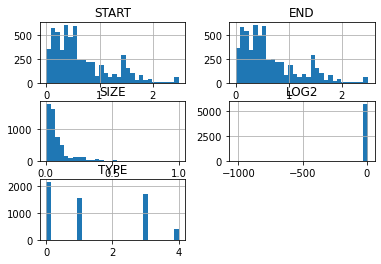

In [90]:
qdnaseq_df.hist(bins=30)

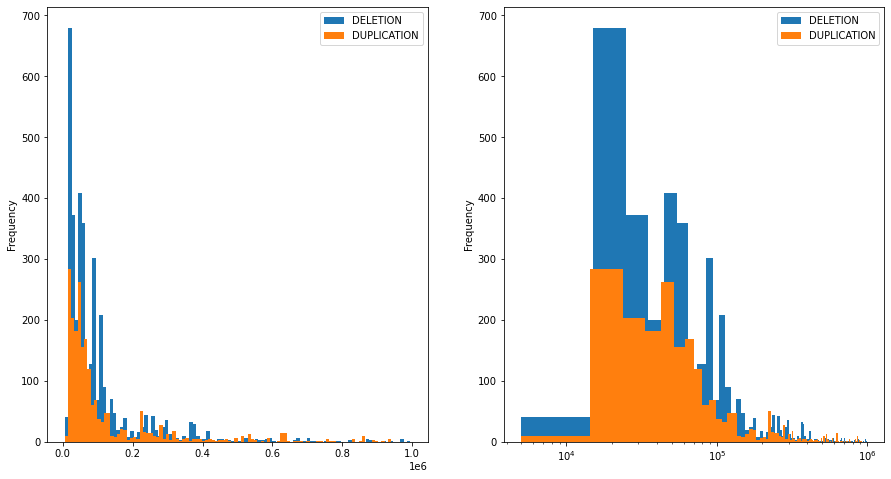

In [91]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8))

df = qdnaseq_df.groupby(['SCORE'])['SIZE']

df.plot(kind='hist',stacked=True, bins=100, legend=True, ax=axs[0]) # alpha for transparency

plt.xscale('log')
#plt.show()

df = qdnaseq_df.groupby(['SCORE'])['SIZE']

df.plot(kind='hist',stacked=True, bins=100, legend=True, ax=axs[1]) # alpha for transparency

plt.show()

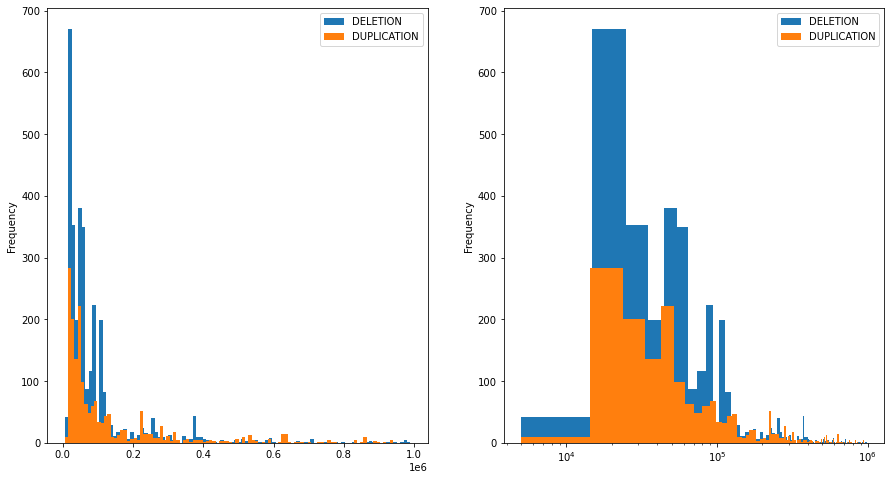

In [92]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8))

df = qdnaseq_df_no_sex_chr.groupby(['SCORE'])['SIZE']

df.plot(kind='hist',stacked=True, bins=100, legend=True, ax=axs[0]) # alpha for transparency

plt.xscale('log')
#plt.show()

df = qdnaseq_df_no_sex_chr.groupby(['SCORE'])['SIZE']

df.plot(kind='hist',stacked=True, bins=100, legend=True, ax=axs[1]) # alpha for transparency

plt.show()

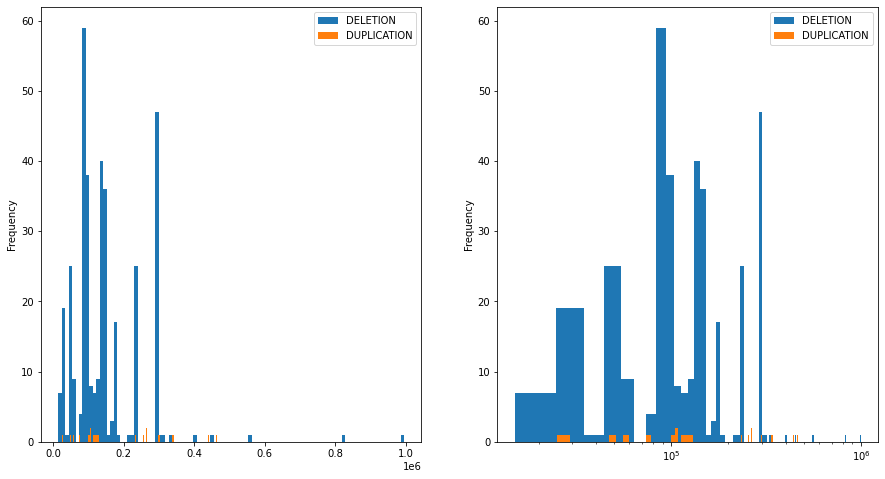

In [93]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8))

df = qdnaseq_df_x.groupby(['SCORE'])['SIZE']

df.plot(kind='hist',stacked=True, bins=100, legend=True, ax=axs[0]) # alpha for transparency

plt.xscale('log')
#plt.show()

df = qdnaseq_df_x.groupby(['SCORE'])['SIZE']

df.plot(kind='hist',stacked=True, bins=100, legend=True, ax=axs[1]) # alpha for transparency

plt.show()

In [94]:

#CHANGED TO RD VALUE
#qdnaseq_df['LOG2'] =np.exp(qdnaseq_df['LOG2'])

In [95]:
qdnaseq_df

SAMPLE CHR      START        END    SIZE        SCORE  LOG2  TYPE
3      SAMEA3302714   2  219885001  219930000   45000  DUPLICATION  0.51     3
6      SAMEA3302714   5   46035001   46110000   75000  DUPLICATION  0.57     3
9      SAMEA3302714   9   42210001   42465000  255000  DUPLICATION  0.47     3
11     SAMEA3302714  10   46170001   46800000  630000  DUPLICATION  0.57     3
14     SAMEA3302714  14   19725001   19950000  225000  DUPLICATION  1.32     4
...             ...  ..        ...        ...     ...          ...   ...   ...
13578  SAMEA3302802  15   24435001   24475000   40000     DELETION -1.01     1
13592  SAMEA3302802  18      60001      95000   35000     DELETION -0.64     1
13600  SAMEA3302802  22   38965001   38990000   25000     DELETION -0.93     1
13603  SAMEA3302802   X   72740001   72980000  240000     DELETION -4.21     0
13609  SAMEA3302802   Y   10245001   10610000  365000     DELETION -6.80     0

[5817 rows x 8 columns]

In [96]:
#LOG TRANSFORMATION

deletions = qdnaseq_df[qdnaseq_df['TYPE'] < 2] 
duplications= qdnaseq_df[qdnaseq_df['TYPE'] > 2] 



In [100]:
qdnaseq_pvt = qdnaseq_df.pivot_table(index=["CHR", "START", "END"], 
                    columns='SAMPLE', 
                    values='LOG2').reset_index()

qdnaseq_pvt

SAMPLE CHR     START       END  SAMEA3302610  SAMEA3302611  SAMEA3302613  \
0        1     85001    195000           NaN           NaN           NaN   
1        1     85001    635000           NaN           NaN           NaN   
2        1     85001    850000           NaN           NaN           NaN   
3        1     85001    915000           NaN           NaN           NaN   
4        1    810001    915000           NaN           NaN           NaN   
...     ..       ...       ...           ...           ...           ...   
2232     Y  21860001  22740000           NaN           NaN           NaN   
2233     Y  56765001  56890000           NaN           NaN           NaN   
2234     Y  56820001  56890000          1.97           NaN          1.71   
2235     Y  56820001  56895000           NaN           NaN           NaN   
2236     Y  56835001  56895000           NaN          1.35           NaN   

SAMPLE  SAMEA3302614  SAMEA3302615  SAMEA3302616  SAMEA3302618  ...  \
0                NaN           NaN           NaN           NaN  ...   
1                NaN           NaN           NaN           NaN  ...   
2                NaN           NaN           NaN           NaN  ...   
3                NaN           NaN           NaN           NaN  ...   
4                NaN           NaN           NaN           NaN  ...   
...              ...           ...           ...           ...  ...   
2232             NaN           NaN           NaN           NaN  ...   
2233             NaN           NaN           NaN           NaN  ...   
2234             NaN          1.96           NaN          1.94  ...   
2235             NaN           NaN           NaN           NaN  ...   
2236            1.05           NaN          1.16           NaN  ...   

SAMPLE  SAMEA3302894  SAMEA3302896  SAMEA3302900  SAMEA3302902  SAMEA3302903  \
0                NaN           NaN           NaN           NaN           NaN   
1                NaN           NaN           NaN           NaN           NaN   
2                NaN           NaN           NaN           NaN           NaN   
3                NaN           NaN           NaN           NaN           NaN   
4                NaN           NaN           NaN           NaN           NaN   
...              ...           ...           ...           ...           ...   
2232             NaN           NaN           NaN           NaN           NaN   
2233             NaN           NaN           NaN           NaN           NaN   
2234             NaN          1.48           NaN           NaN          1.67   
2235             NaN           NaN          2.02          2.09           NaN   
2236             NaN           NaN           NaN           NaN           NaN   

SAMPLE  SAMEA3302904  SAMEA3302906  SAMEA3302908  SAMEA3302911  SAMEA3449877  
0                NaN           NaN           NaN           NaN           NaN  
1                NaN           NaN           NaN           NaN           NaN  
2                NaN           NaN           NaN           NaN           NaN  
3                NaN           NaN           NaN          0.79           NaN  
4                NaN           NaN           NaN           NaN           NaN  
...              ...           ...           ...           ...           ...  
2232             NaN           NaN           NaN           NaN           NaN  
2233             NaN           NaN           NaN          2.17           NaN  
2234             NaN          1.67          1.85           NaN           NaN  
2235             NaN           NaN           NaN           NaN          1.78  
2236            1.31           NaN           NaN           NaN           NaN  

[2237 rows x 241 columns]

In [101]:
counts = qdnaseq_pvt.iloc[:,3:283]

counts = counts.fillna(0)

hist = (np.array(counts).flatten())
#seaborn.histplot(hist)
counts 

SAMPLE  SAMEA3302610  SAMEA3302611  SAMEA3302613  SAMEA3302614  SAMEA3302615  \
0               0.00          0.00          0.00          0.00          0.00   
1               0.00          0.00          0.00          0.00          0.00   
2               0.00          0.00          0.00          0.00          0.00   
3               0.00          0.00          0.00          0.00          0.00   
4               0.00          0.00          0.00          0.00          0.00   
...              ...           ...           ...           ...           ...   
2232            0.00          0.00          0.00          0.00          0.00   
2233            0.00          0.00          0.00          0.00          0.00   
2234            1.97          0.00          1.71          0.00          1.96   
2235            0.00          0.00          0.00          0.00          0.00   
2236            0.00          1.35          0.00          1.05          0.00   

SAMPLE  SAMEA3302616  SAMEA3302618  SAMEA3302619  SAMEA3302620  SAMEA3302621  \
0               0.00          0.00          0.00          0.00          0.00   
1               0.00          0.00          0.00          0.00          0.00   
2               0.00          0.00          0.00          0.00          0.00   
3               0.00          0.00          0.00          0.00          0.00   
4               0.00          0.00          0.00          0.00          0.00   
...              ...           ...           ...           ...           ...   
2232            0.00          0.00          0.00          0.00          0.00   
2233            0.00          0.00          0.00          0.00          0.00   
2234            0.00          1.94          1.56          0.00          1.66   
2235            0.00          0.00          0.00          0.00          0.00   
2236            1.16          0.00          0.00          1.39          0.00   

SAMPLE  ...  SAMEA3302894  SAMEA3302896  SAMEA3302900  SAMEA3302902  \
0       ...           0.0          0.00          0.00          0.00   
1       ...           0.0          0.00          0.00          0.00   
2       ...           0.0          0.00          0.00          0.00   
3       ...           0.0          0.00          0.00          0.00   
4       ...           0.0          0.00          0.00          0.00   
...     ...           ...           ...           ...           ...   
2232    ...           0.0          0.00          0.00          0.00   
2233    ...           0.0          0.00          0.00          0.00   
2234    ...           0.0          1.48          0.00          0.00   
2235    ...           0.0          0.00          2.02          2.09   
2236    ...           0.0          0.00          0.00          0.00   

SAMPLE  SAMEA3302903  SAMEA3302904  SAMEA3302906  SAMEA3302908  SAMEA3302911  \
0               0.00          0.00          0.00          0.00          0.00   
1               0.00          0.00          0.00          0.00          0.00   
2               0.00          0.00          0.00          0.00          0.00   
3               0.00          0.00          0.00          0.00          0.79   
4               0.00          0.00          0.00          0.00          0.00   
...              ...           ...           ...           ...           ...   
2232            0.00          0.00          0.00          0.00          0.00   
2233            0.00          0.00          0.00          0.00          2.17   
2234            1.67          0.00          1.67          1.85          0.00   
2235            0.00          0.00          0.00          0.00          0.00   
2236            0.00          1.31          0.00          0.00          0.00   

SAMPLE  SAMEA3449877  
0               0.00  
1               0.00  
2               0.00  
3               0.00  
4               0.00  
...              ...  
2232            0.00  
2233            0.00  
2234            0.00  
2235            1.78  
2236       

/opt/anaconda3/lib/python3.6/site-packages/seaborn/matrix.py:624: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


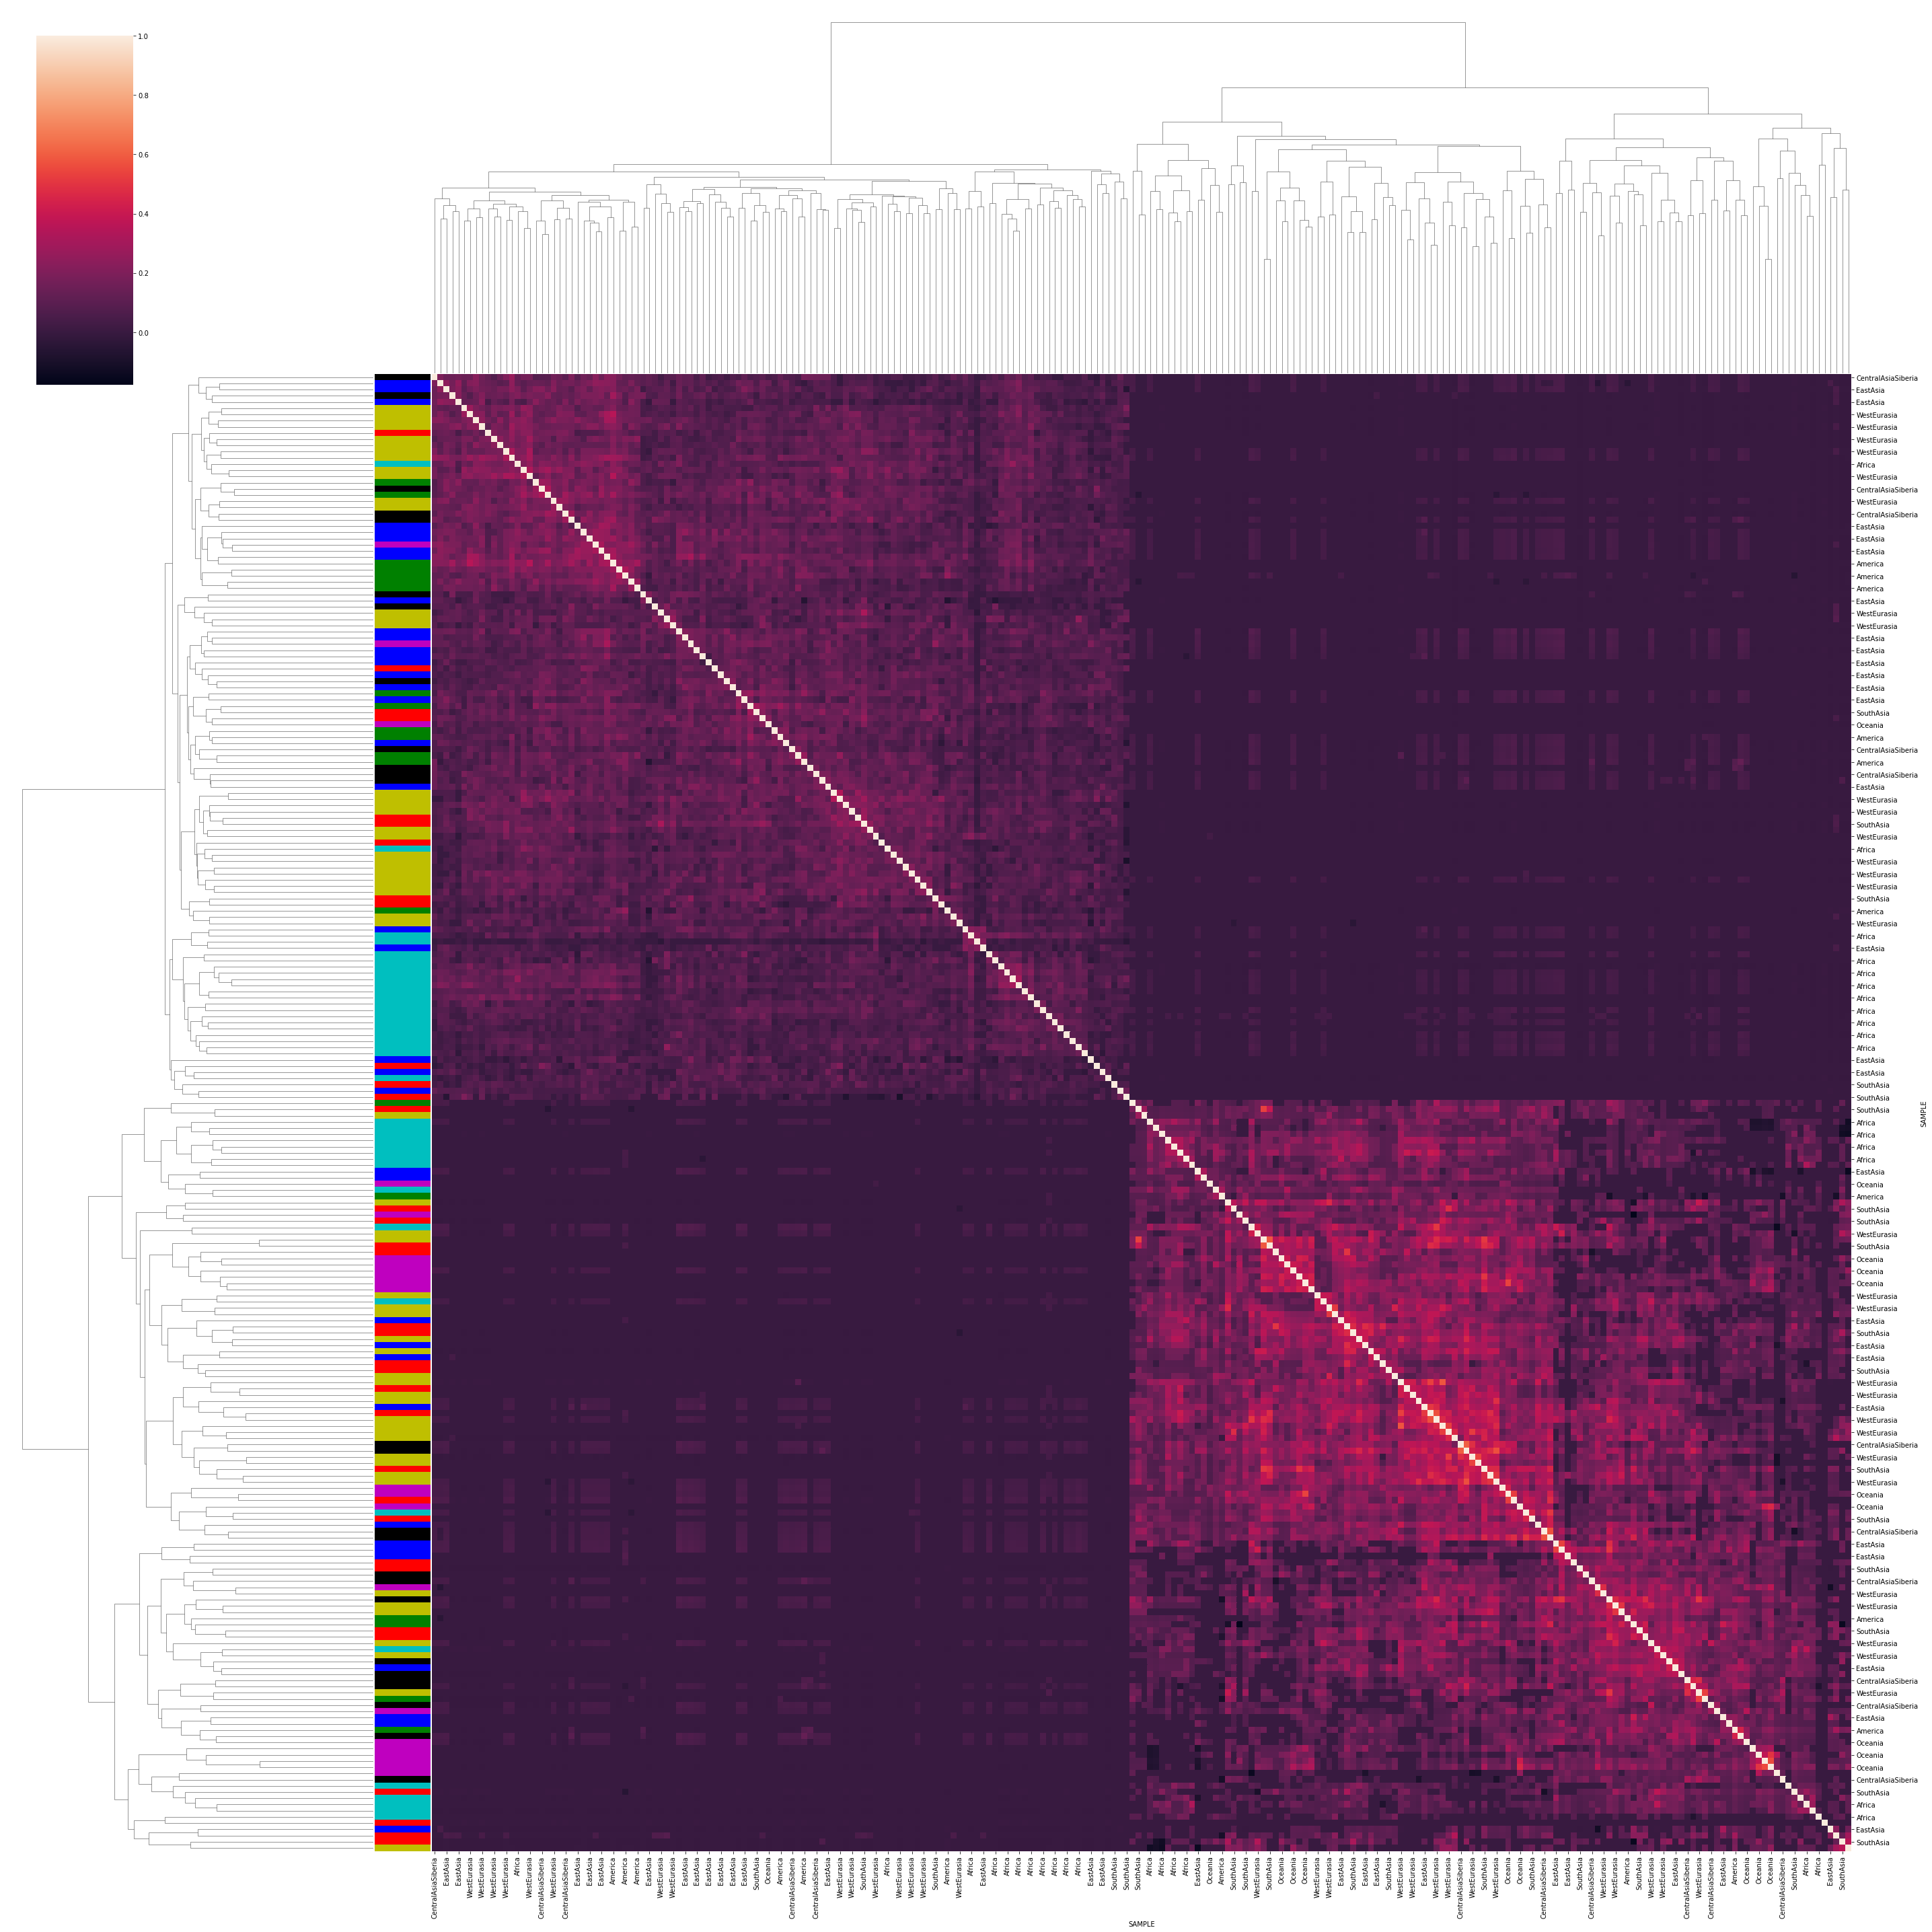

In [102]:
#f, ax = plt.subplots(figsize=(20, 20))

input_matrix = counts.rename(columns=anotation['10-Region'])
corrmatrix = input_matrix.corr(method='spearman', min_periods=10)
#corrmatrix = np.corrcoef(input_matrix)

import seaborn as sns#; sns.set_theme(color_codes=True)
lut = dict(zip(corrmatrix.columns.unique(), "rbgymck"))
lut

row_colors = corrmatrix.columns.map(lut)
seaborn.clustermap(corrmatrix,row_colors=row_colors, row_cluster=True, figsize=(40,40))
#plt.show()

<h2> PCA

In [103]:
#track features for pca & tsne
count = counts.T
features = anotation.merge(count, left_index=True, right_index=True)
features = features.loc[:,["7-Gender","10-Region", "11-Country"]]
features = features.sort_index()
features

#imputation and normalization 
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X = imp.fit_transform(counts.T)
X = StandardScaler().fit_transform(counts.T)


#PCA
#pca = PCA(.95)
pca = PCA(n_components=10)
pca_results = pca.fit_transform(X)

df_pca= pd.DataFrame(pca_results,
                          columns=['component_1','component_2', 'component_3','component_4','component_5', 'component_6', 'component_7','component_8', 'component_9','component_10'],
                          index=features.index)




df_pca = features.merge(df_pca, left_index=True, right_index=True)
df_pca 

7-Gender  10-Region 11-Country  component_1  component_2  \
SAMEA3302610        M  SouthAsia      India    -1.606023     0.836784   
SAMEA3302611        F   EastAsia      China    -1.030335     1.012084   
SAMEA3302613        F   EastAsia    Vietnam    -1.354669    -0.032595   
SAMEA3302614        F   EastAsia      China    -0.909308     0.873294   
SAMEA3302615        M   EastAsia      China    -0.957770     0.902542   
...               ...        ...        ...          ...          ...   
SAMEA3302904        F    America     Mexico    -1.041311     1.000431   
SAMEA3302906        F   EastAsia      Japan    -1.097297    -0.093637   
SAMEA3302908        M    Oceania        USA    -1.037309    -0.527373   
SAMEA3302911        M  SouthAsia      Nepal    -0.954713     1.182220   
SAMEA3449877        M  SouthAsia   Pakistan    -1.173045     1.191539   

              component_3  component_4  component_5  component_6  component_7  \
SAMEA3302610    -2.837188     2.094144    -0.002894     1.156918     0.719183   
SAMEA3302611    -0.964625     0.830463    -0.792868     0.068401     0.116069   
SAMEA3302613     0.665925    -3.782049     1.136887    -0.487555    -1.701984   
SAMEA3302614    -0.828802     0.704275    -0.669575     0.058620     0.094111   
SAMEA3302615    -1.097240     0.550537    -0.289220    -0.431068    -0.268280   
...                   ...          ...          ...          ...          ...   
SAMEA3302904    -0.959776     0.758226    -0.726011     0.002372     0.091015   
SAMEA3302906    -0.403128    -1.005202     0.810153    -1.510274    -0.357899   
SAMEA3302908    -0.664437    -0.684443     2.020641     0.106064     1.523149   
SAMEA3302911    -0.315659     0.530075    -0.077954     0.451384    -0.453736   
SAMEA3449877    -1.149145     0.972189    -0.942315     0.073646     0.117627   

              component_8  component_9  component_10  
SAMEA3302610     0.146507    -3.523265      1.070595  
SAMEA3302611    -1.703643     0.638508     -0.549912  
SAMEA3302613     4.277852    -5.966850      0.237867  
SAMEA3302614    -1.417058     0.528653     -0.446660  
SAMEA3302615     0.829350    -1.399459      0.525197  
...                   ...          ...           ...  
SAMEA3302904    -1.494975     0.448638     -0.432723  
SAMEA3302906     3.274969    -3.383511      0.634692  
SAMEA3302908    -0.902682    -1.674224      0.624453  
SAMEA3302911    -0.332542     1.209686     -0.719810  
SAMEA3449877    -2.083060     0.781798     -0.645250  

[238 rows x 13 columns]

In [104]:
pca.explained_variance_ratio_


array([0.01532069, 0.01400715, 0.01369981, 0.01340979, 0.01299635,
       0.01270127, 0.01192711, 0.01165741, 0.01128268, 0.01085154])

          7-Gender 11-Country  component_1  component_2  component_3  \
10-Region                                                              
SouthAsia        M      India    -1.606023     0.836784    -2.837188   
EastAsia         F      China    -1.030335     1.012084    -0.964625   
EastAsia         F    Vietnam    -1.354669    -0.032595     0.665925   
EastAsia         F      China    -0.909308     0.873294    -0.828802   
EastAsia         M      China    -0.957770     0.902542    -1.097240   
...            ...        ...          ...          ...          ...   
America          F     Mexico    -1.041311     1.000431    -0.959776   
EastAsia         F      Japan    -1.097297    -0.093637    -0.403128   
Oceania          M        USA    -1.037309    -0.527373    -0.664437   
SouthAsia        M      Nepal    -0.954713     1.182220    -0.315659   
SouthAsia        M   Pakistan    -1.173045     1.191539    -1.149145   

           component_4  component_5  component_6  component_7  

          7-Gender 11-Country  component_1  component_2  component_3  \
10-Region                                                              
SouthAsia        M      India    -1.606023     0.836784    -2.837188   
EastAsia         F      China    -1.030335     1.012084    -0.964625   
EastAsia         F    Vietnam    -1.354669    -0.032595     0.665925   
EastAsia         F      China    -0.909308     0.873294    -0.828802   
EastAsia         M      China    -0.957770     0.902542    -1.097240   
...            ...        ...          ...          ...          ...   
America          F     Mexico    -1.041311     1.000431    -0.959776   
EastAsia         F      Japan    -1.097297    -0.093637    -0.403128   
Oceania          M        USA    -1.037309    -0.527373    -0.664437   
SouthAsia        M      Nepal    -0.954713     1.182220    -0.315659   
SouthAsia        M   Pakistan    -1.173045     1.191539    -1.149145   

           component_4  component_5  component_6  component_7  

          7-Gender 11-Country  component_1  component_2  component_3  \
10-Region                                                              
SouthAsia        M      India    -1.606023     0.836784    -2.837188   
EastAsia         F      China    -1.030335     1.012084    -0.964625   
EastAsia         F    Vietnam    -1.354669    -0.032595     0.665925   
EastAsia         F      China    -0.909308     0.873294    -0.828802   
EastAsia         M      China    -0.957770     0.902542    -1.097240   
...            ...        ...          ...          ...          ...   
America          F     Mexico    -1.041311     1.000431    -0.959776   
EastAsia         F      Japan    -1.097297    -0.093637    -0.403128   
Oceania          M        USA    -1.037309    -0.527373    -0.664437   
SouthAsia        M      Nepal    -0.954713     1.182220    -0.315659   
SouthAsia        M   Pakistan    -1.173045     1.191539    -1.149145   

           component_4  component_5  component_6  component_7  

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


          7-Gender 11-Country  component_1  component_2  component_3  \
10-Region                                                              
SouthAsia        M      India    -1.606023     0.836784    -2.837188   
EastAsia         F      China    -1.030335     1.012084    -0.964625   
EastAsia         F    Vietnam    -1.354669    -0.032595     0.665925   
EastAsia         F      China    -0.909308     0.873294    -0.828802   
EastAsia         M      China    -0.957770     0.902542    -1.097240   
...            ...        ...          ...          ...          ...   
America          F     Mexico    -1.041311     1.000431    -0.959776   
EastAsia         F      Japan    -1.097297    -0.093637    -0.403128   
Oceania          M        USA    -1.037309    -0.527373    -0.664437   
SouthAsia        M      Nepal    -0.954713     1.182220    -0.315659   
SouthAsia        M   Pakistan    -1.173045     1.191539    -1.149145   

           component_4  component_5  component_6  component_7  

          7-Gender 11-Country  component_1  component_2  component_3  \
10-Region                                                              
SouthAsia        M      India    -1.606023     0.836784    -2.837188   
EastAsia         F      China    -1.030335     1.012084    -0.964625   
EastAsia         F    Vietnam    -1.354669    -0.032595     0.665925   
EastAsia         F      China    -0.909308     0.873294    -0.828802   
EastAsia         M      China    -0.957770     0.902542    -1.097240   
...            ...        ...          ...          ...          ...   
America          F     Mexico    -1.041311     1.000431    -0.959776   
EastAsia         F      Japan    -1.097297    -0.093637    -0.403128   
Oceania          M        USA    -1.037309    -0.527373    -0.664437   
SouthAsia        M      Nepal    -0.954713     1.182220    -0.315659   
SouthAsia        M   Pakistan    -1.173045     1.191539    -1.149145   

           component_4  component_5  component_6  component_7  

          7-Gender 11-Country  component_1  component_2  component_3  \
10-Region                                                              
SouthAsia        M      India    -1.606023     0.836784    -2.837188   
EastAsia         F      China    -1.030335     1.012084    -0.964625   
EastAsia         F    Vietnam    -1.354669    -0.032595     0.665925   
EastAsia         F      China    -0.909308     0.873294    -0.828802   
EastAsia         M      China    -0.957770     0.902542    -1.097240   
...            ...        ...          ...          ...          ...   
America          F     Mexico    -1.041311     1.000431    -0.959776   
EastAsia         F      Japan    -1.097297    -0.093637    -0.403128   
Oceania          M        USA    -1.037309    -0.527373    -0.664437   
SouthAsia        M      Nepal    -0.954713     1.182220    -0.315659   
SouthAsia        M   Pakistan    -1.173045     1.191539    -1.149145   

           component_4  component_5  component_6  component_7  

          7-Gender 11-Country  component_1  component_2  component_3  \
10-Region                                                              
SouthAsia        M      India    -1.606023     0.836784    -2.837188   
EastAsia         F      China    -1.030335     1.012084    -0.964625   
EastAsia         F    Vietnam    -1.354669    -0.032595     0.665925   
EastAsia         F      China    -0.909308     0.873294    -0.828802   
EastAsia         M      China    -0.957770     0.902542    -1.097240   
...            ...        ...          ...          ...          ...   
America          F     Mexico    -1.041311     1.000431    -0.959776   
EastAsia         F      Japan    -1.097297    -0.093637    -0.403128   
Oceania          M        USA    -1.037309    -0.527373    -0.664437   
SouthAsia        M      Nepal    -0.954713     1.182220    -0.315659   
SouthAsia        M   Pakistan    -1.173045     1.191539    -1.149145   

           component_4  component_5  component_6  component_7  

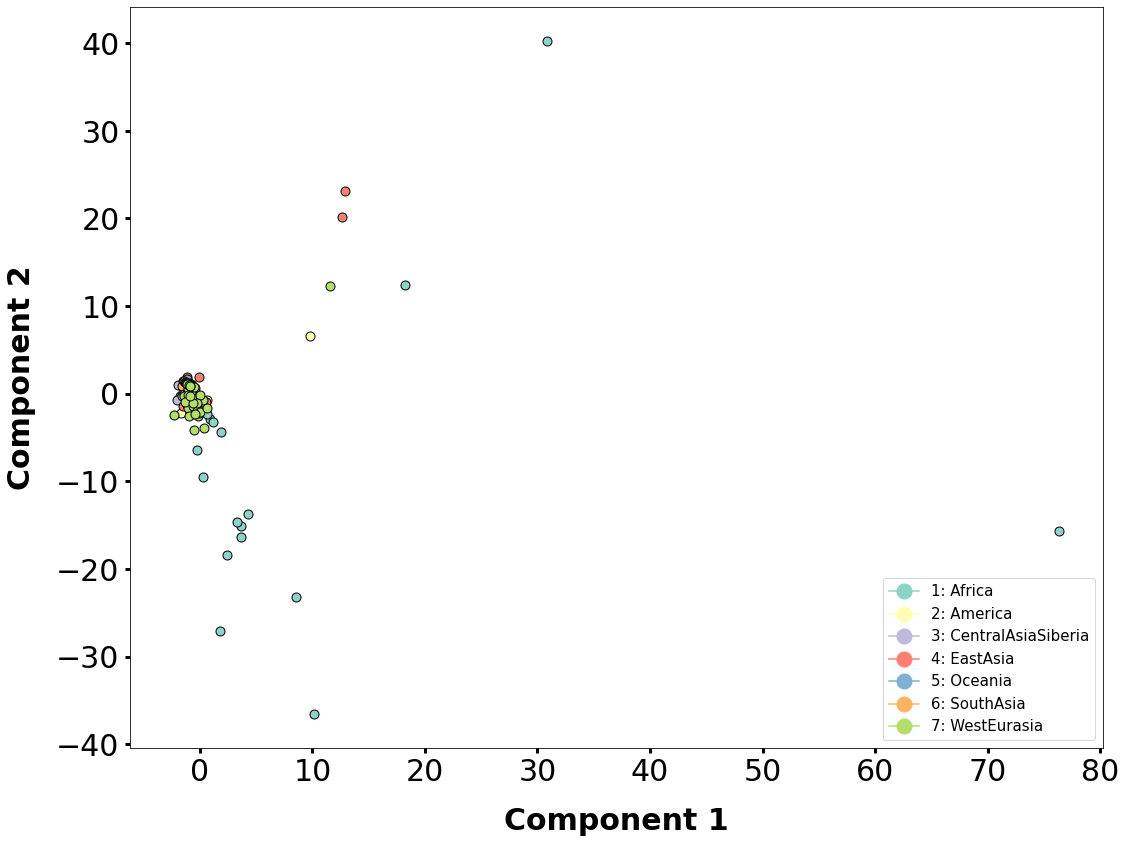

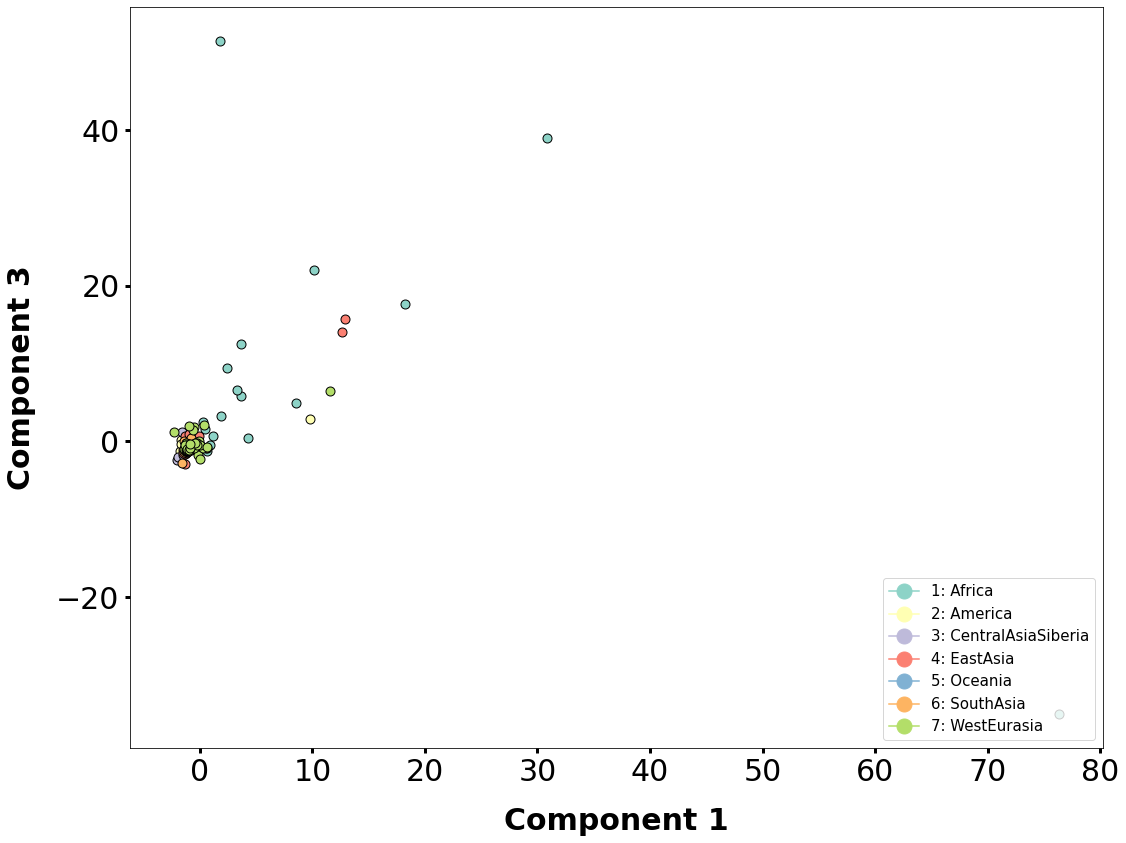

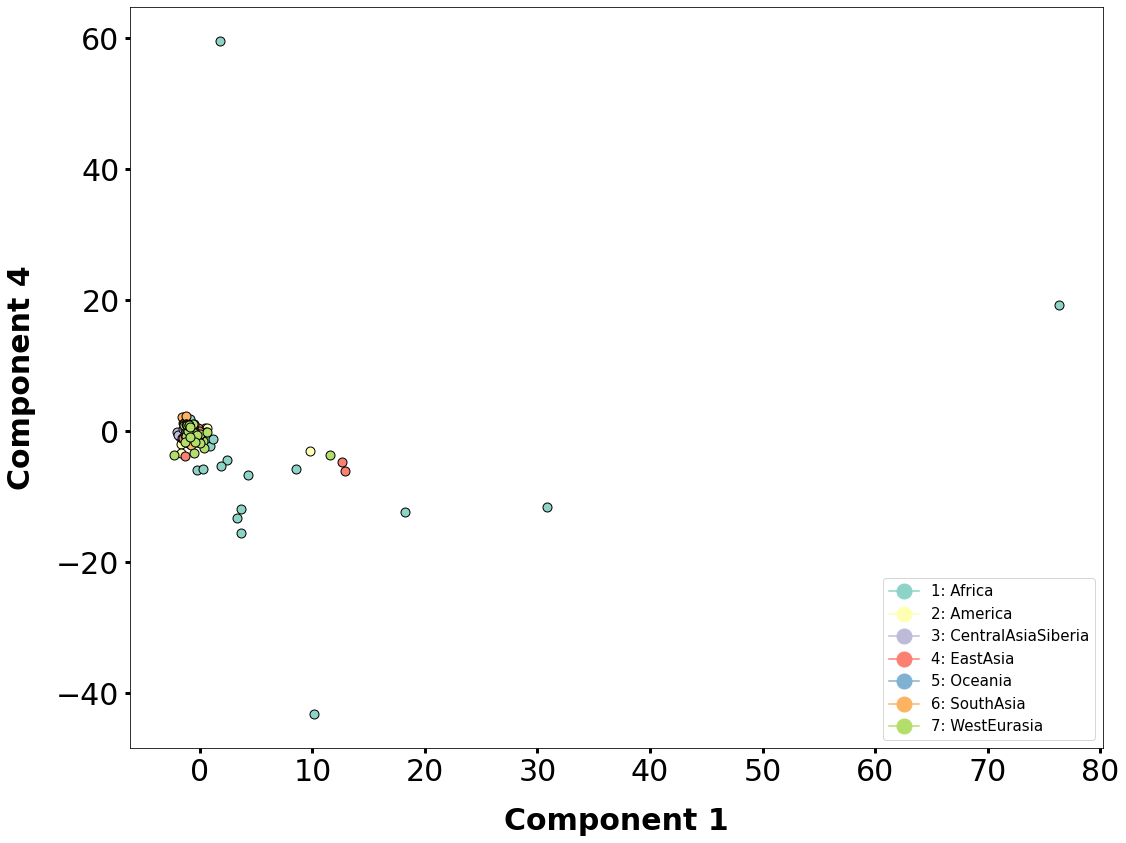

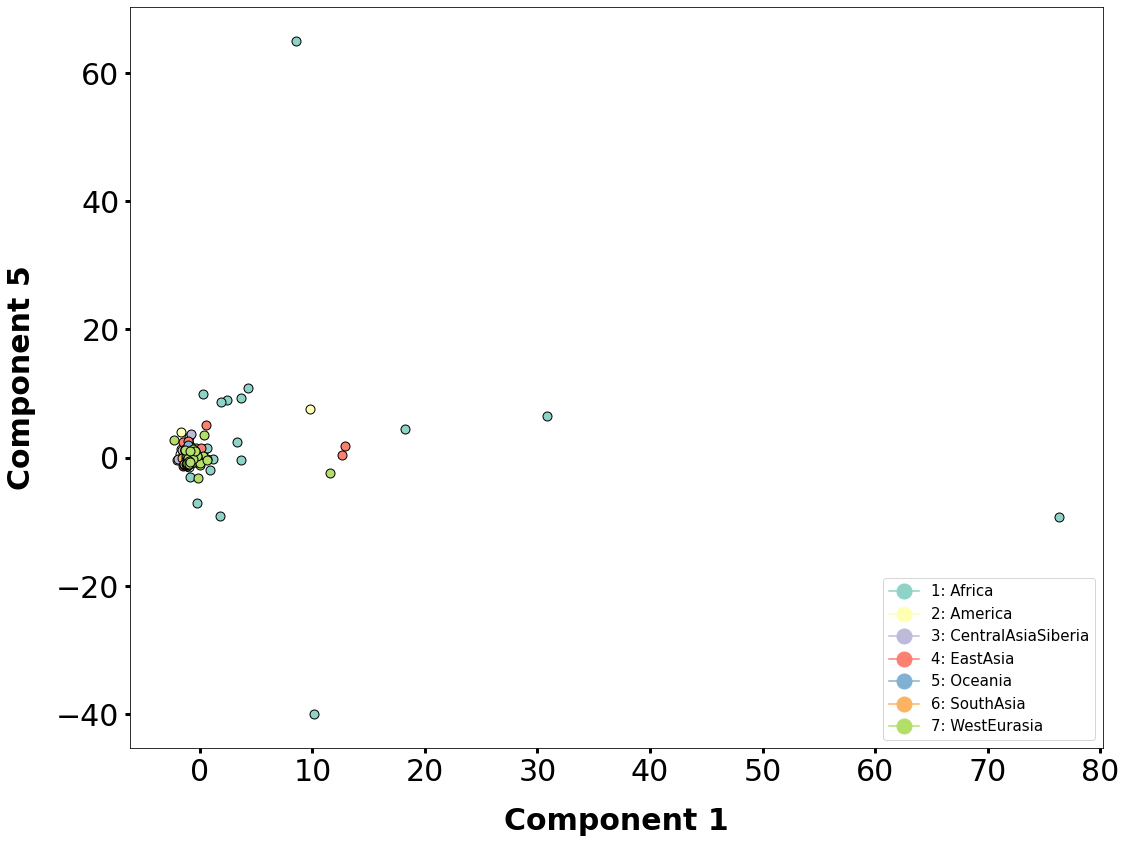

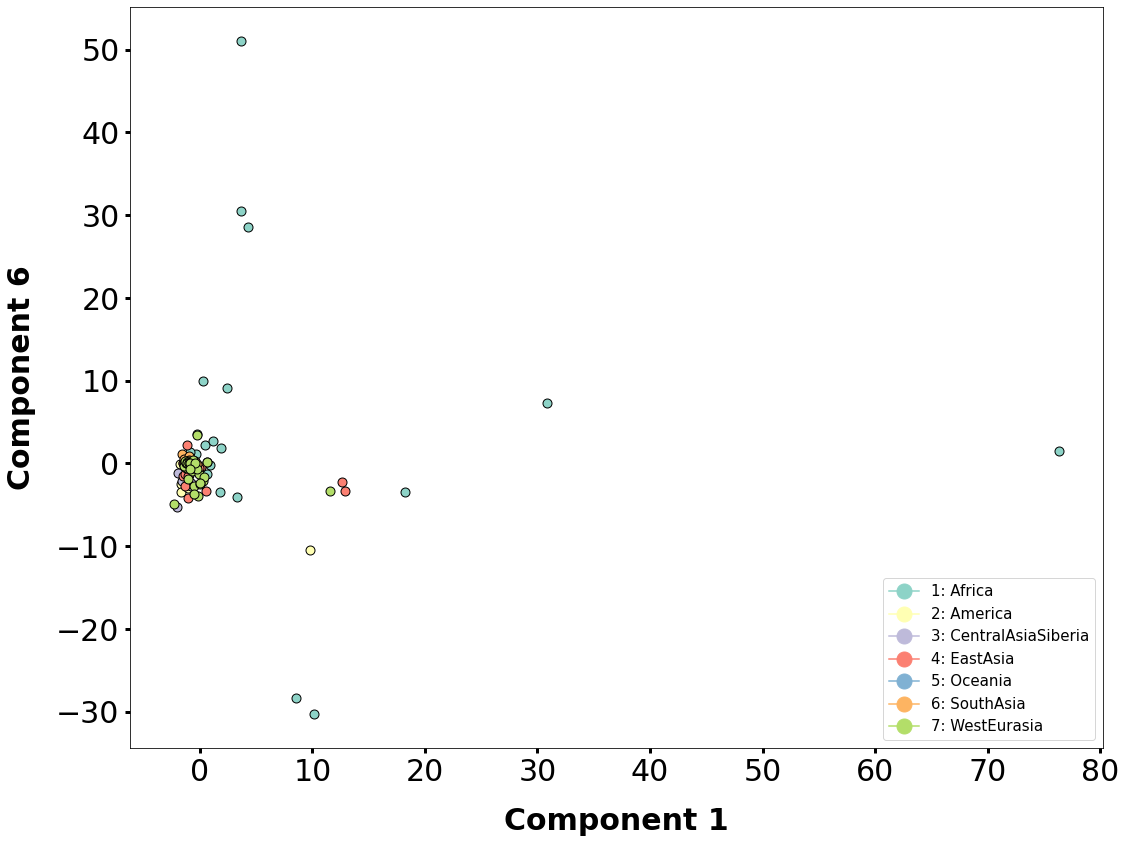

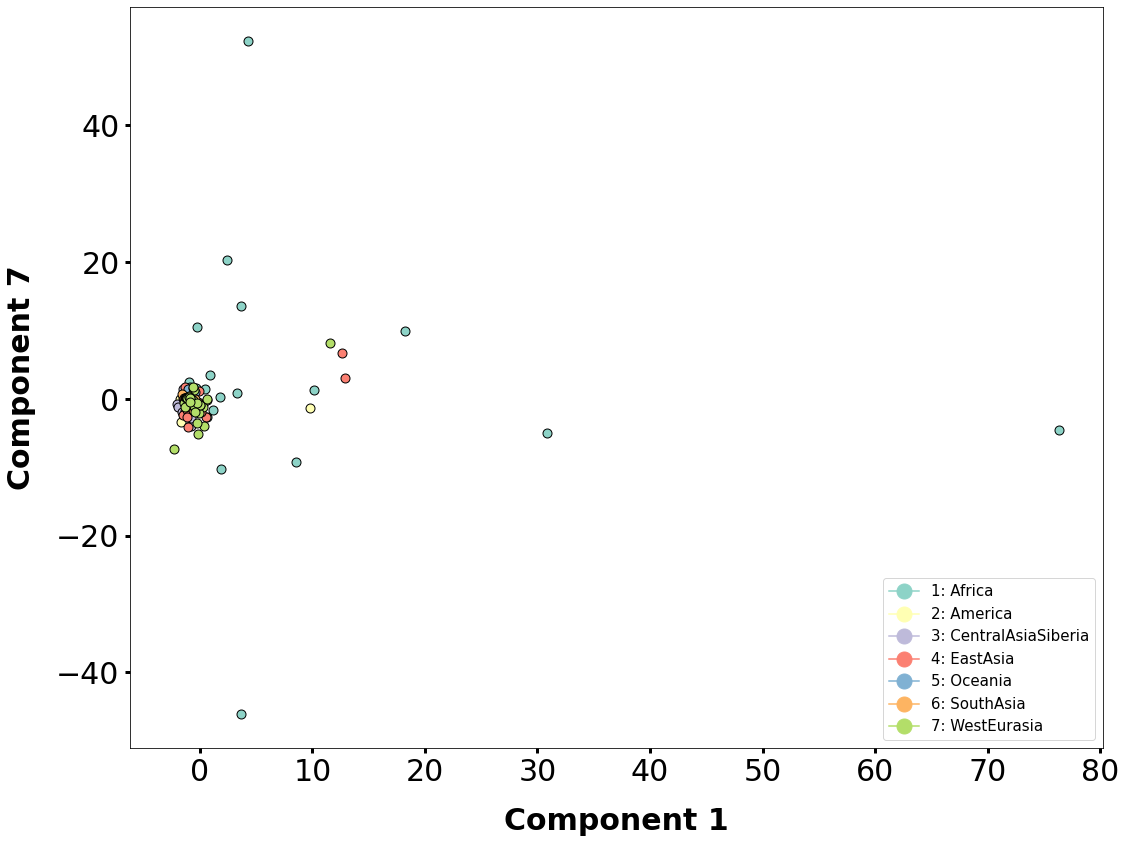

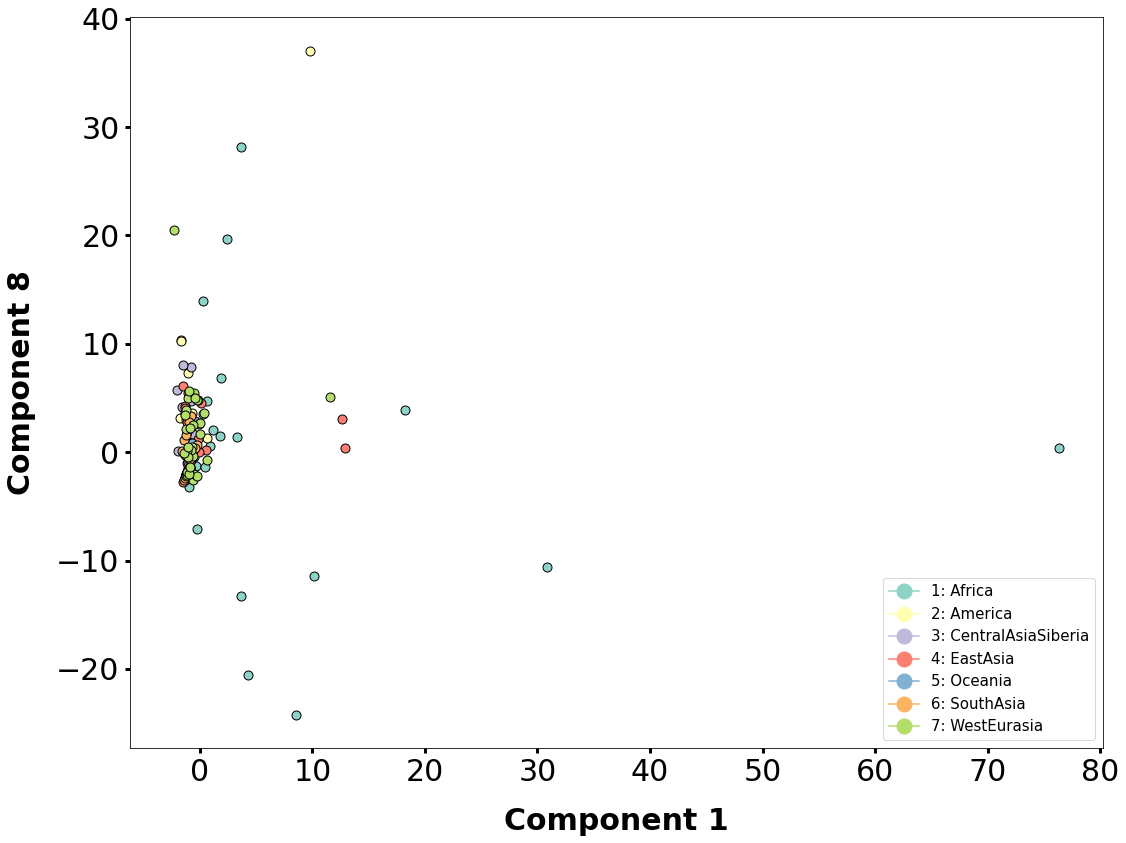

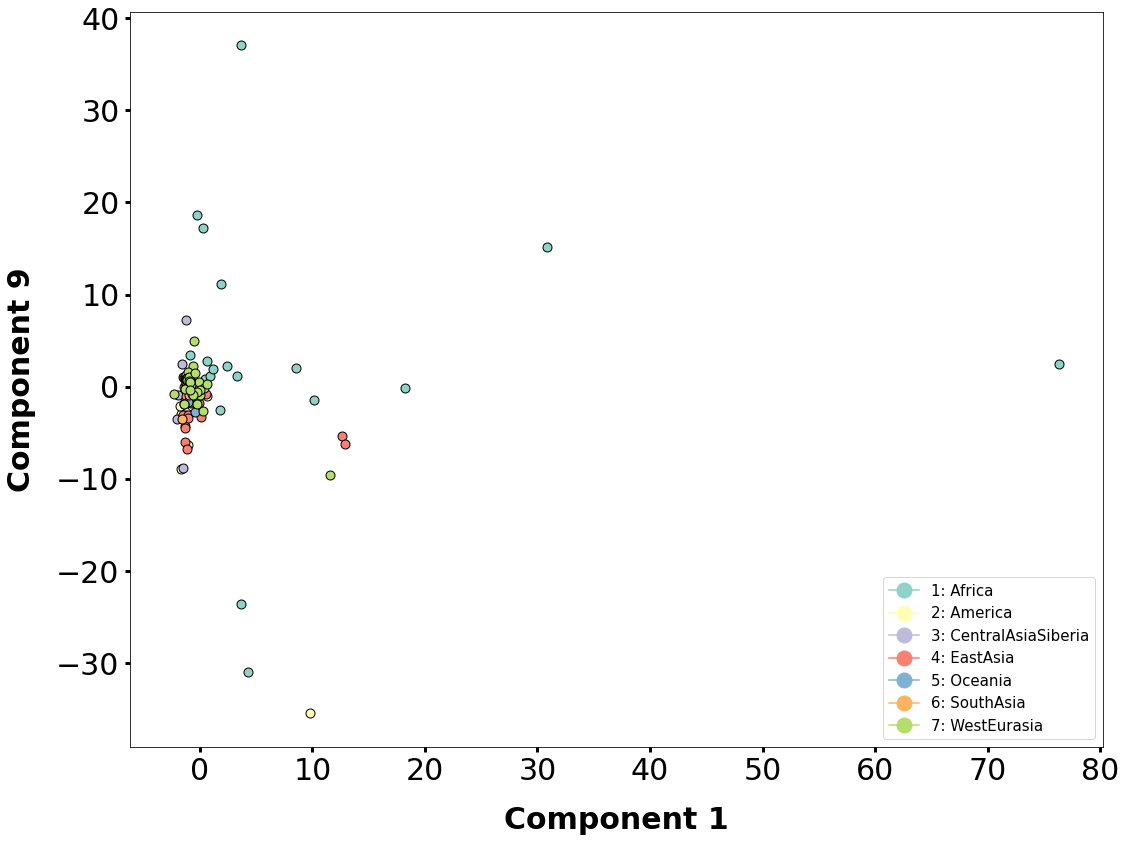

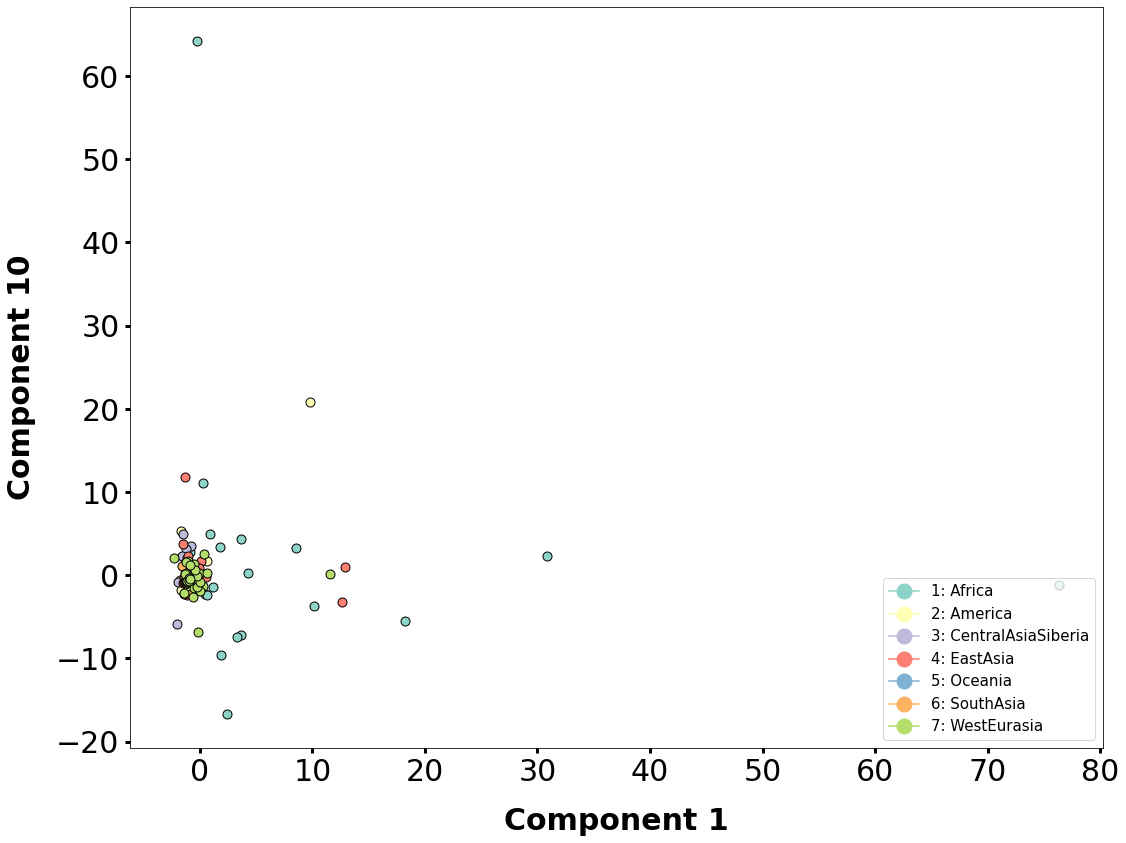

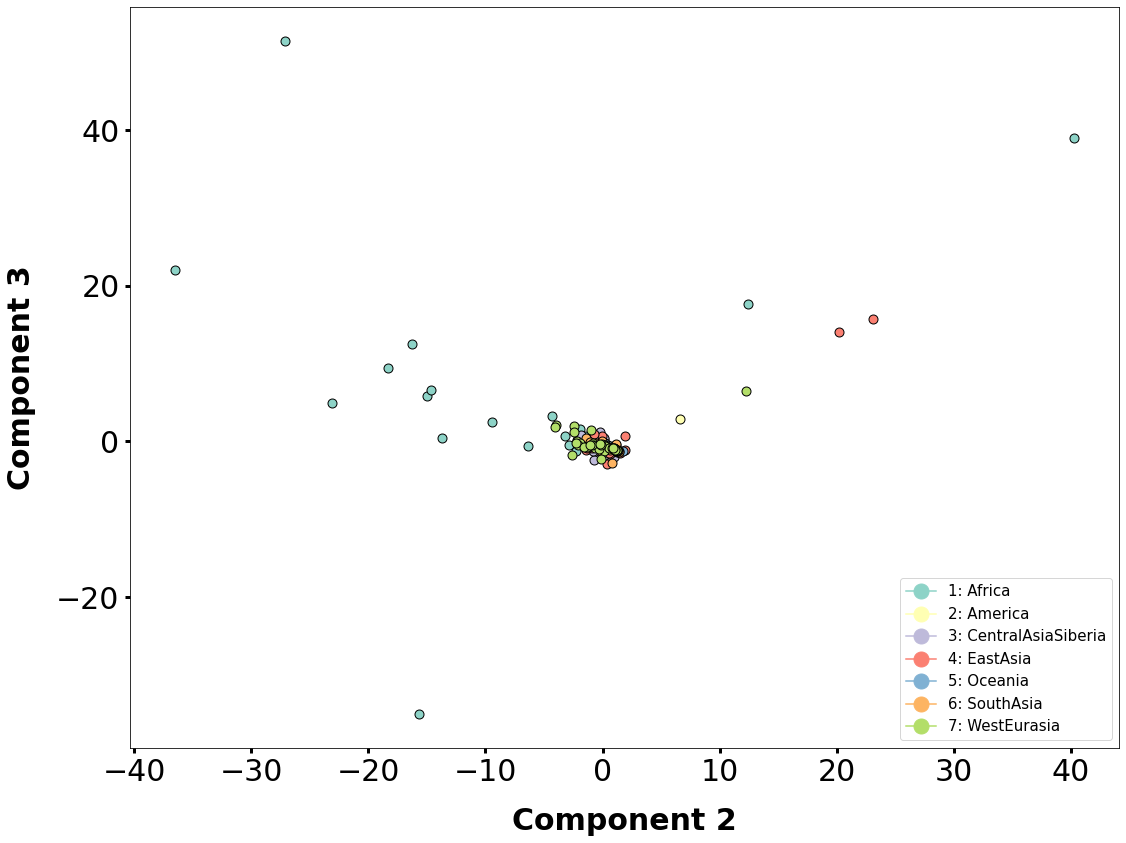

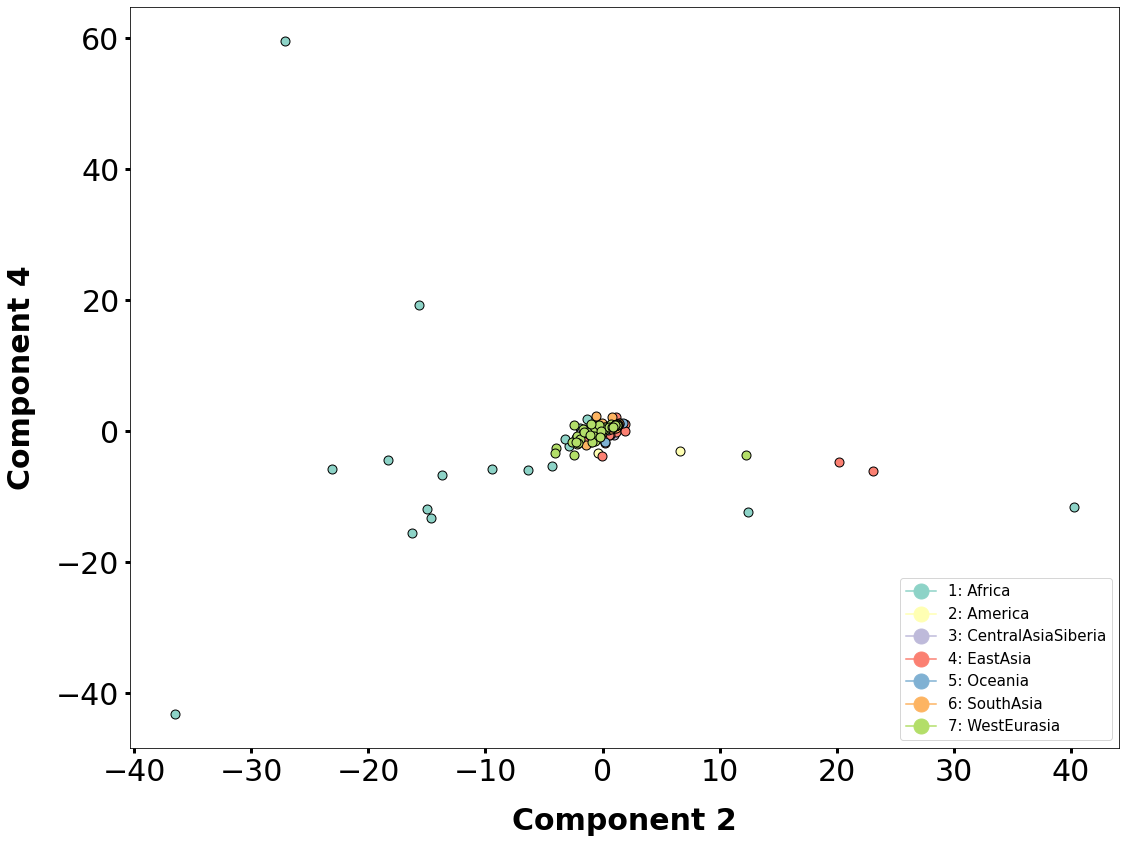

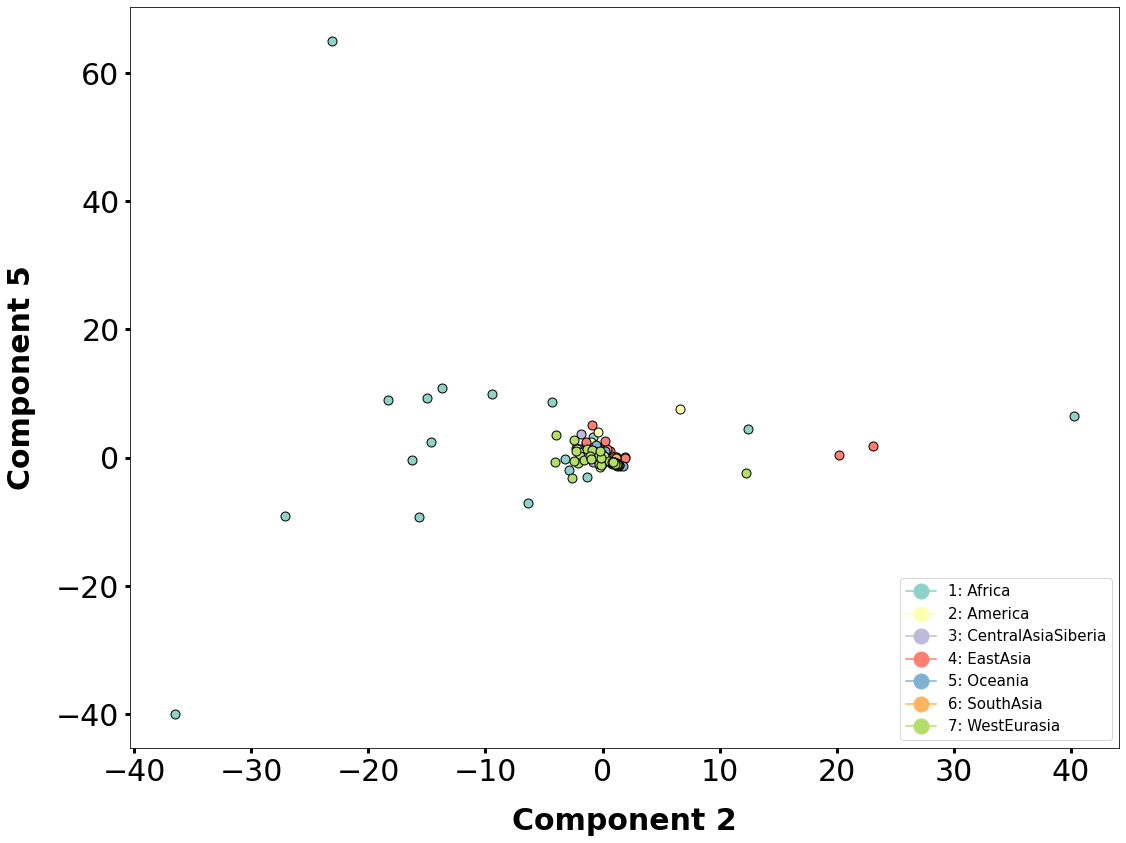

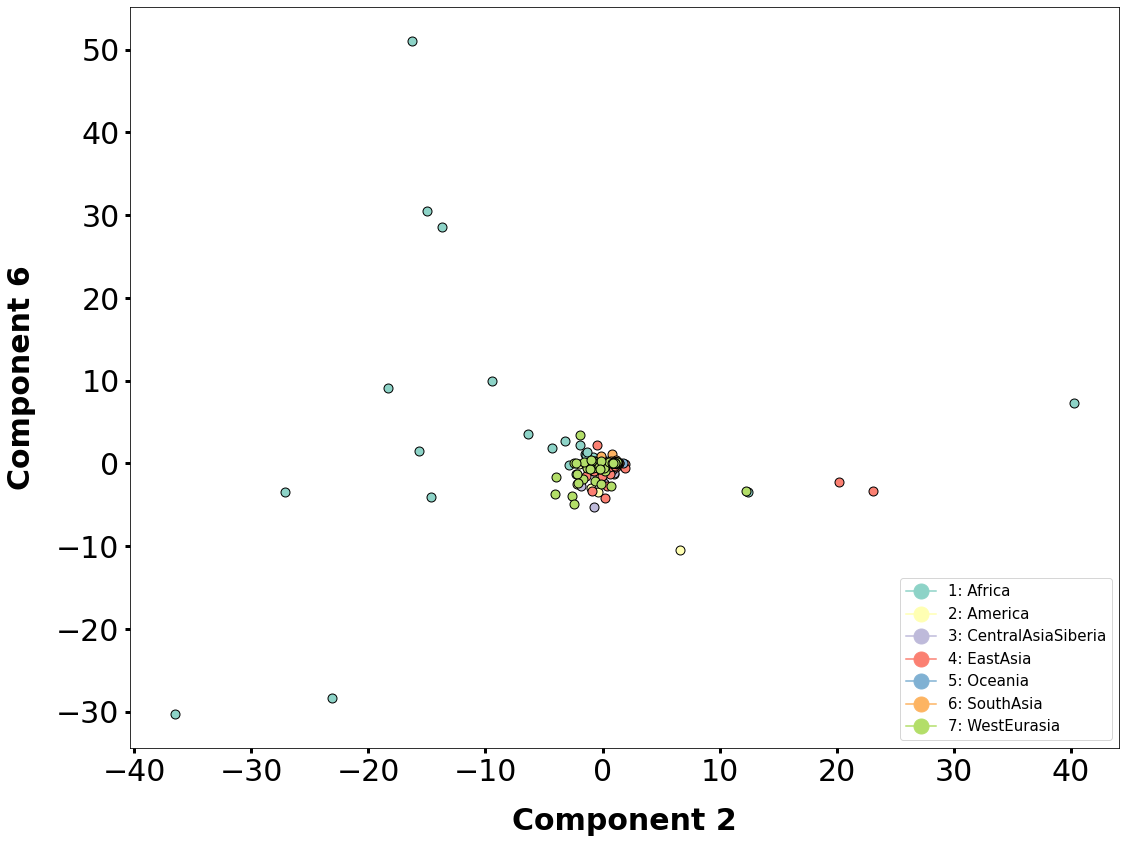

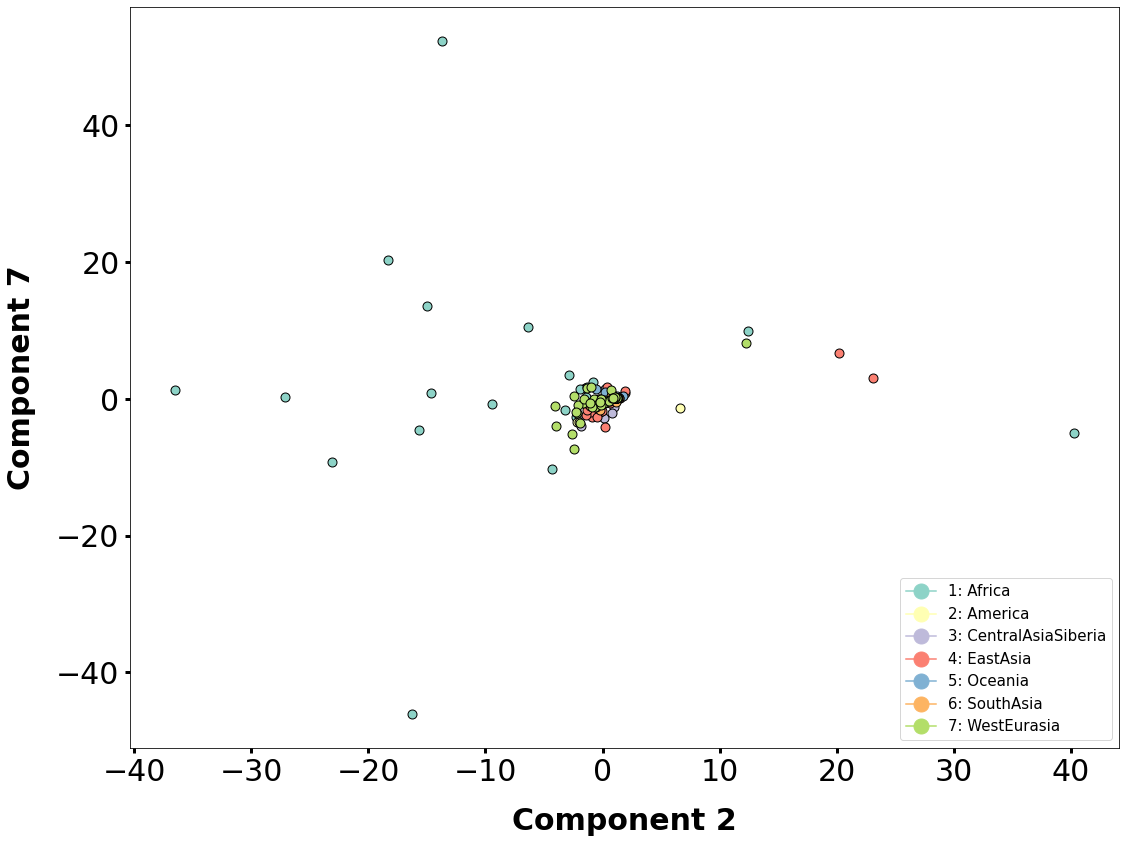

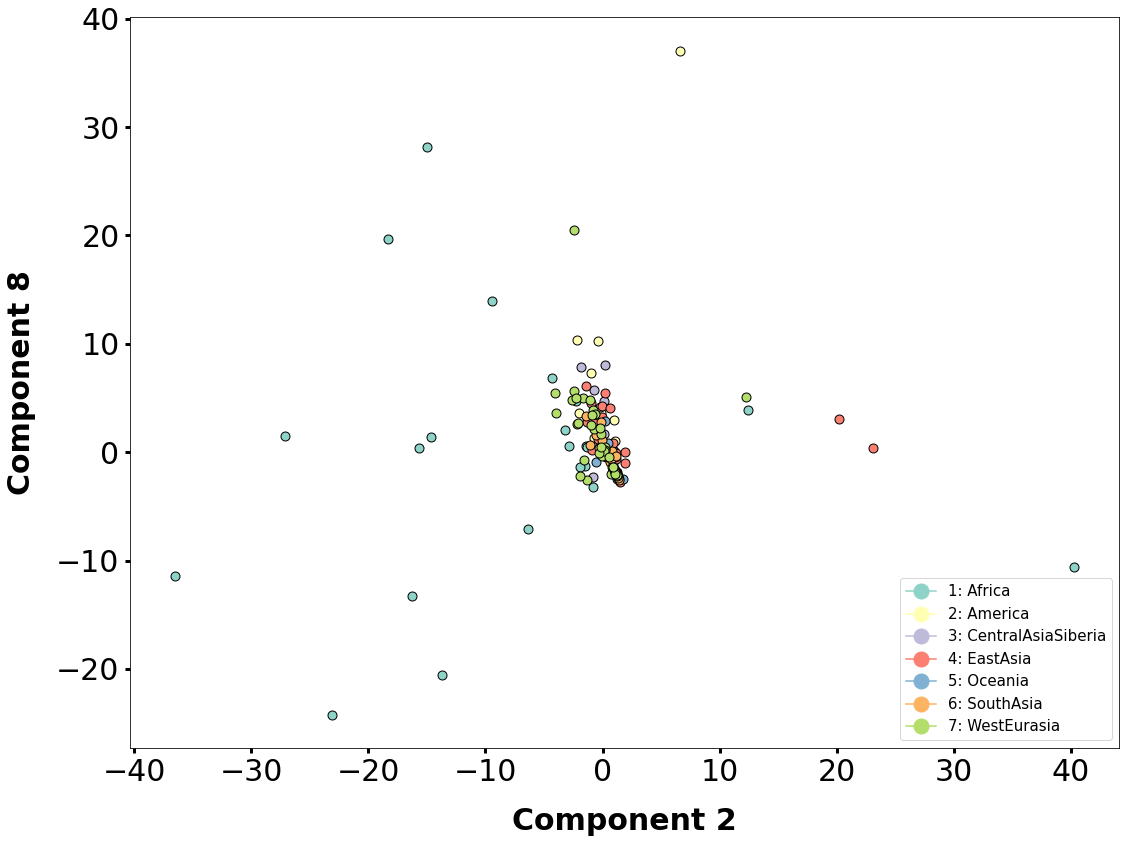

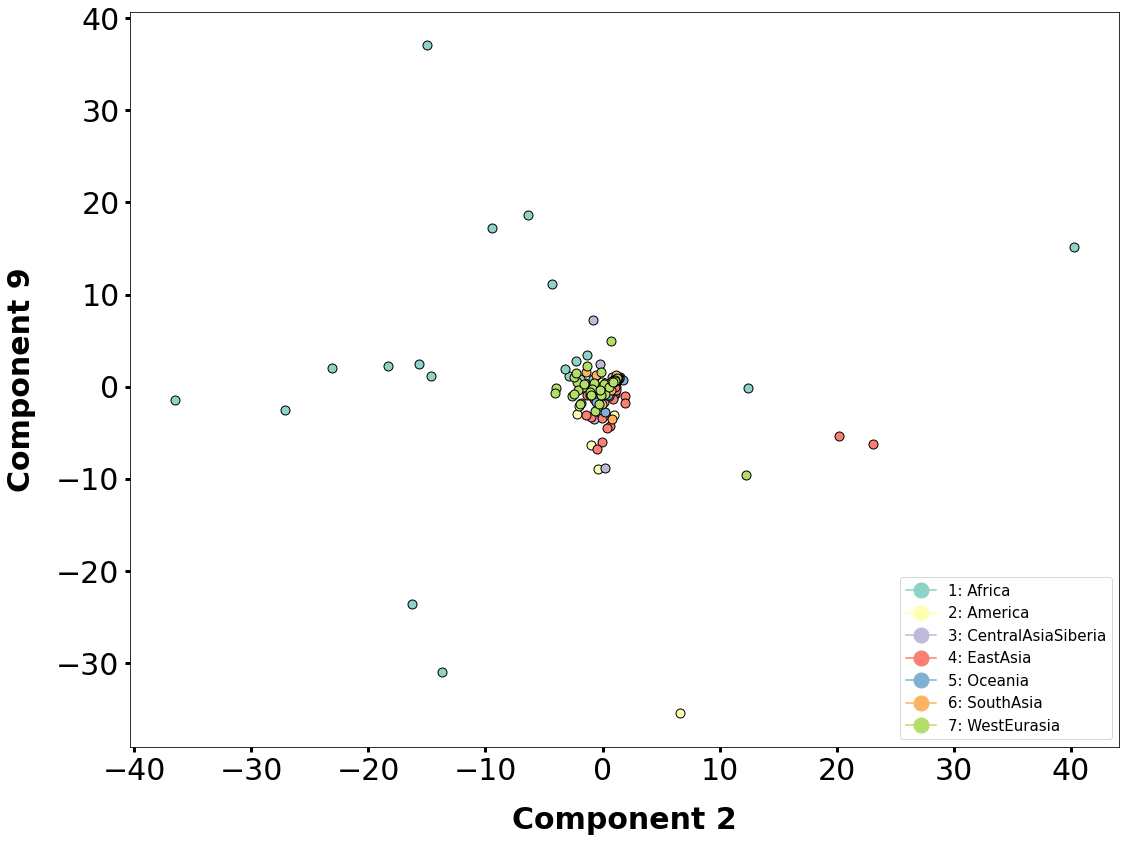

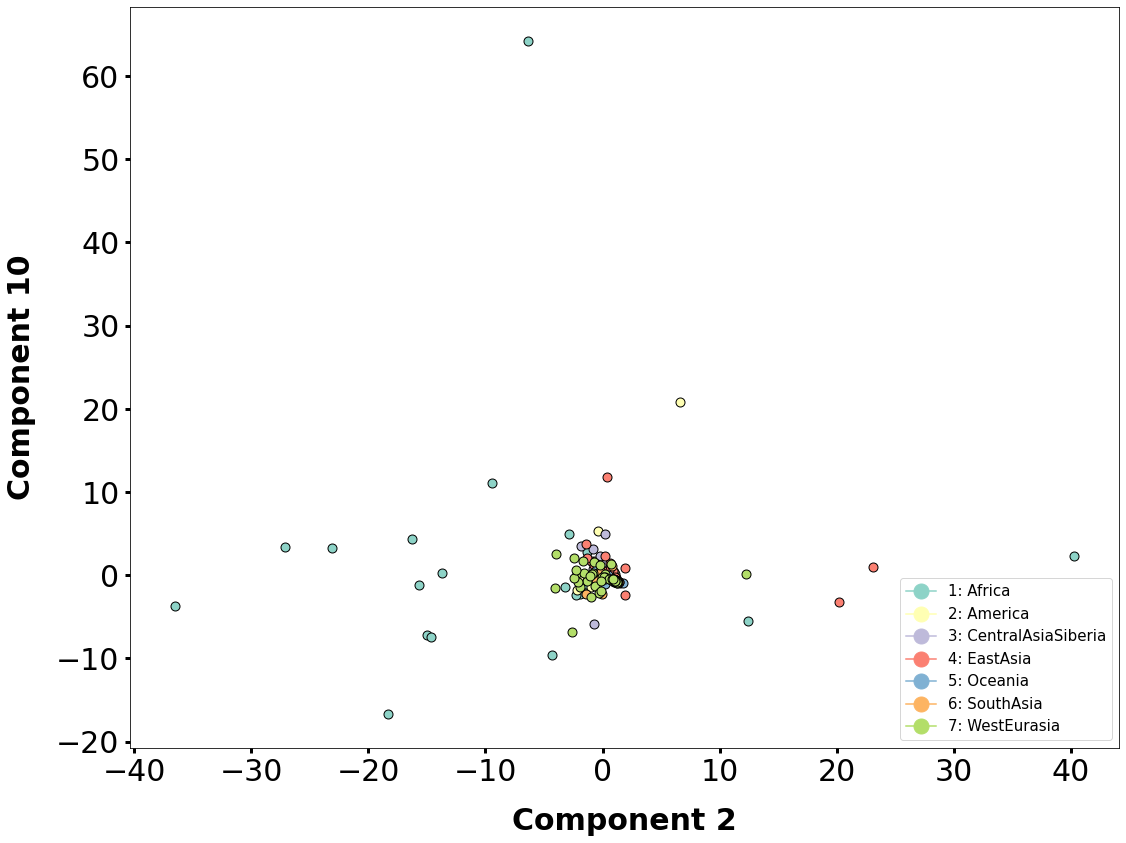

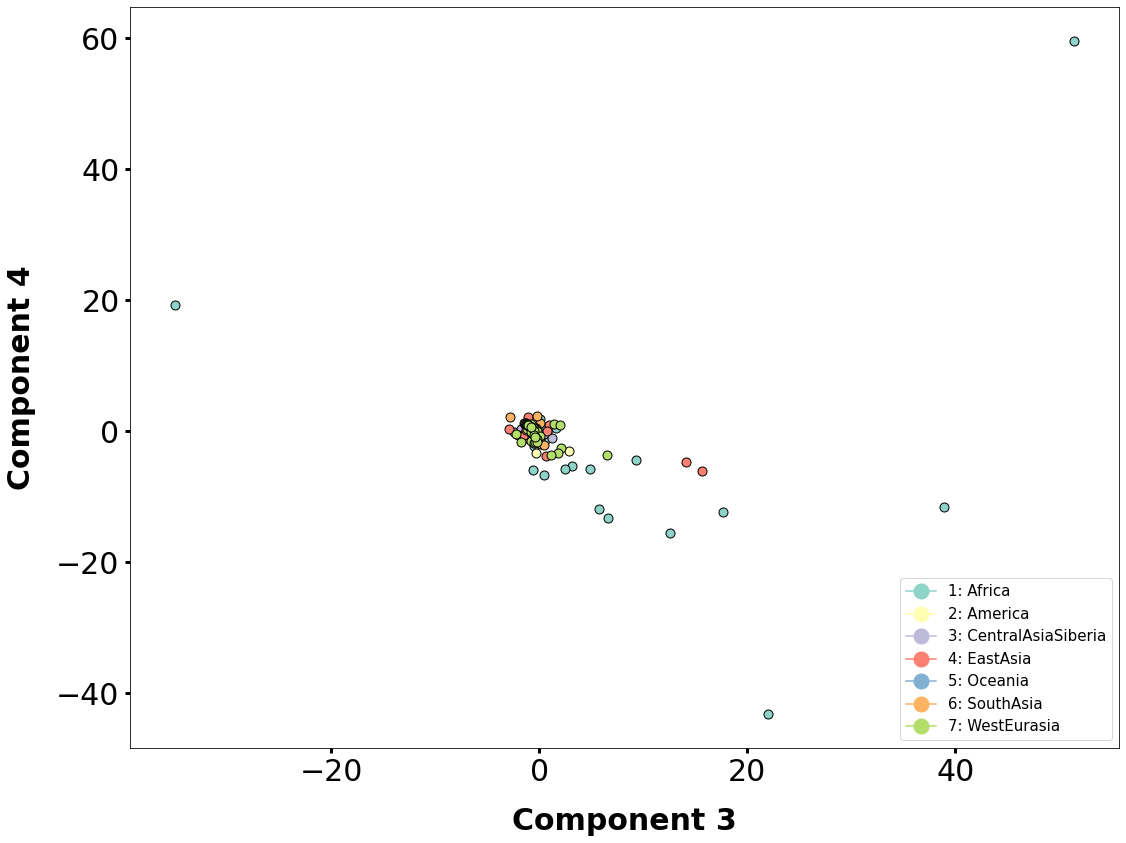

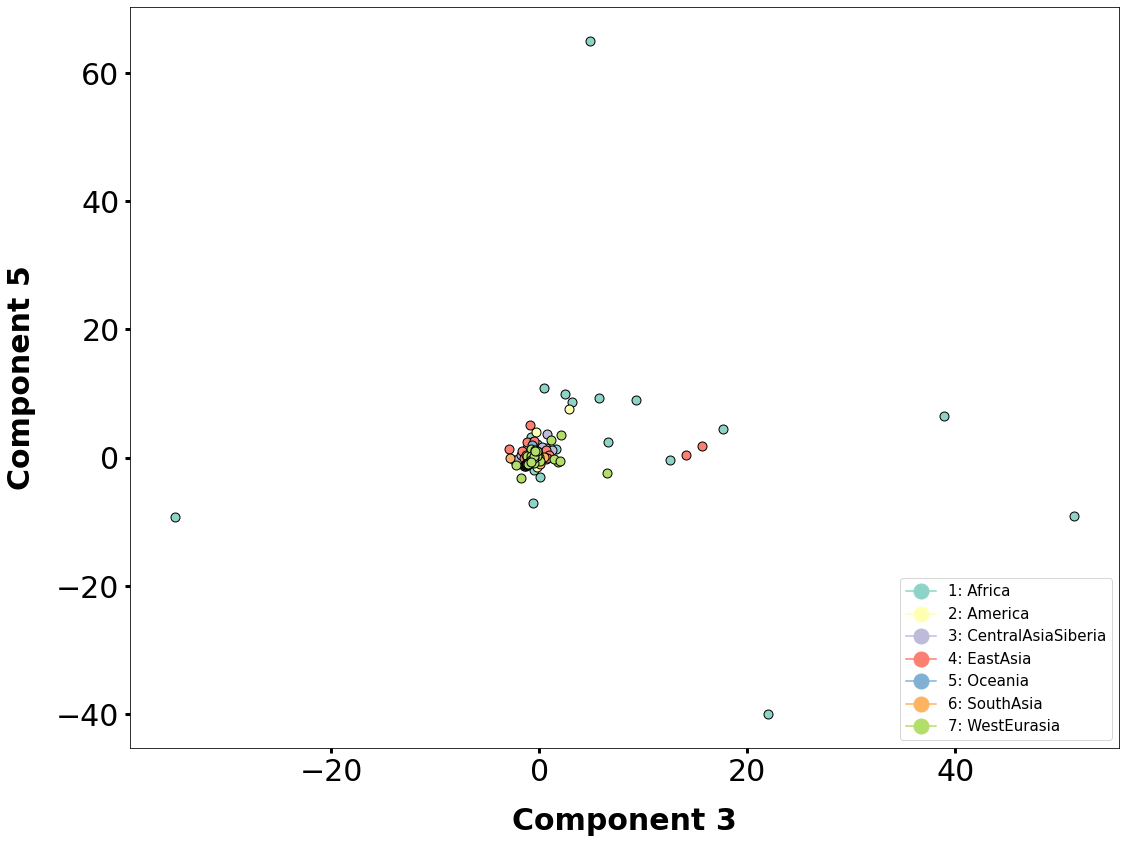

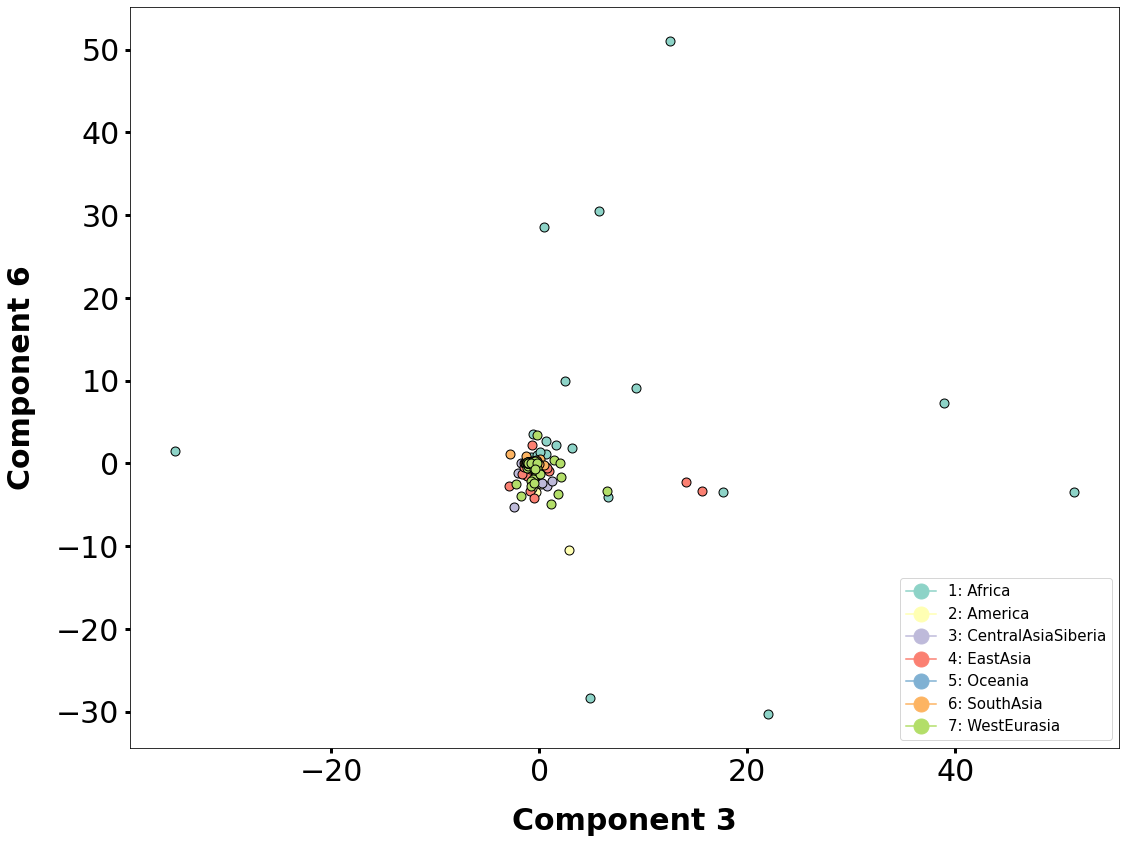

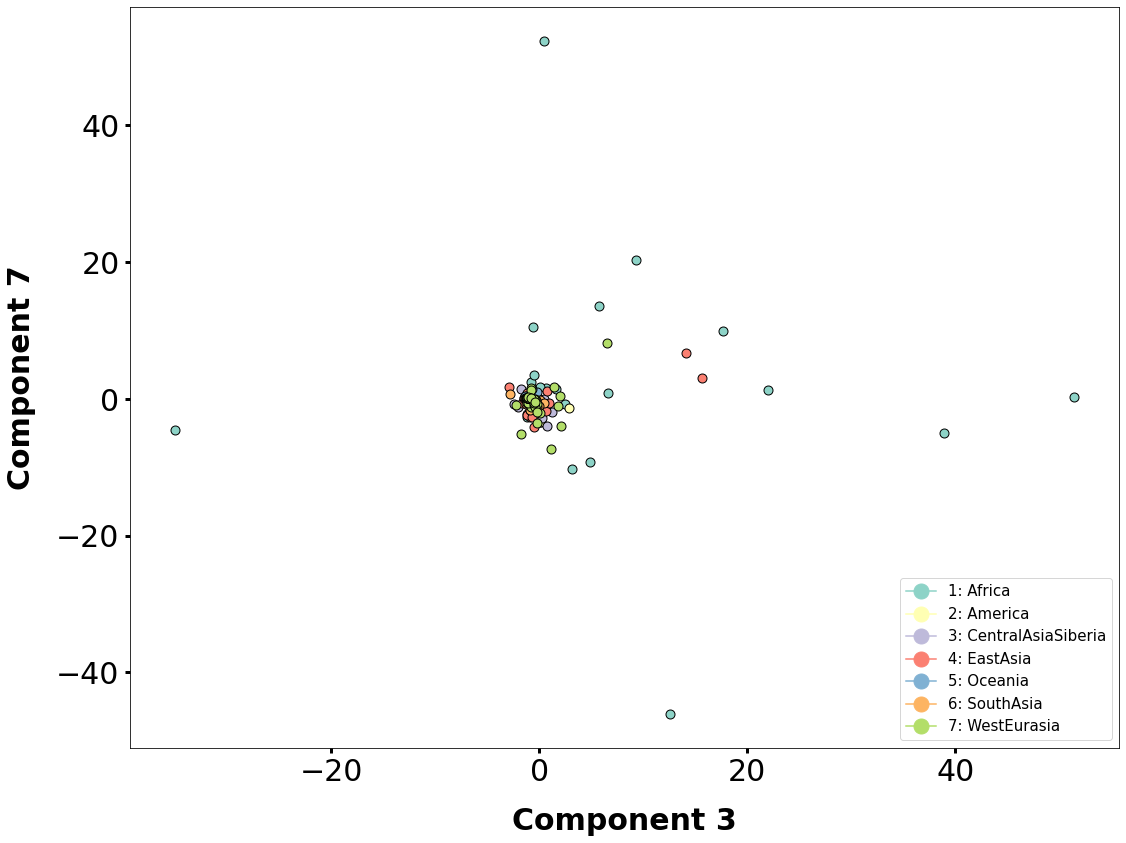

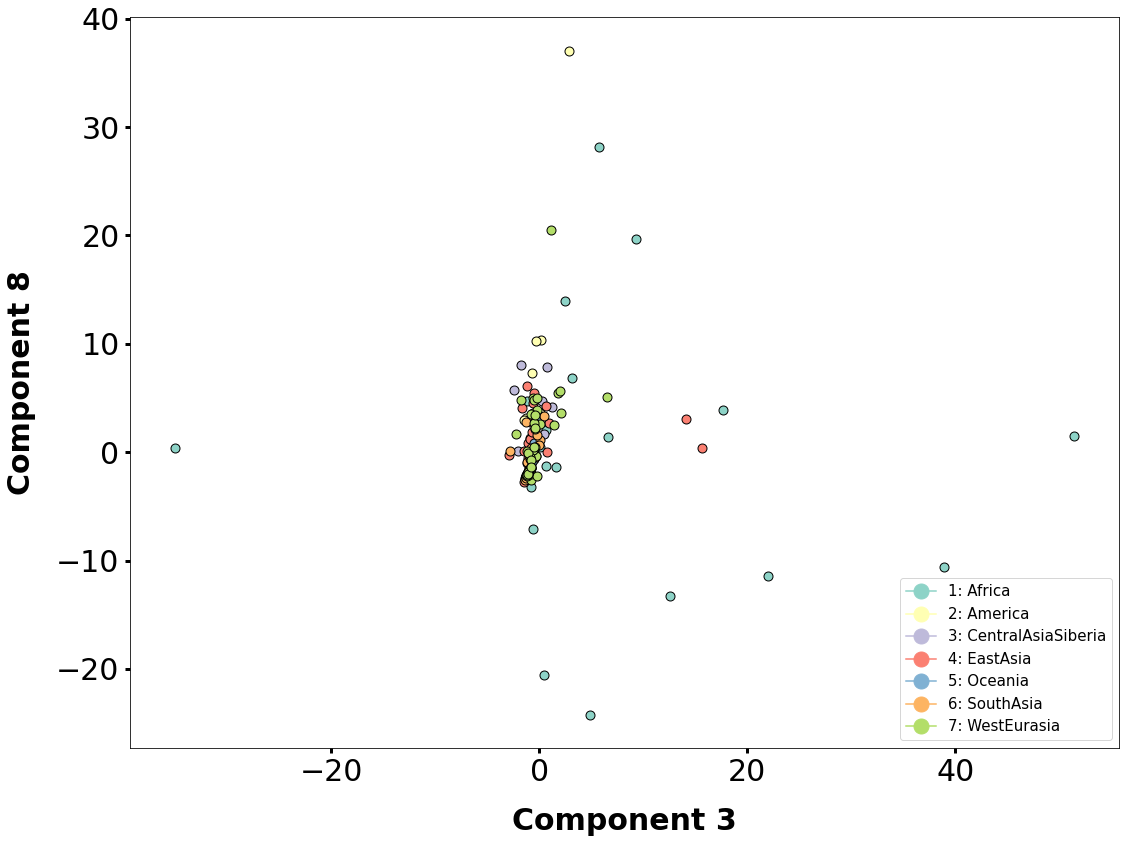

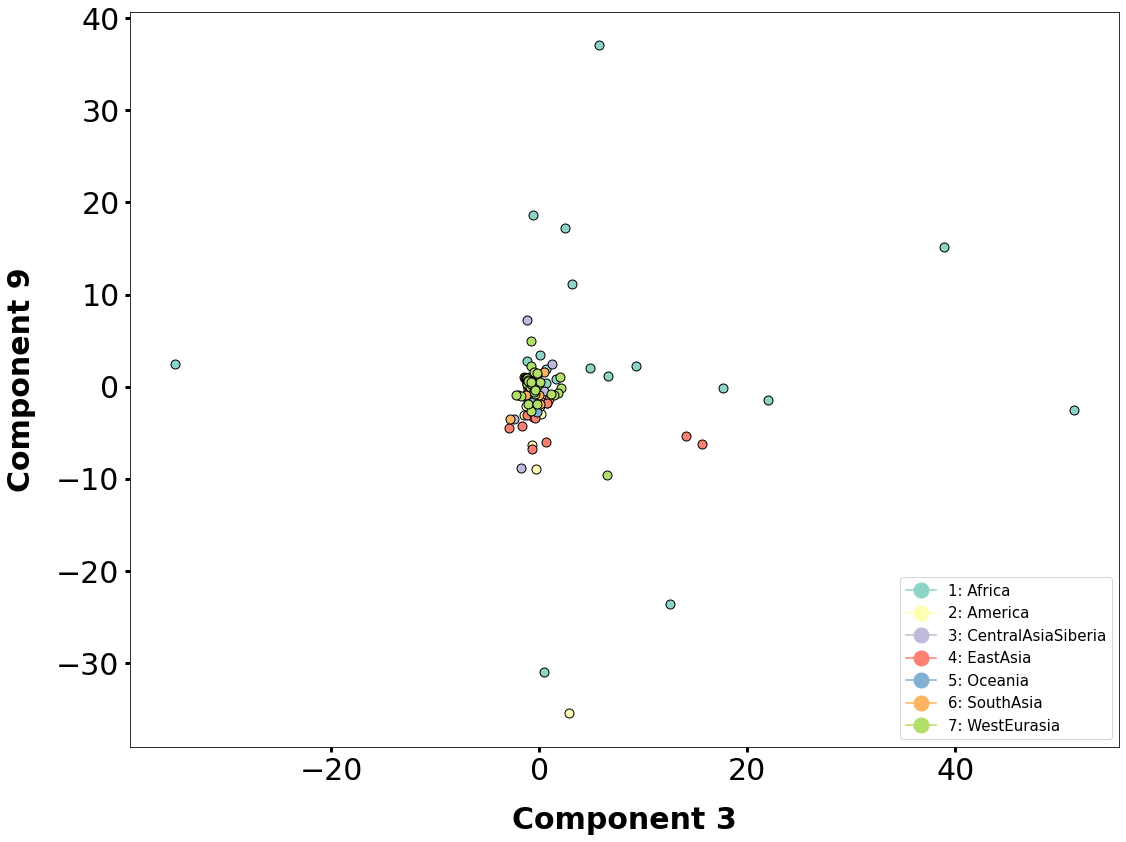

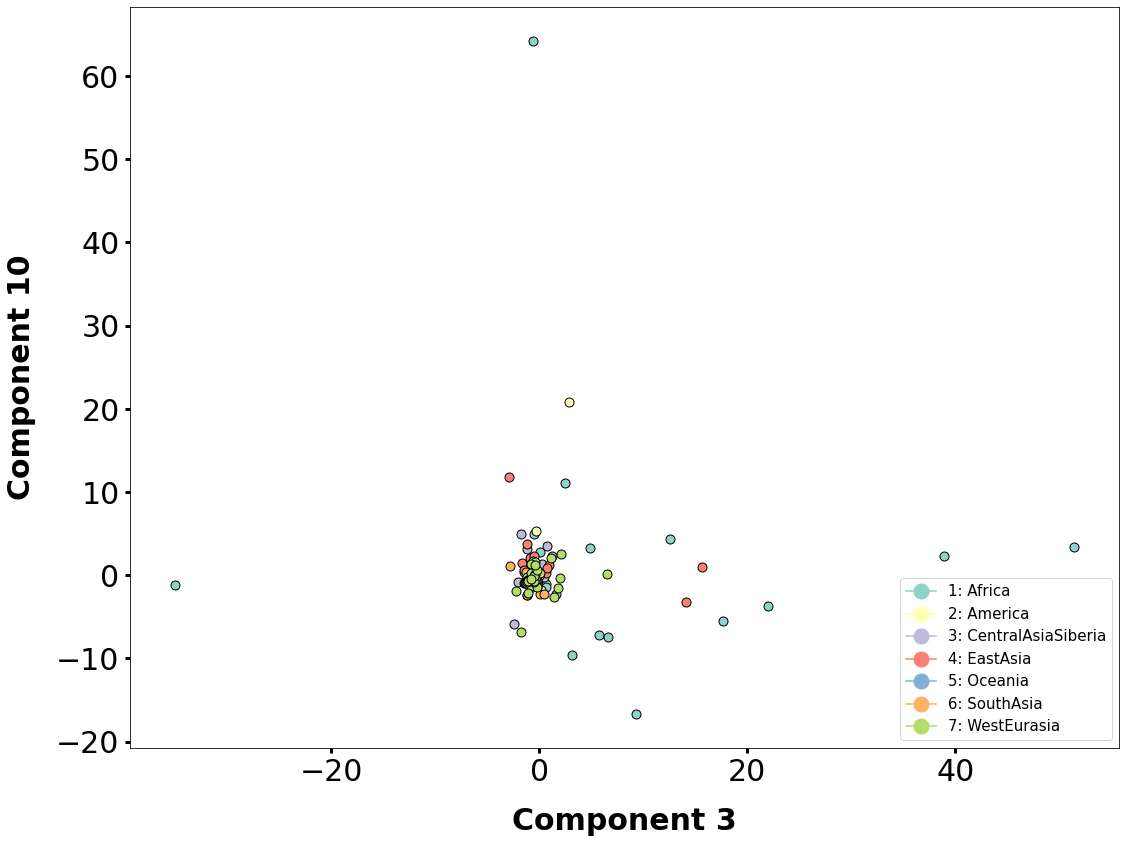

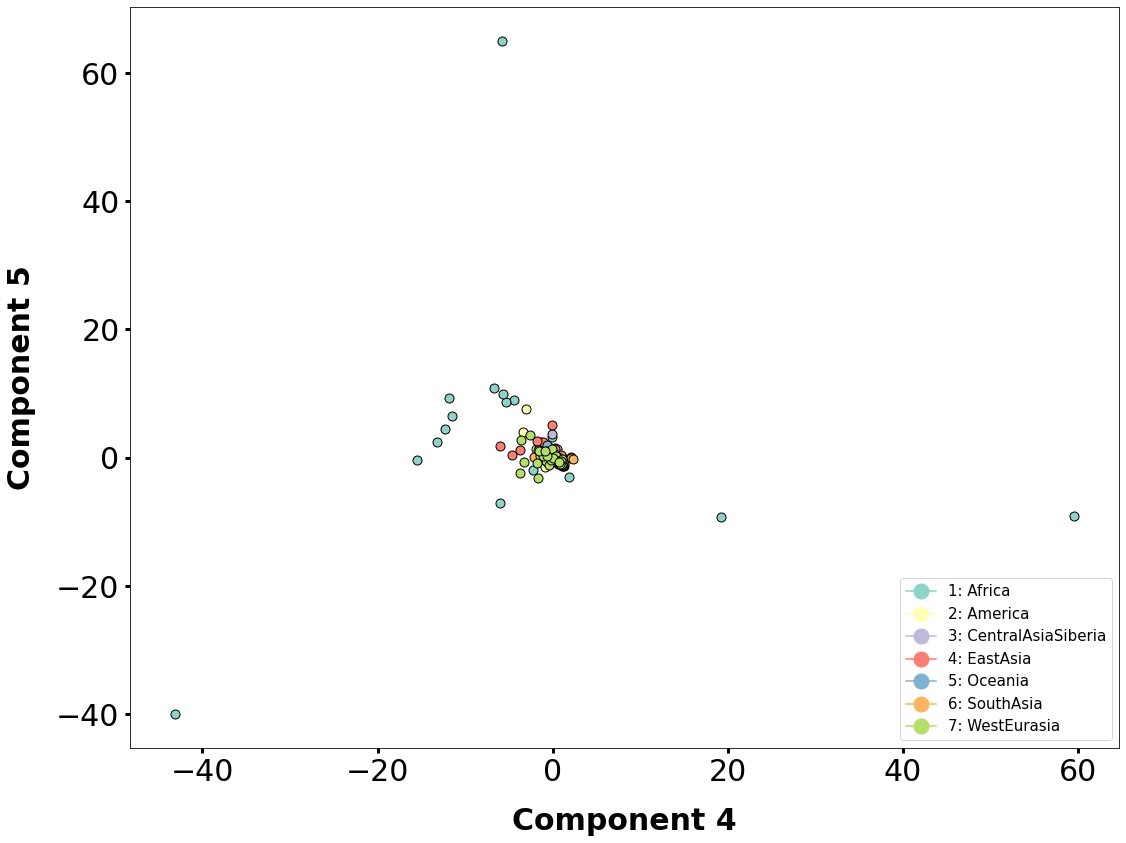

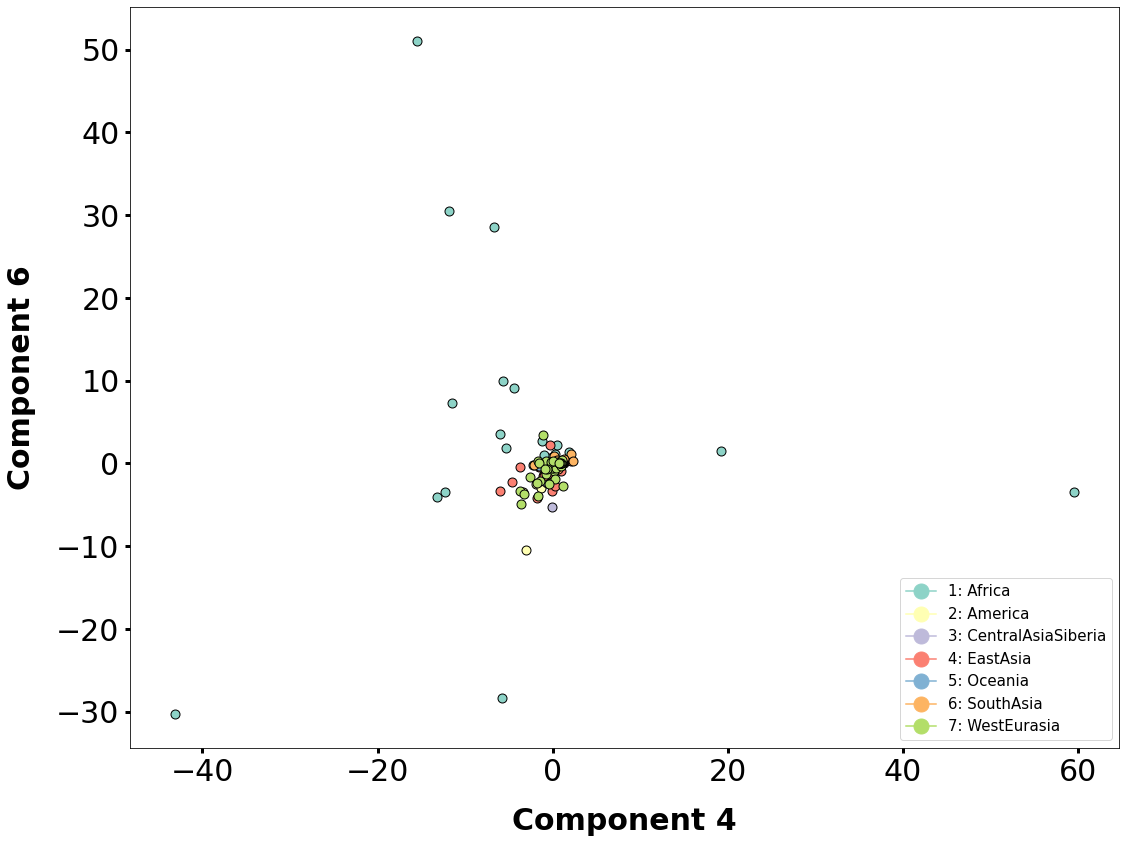

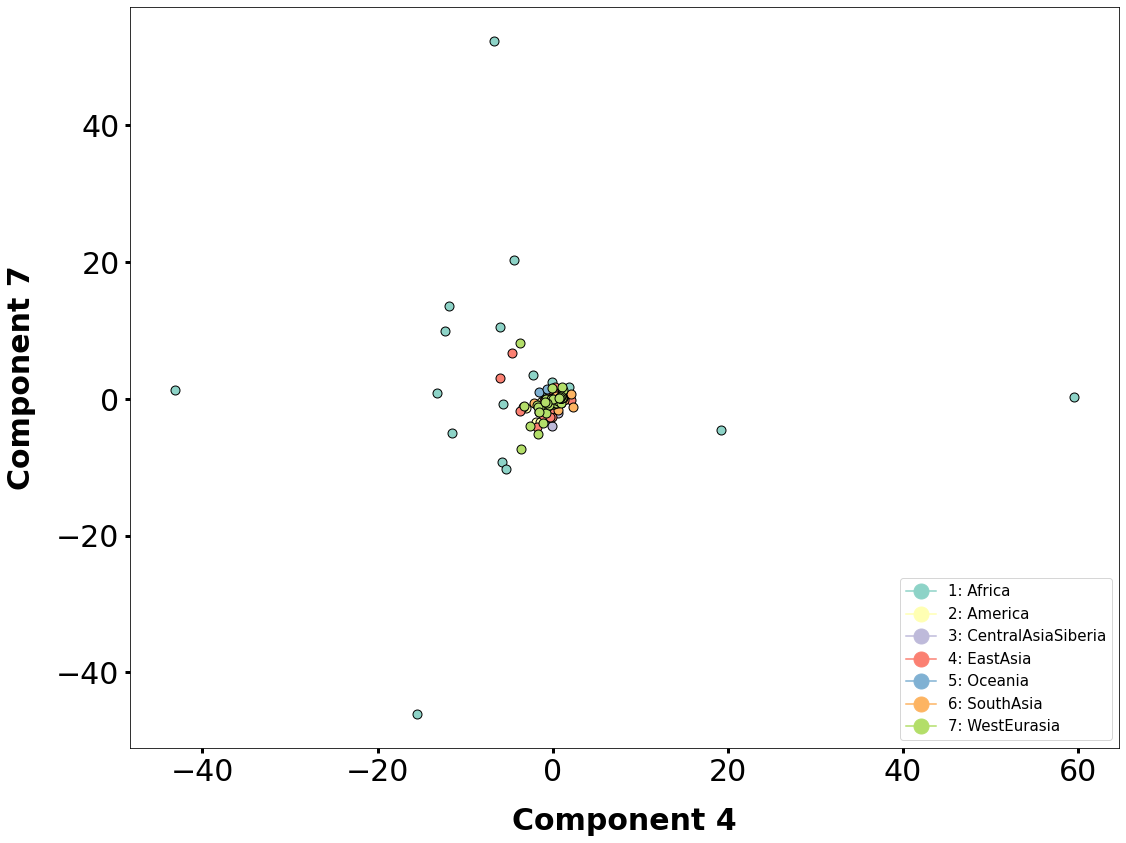

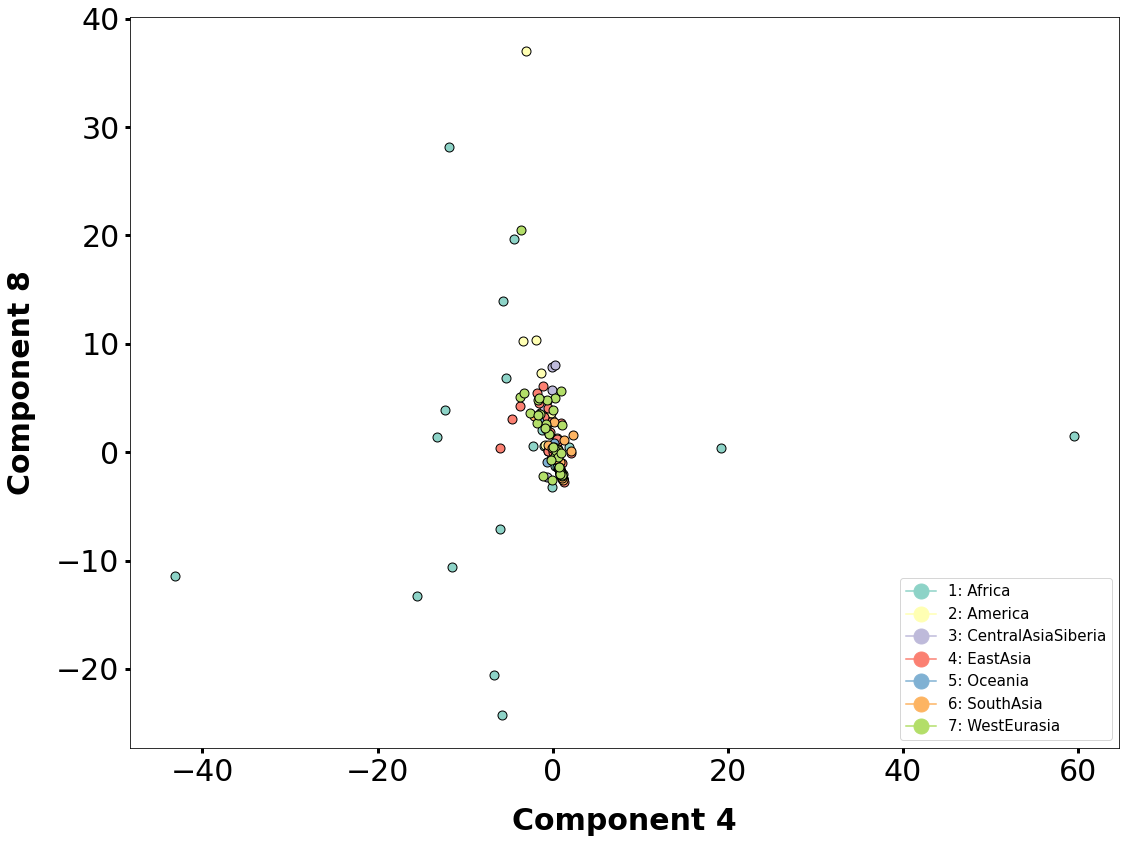

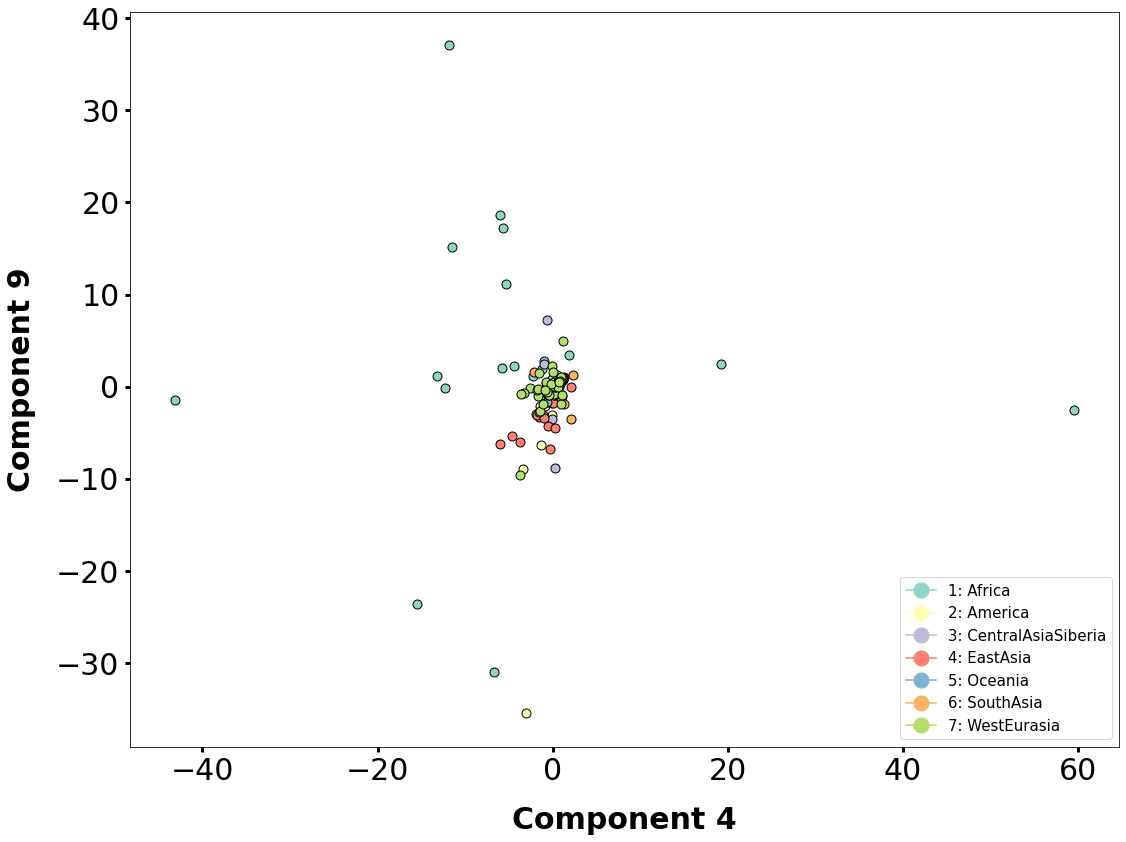

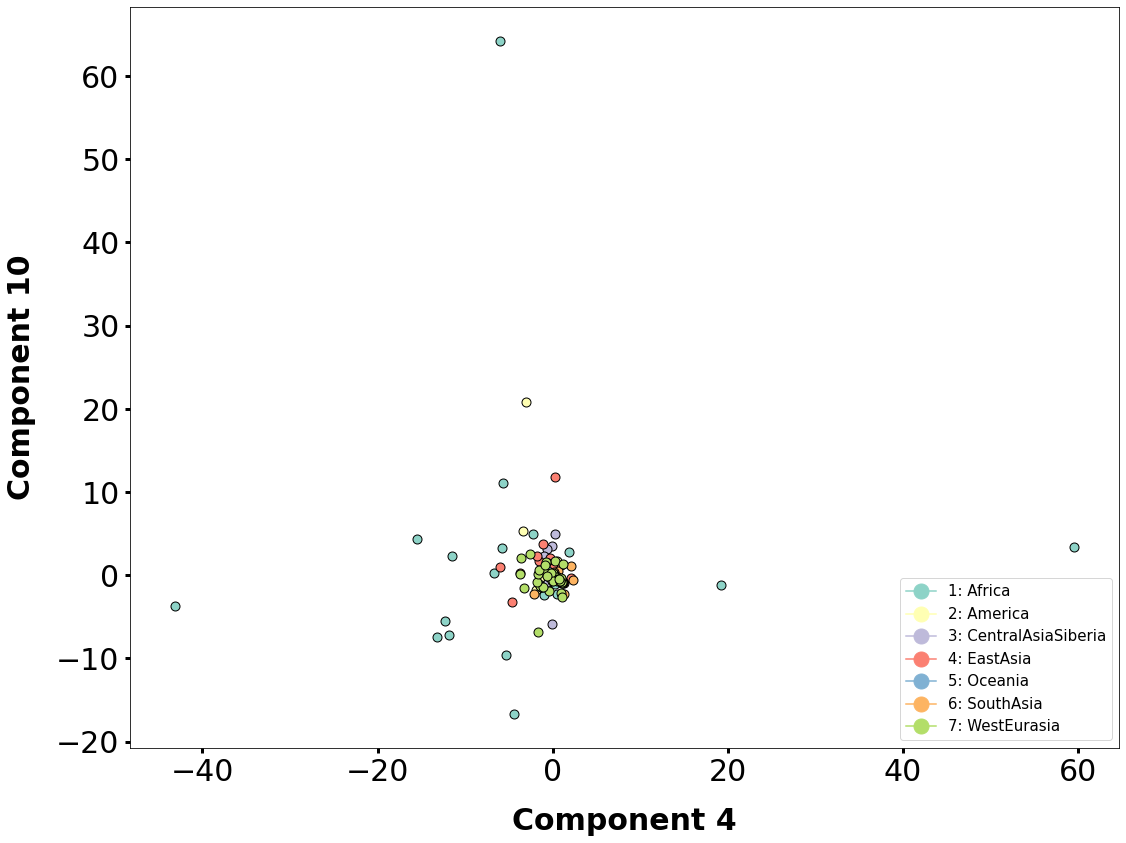

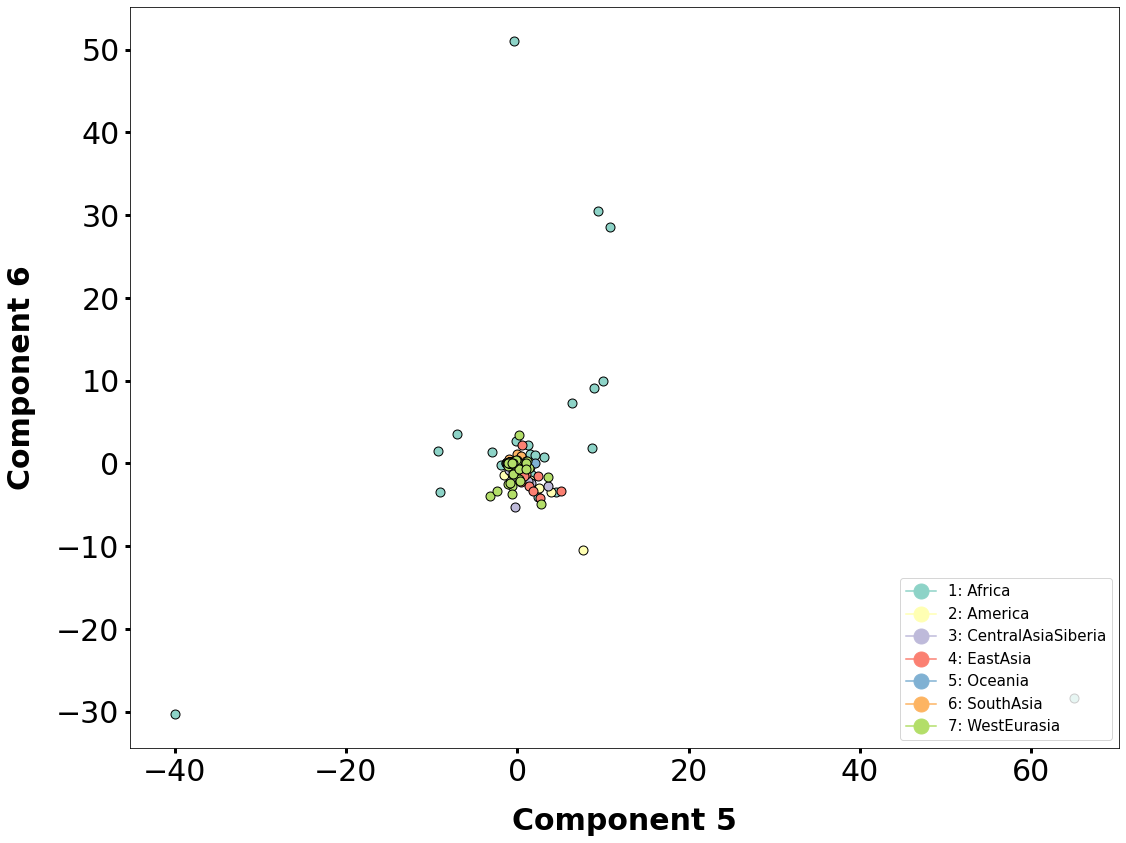

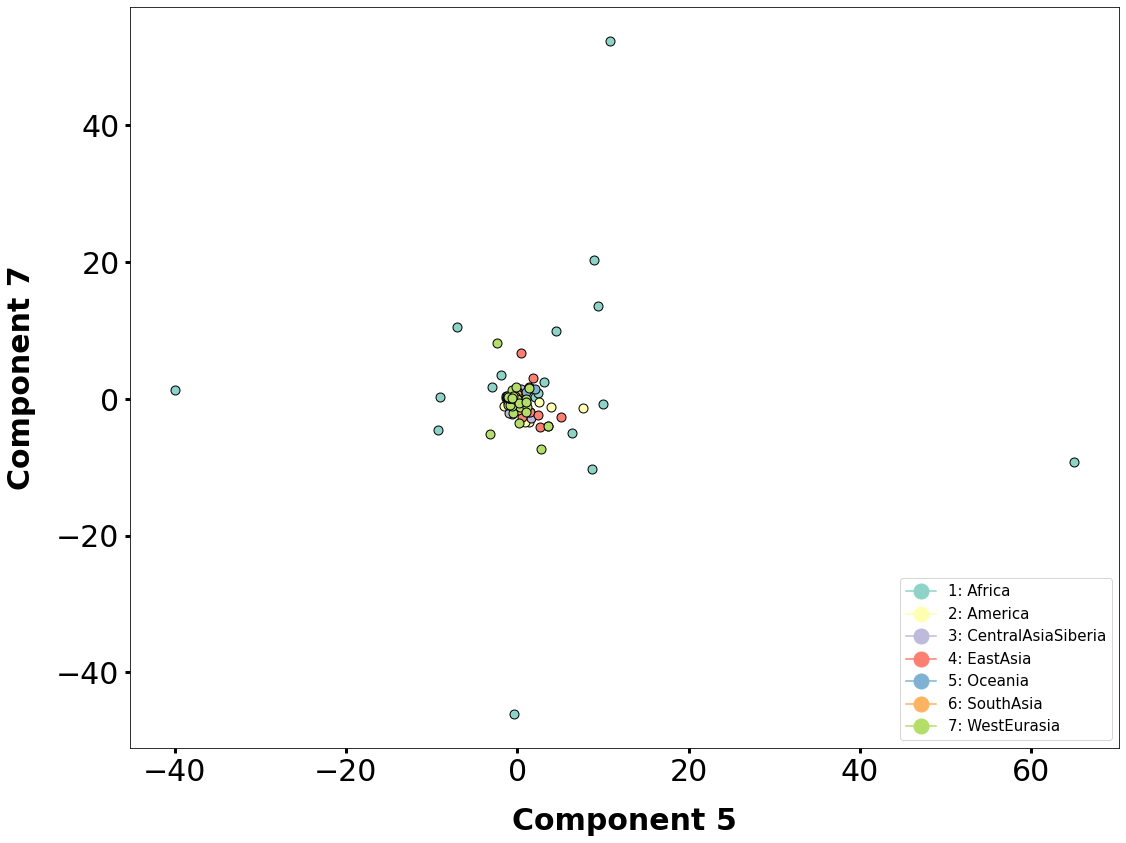

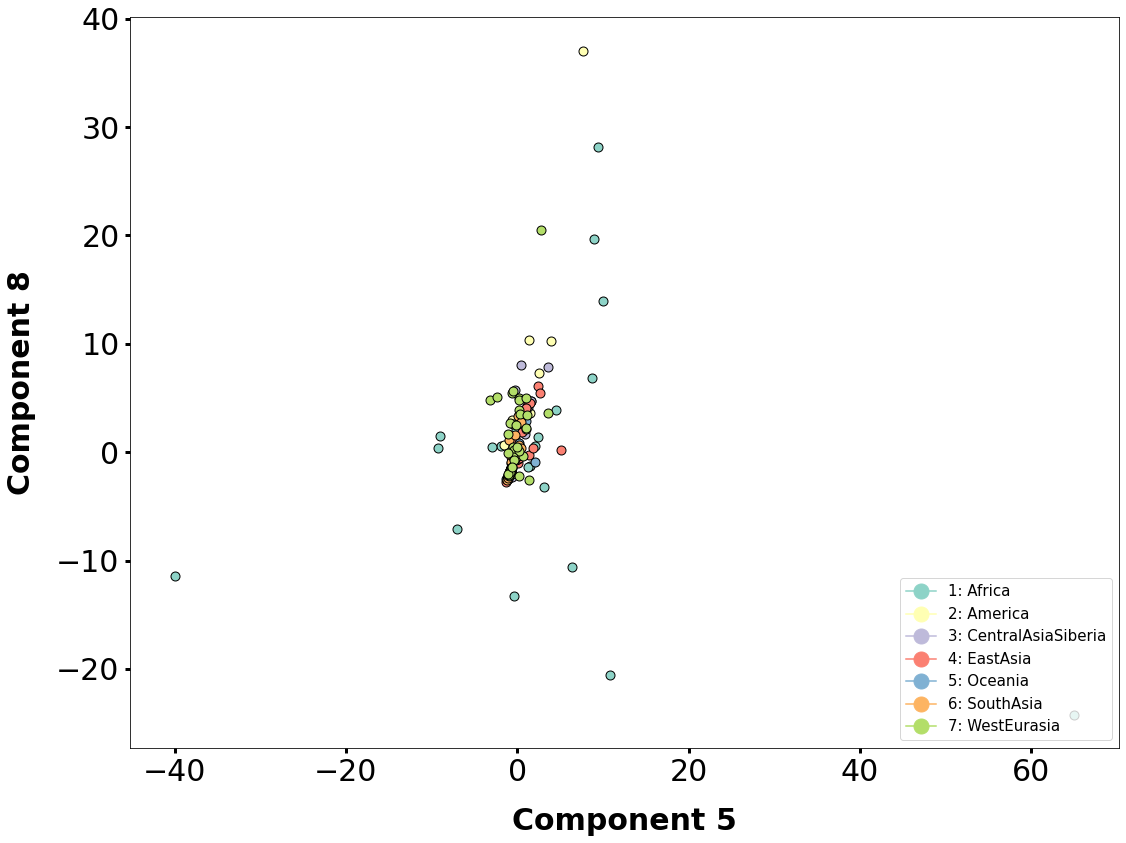

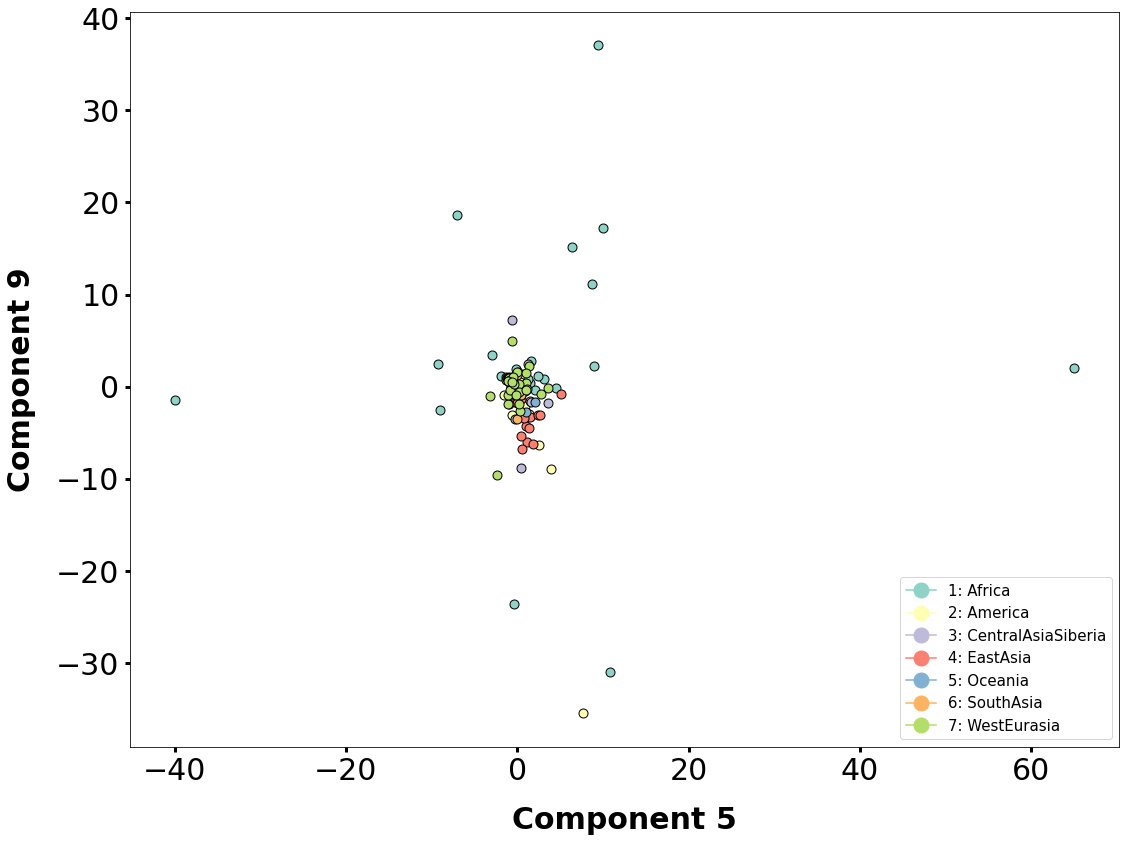

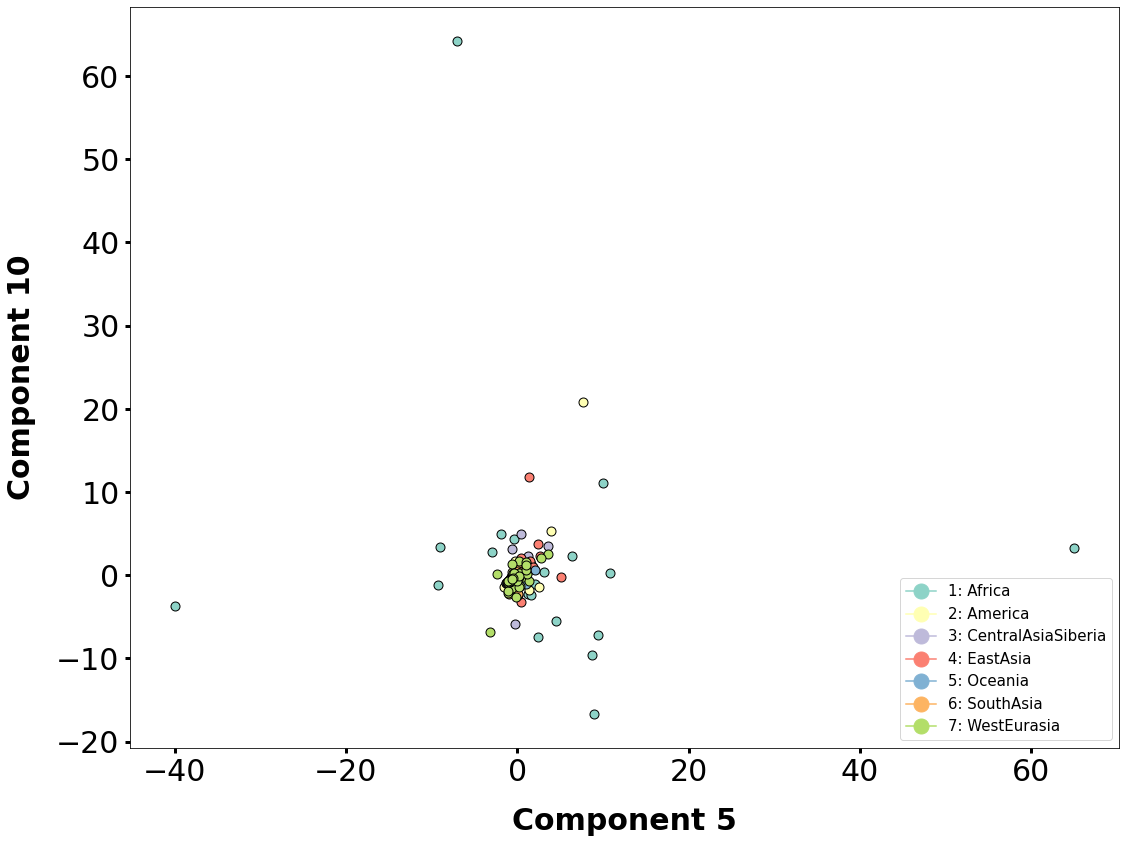

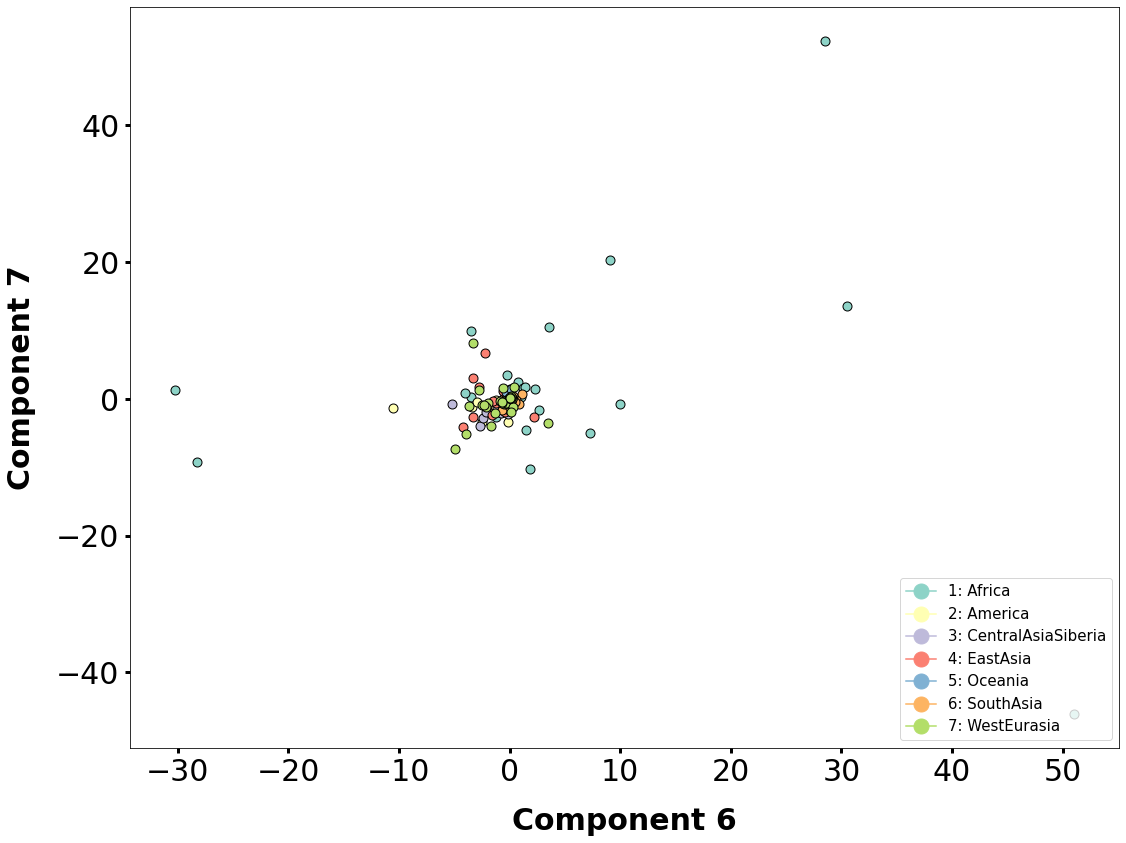

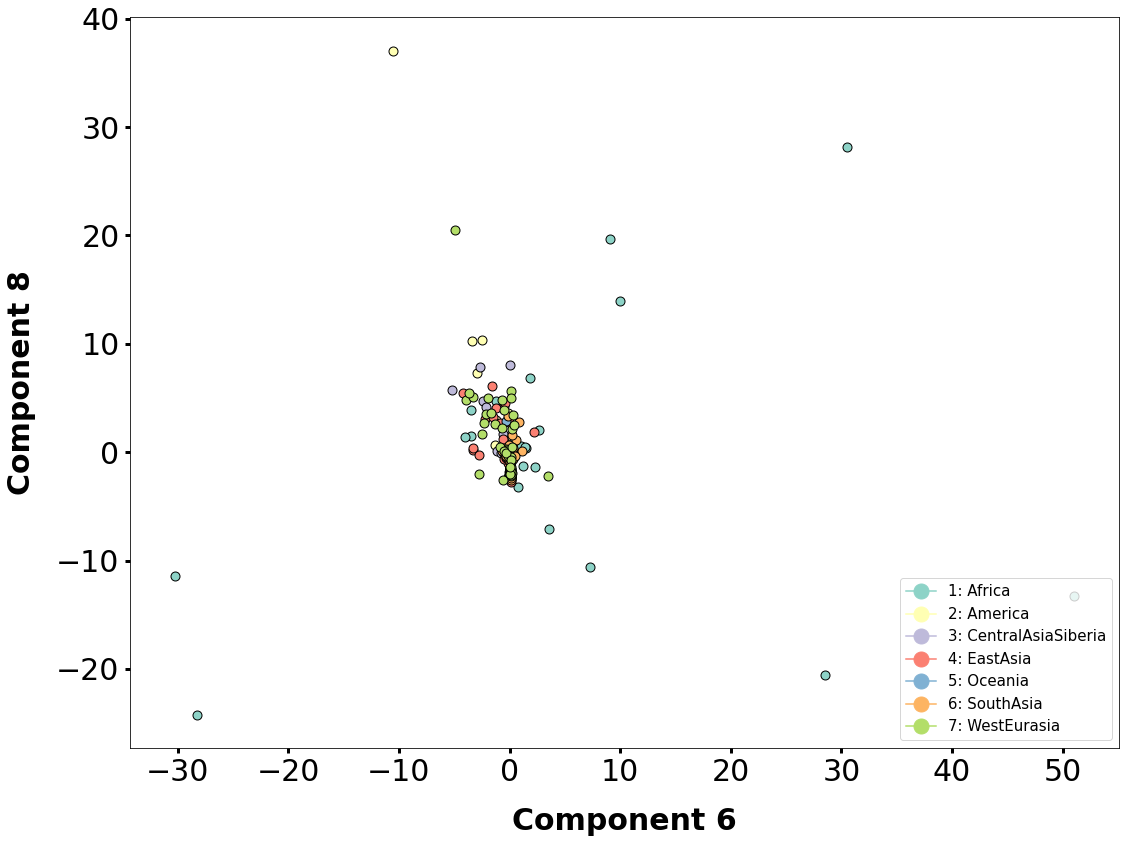

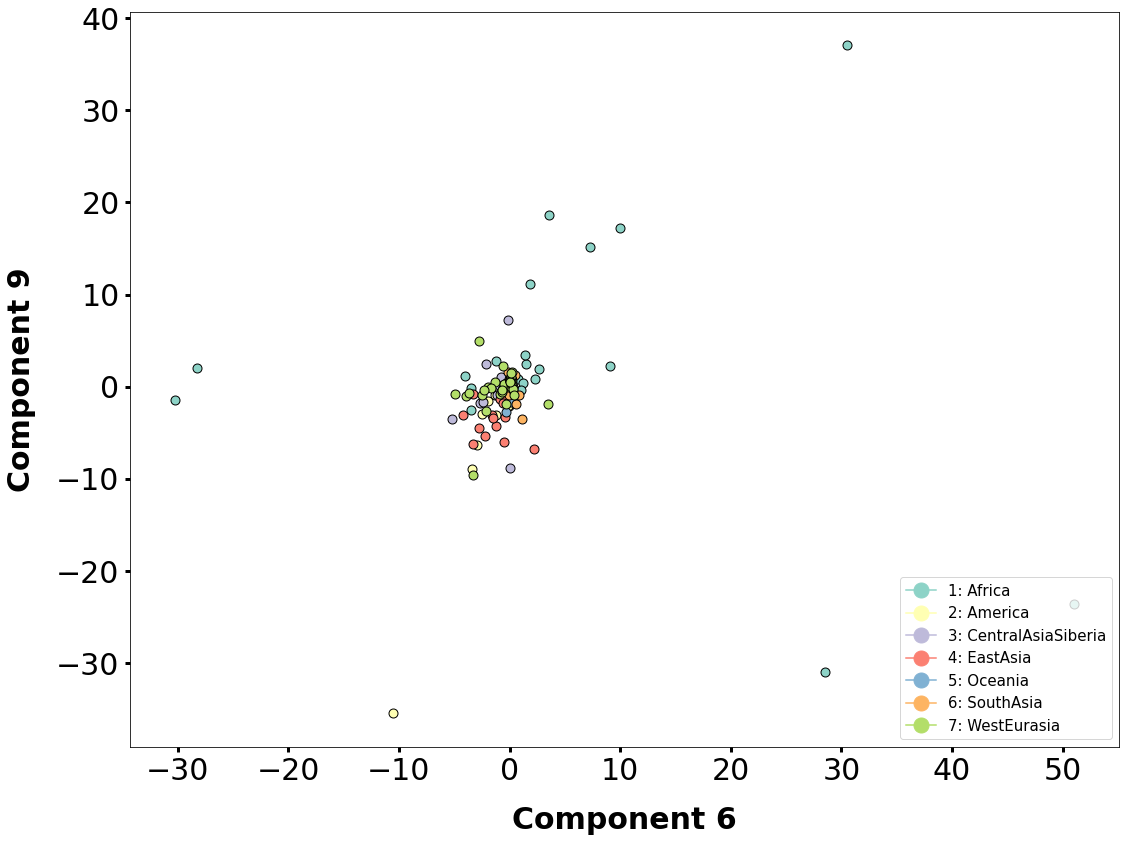

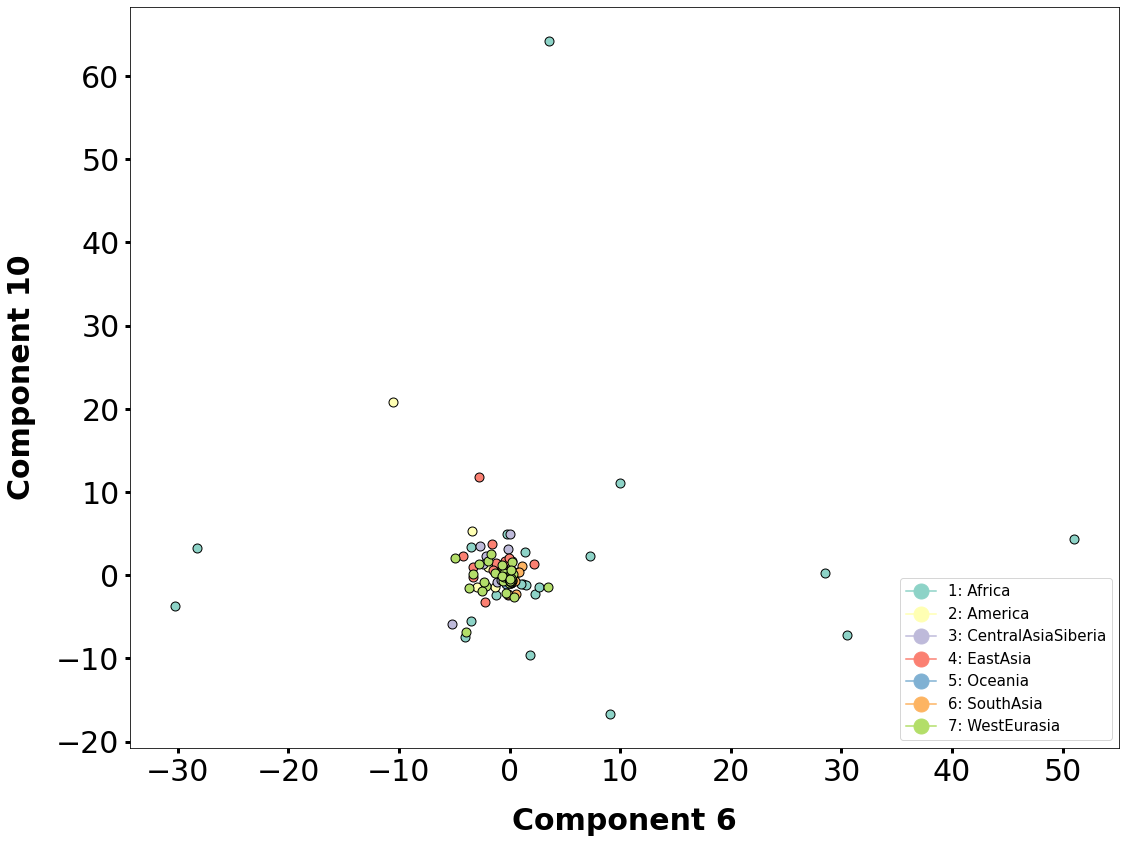

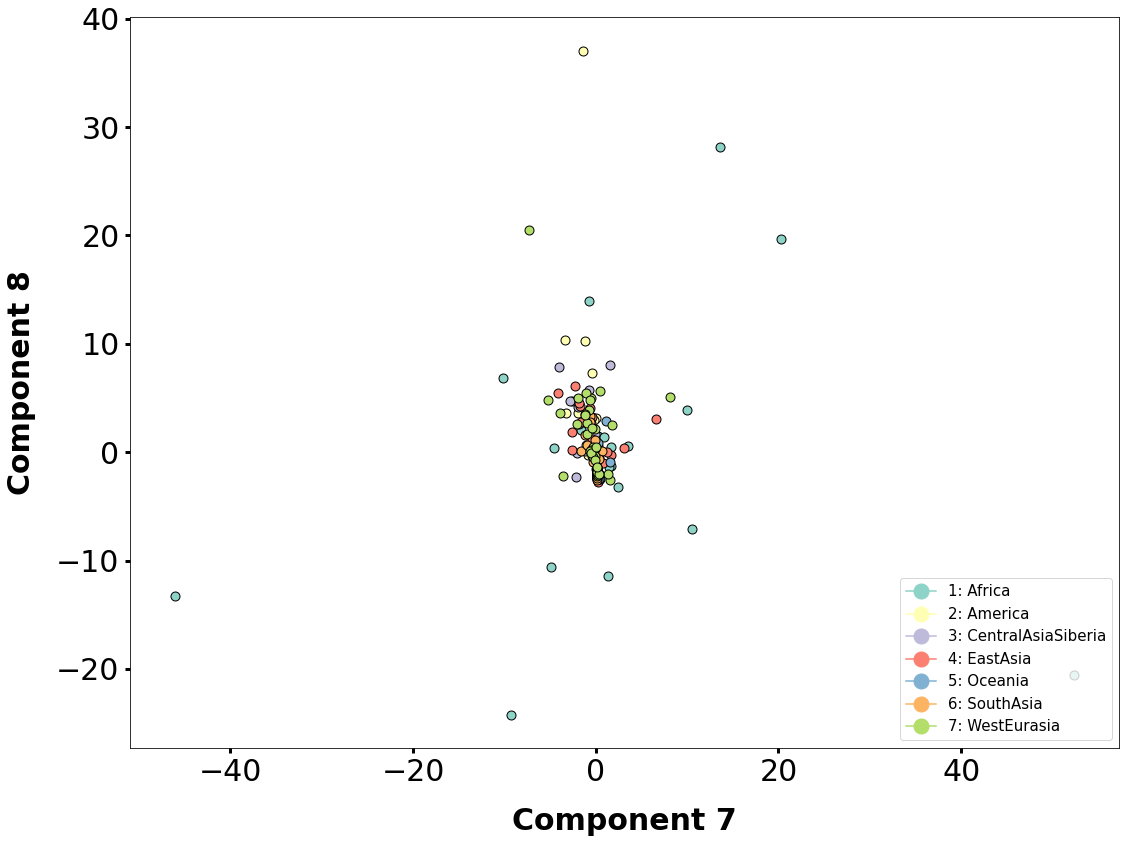

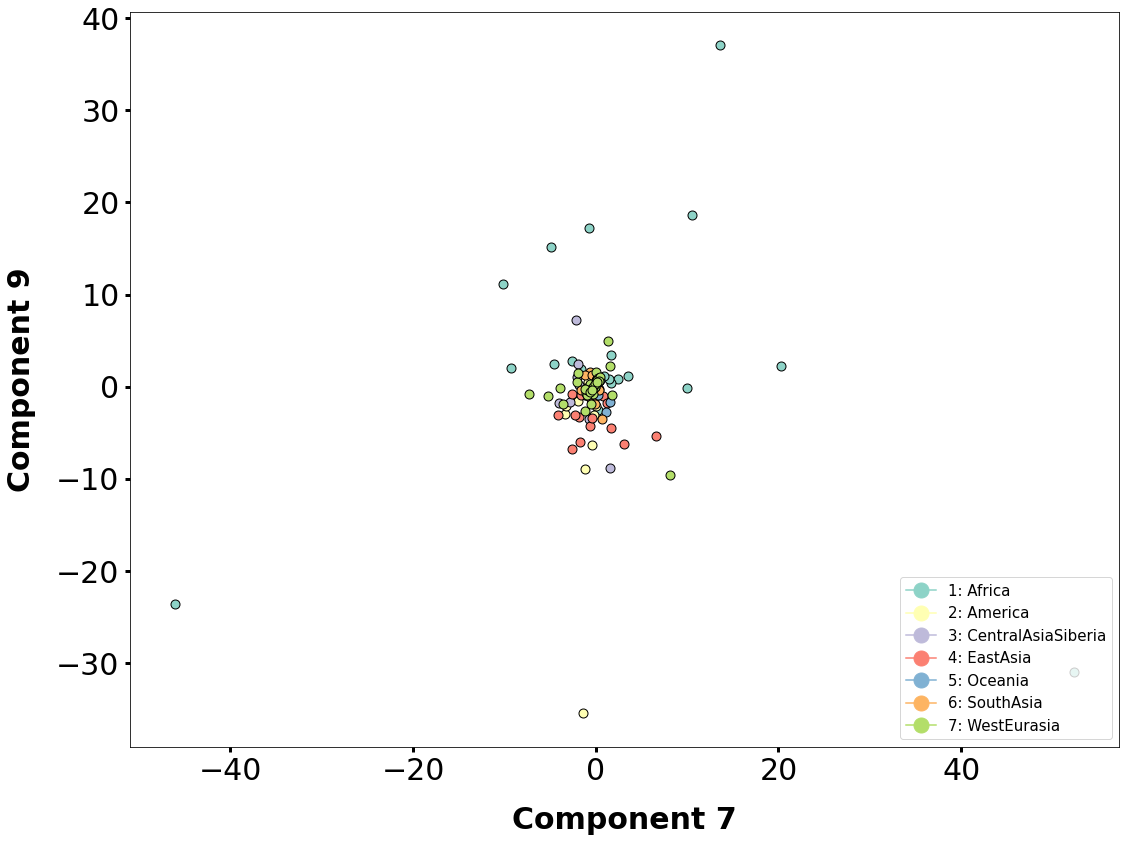

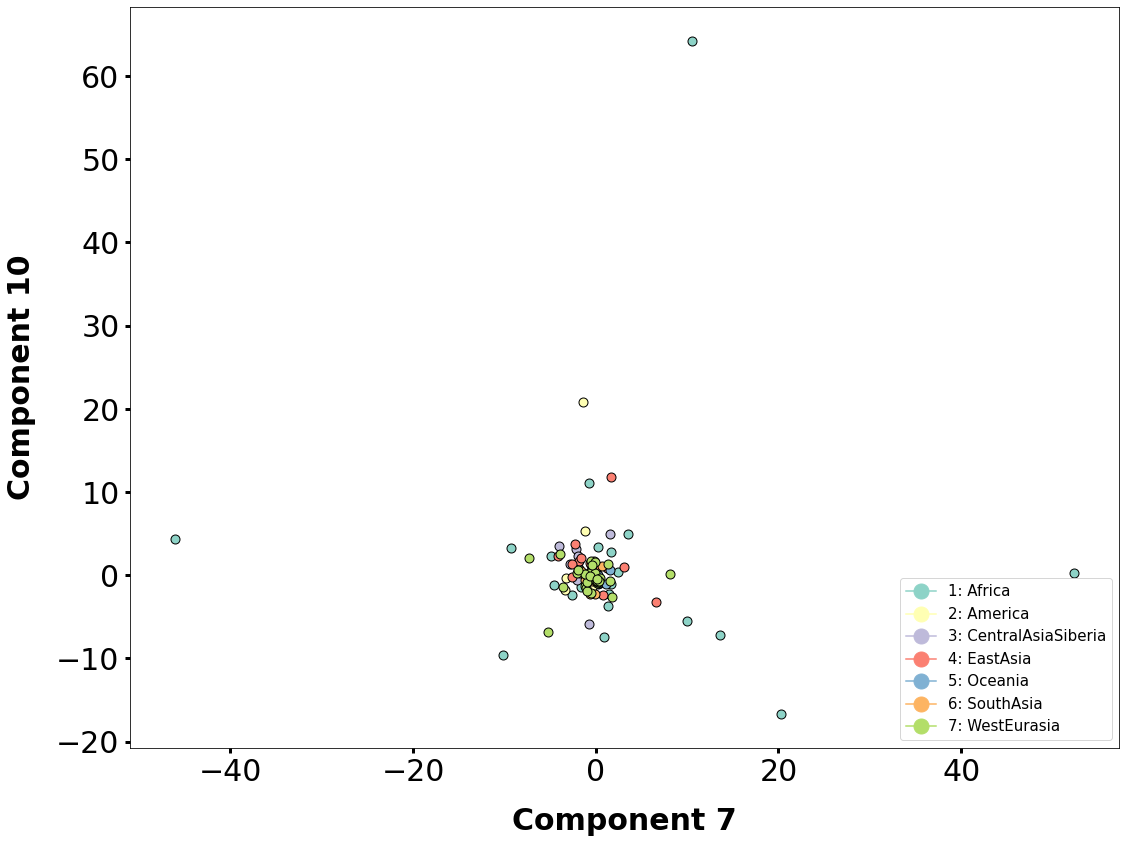

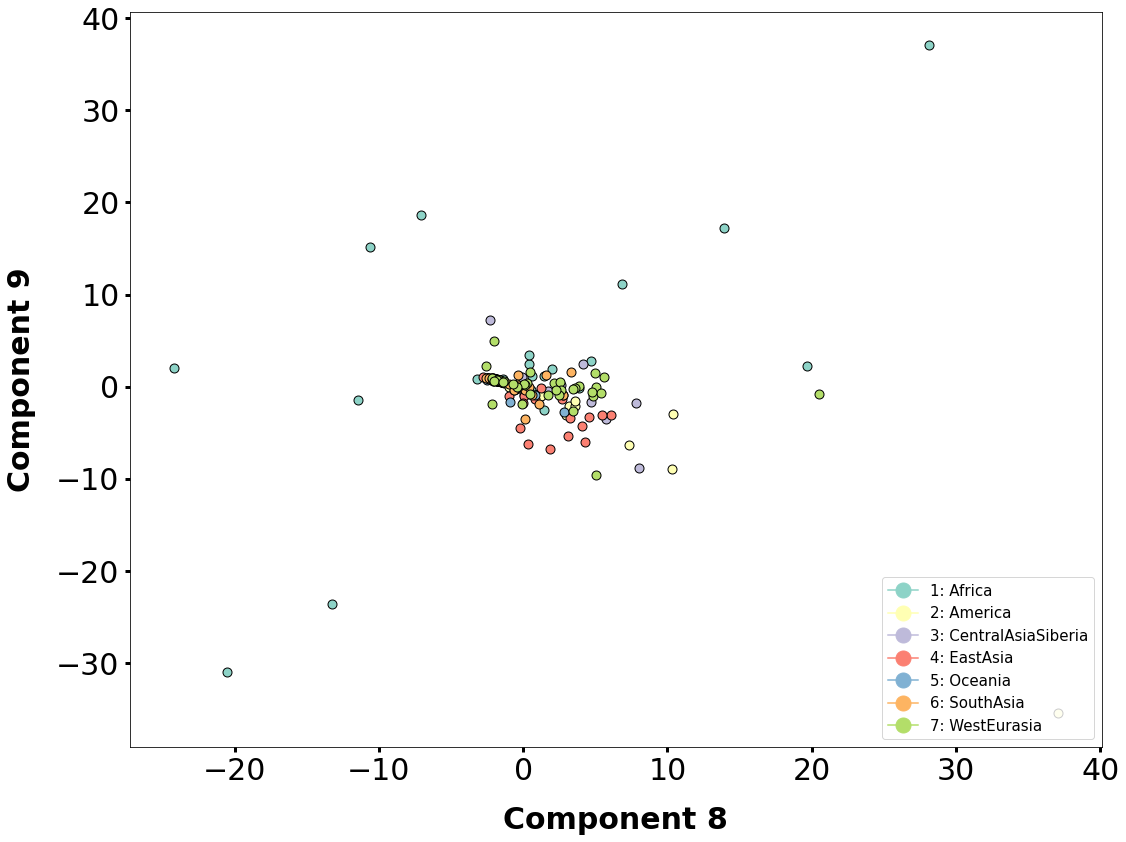

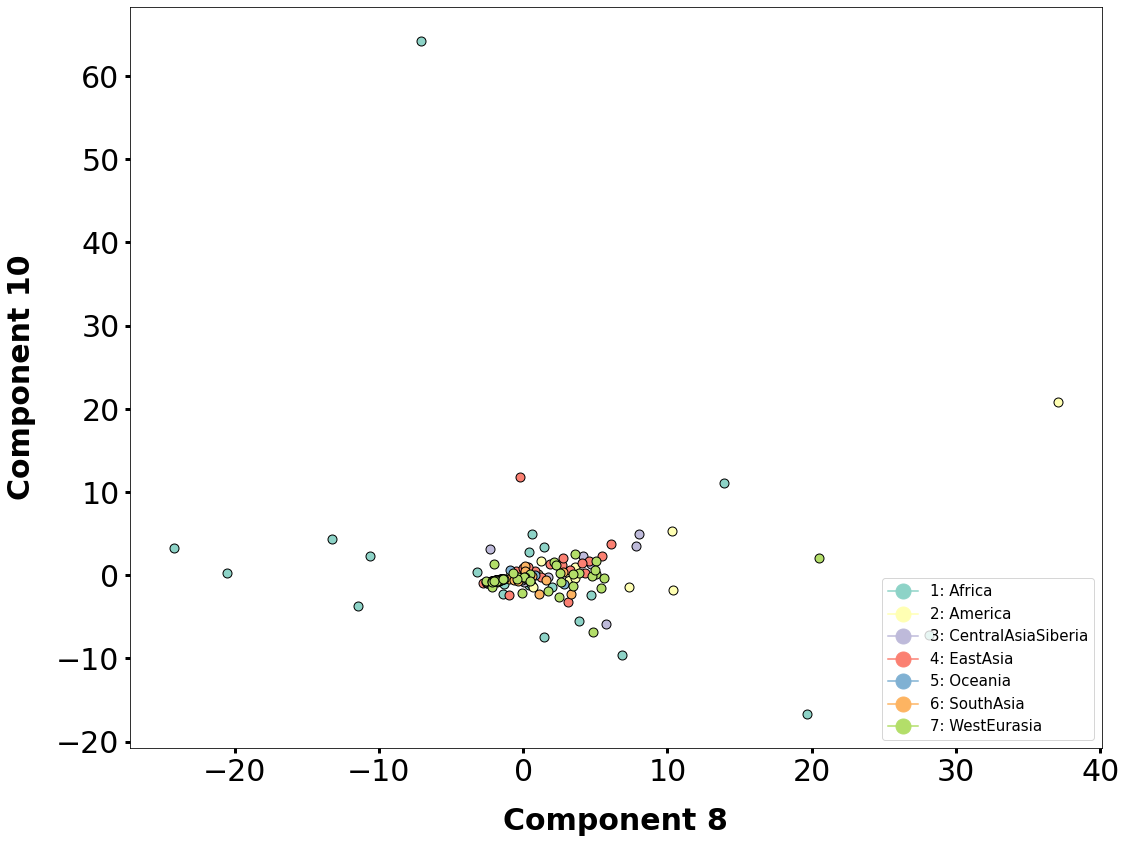

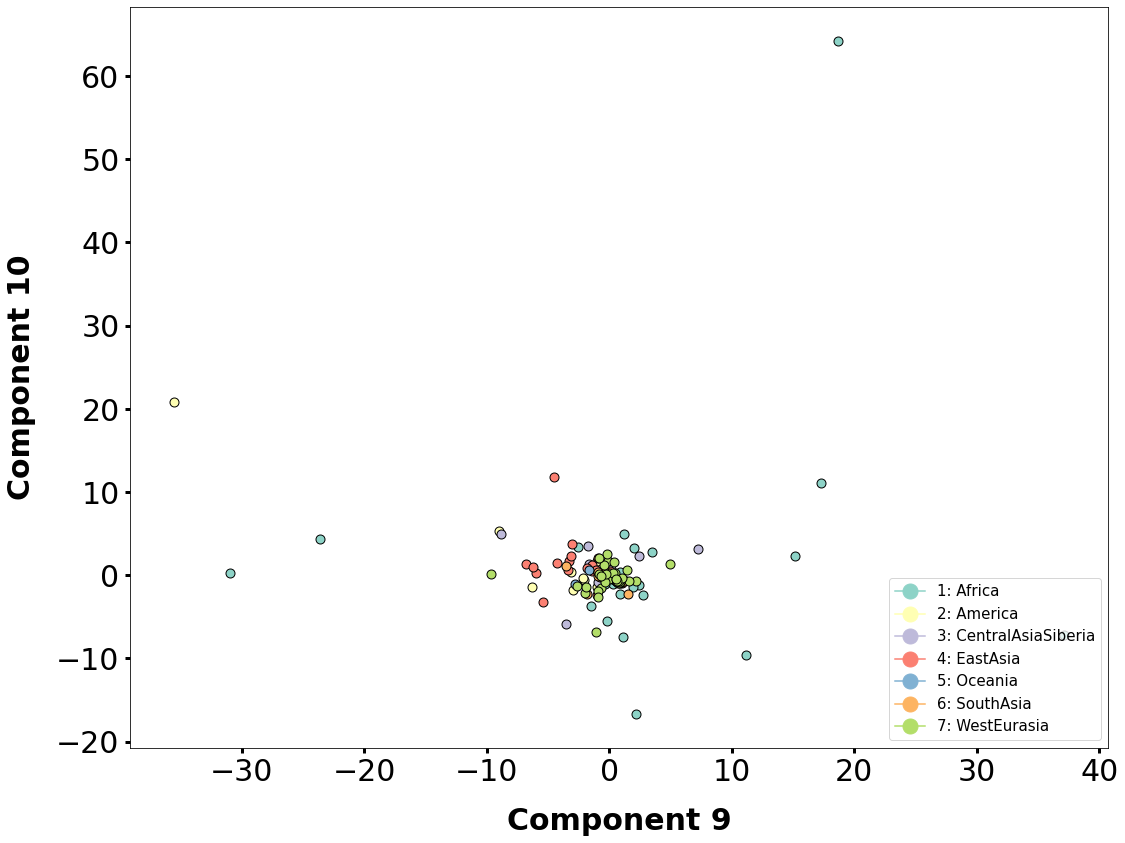

In [105]:
components = [1,2,3,4,5,6,7,8,9,10]

combinations_components = list(combinations(components,2))
for i in combinations_components:
    plot_scatter_cluster(data=df_pca, abscissa='component_'+str(i[0]), ordinate='component_'+str(i[1]), label_horizontal='Component '+ str(i[0]), label_vertical='Component '+str(i[1]), factor='10-Region', fonts=define_font_properties(), colors=define_color_properties(), legend=True)
    #print(str(i[0]))
#    plot_scatter_cluster(data=df_pca, abscissa='component_8', ordinate='component_9', label_horizontal='Component 1', label_vertical='Component 3', factor='10-Region', fonts=define_font_properties(), colors=define_color_properties(), legend=True)
    

          7-Gender 11-Country  component_1  component_2  component_3  \
10-Region                                                              
SouthAsia        M      India    -1.606023     0.836784    -2.837188   
EastAsia         F      China    -1.030335     1.012084    -0.964625   
EastAsia         F    Vietnam    -1.354669    -0.032595     0.665925   
EastAsia         F      China    -0.909308     0.873294    -0.828802   
EastAsia         M      China    -0.957770     0.902542    -1.097240   
...            ...        ...          ...          ...          ...   
America          F     Mexico    -1.041311     1.000431    -0.959776   
EastAsia         F      Japan    -1.097297    -0.093637    -0.403128   
Oceania          M        USA    -1.037309    -0.527373    -0.664437   
SouthAsia        M      Nepal    -0.954713     1.182220    -0.315659   
SouthAsia        M   Pakistan    -1.173045     1.191539    -1.149145   

           component_4  component_5  component_6  component_7  

          7-Gender 11-Country  component_1  component_2  component_3  \
10-Region                                                              
SouthAsia        M      India    -1.606023     0.836784    -2.837188   
EastAsia         F      China    -1.030335     1.012084    -0.964625   
EastAsia         F    Vietnam    -1.354669    -0.032595     0.665925   
EastAsia         F      China    -0.909308     0.873294    -0.828802   
EastAsia         M      China    -0.957770     0.902542    -1.097240   
...            ...        ...          ...          ...          ...   
America          F     Mexico    -1.041311     1.000431    -0.959776   
EastAsia         F      Japan    -1.097297    -0.093637    -0.403128   
Oceania          M        USA    -1.037309    -0.527373    -0.664437   
SouthAsia        M      Nepal    -0.954713     1.182220    -0.315659   
SouthAsia        M   Pakistan    -1.173045     1.191539    -1.149145   

           component_4  component_5  component_6  component_7  

Count of groups by factor: 7
          7-Gender 11-Country  component_1  component_2  component_3  \
10-Region                                                              
SouthAsia        M      India    -1.606023     0.836784    -2.837188   
EastAsia         F      China    -1.030335     1.012084    -0.964625   
EastAsia         F    Vietnam    -1.354669    -0.032595     0.665925   
EastAsia         F      China    -0.909308     0.873294    -0.828802   
EastAsia         M      China    -0.957770     0.902542    -1.097240   
...            ...        ...          ...          ...          ...   
America          F     Mexico    -1.041311     1.000431    -0.959776   
EastAsia         F      Japan    -1.097297    -0.093637    -0.403128   
Oceania          M        USA    -1.037309    -0.527373    -0.664437   
SouthAsia        M      Nepal    -0.954713     1.182220    -0.315659   
SouthAsia        M   Pakistan    -1.173045     1.191539    -1.149145   

           component_4  component_

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


          7-Gender 11-Country  component_1  component_2  component_3  \
10-Region                                                              
SouthAsia        M      India    -1.606023     0.836784    -2.837188   
EastAsia         F      China    -1.030335     1.012084    -0.964625   
EastAsia         F    Vietnam    -1.354669    -0.032595     0.665925   
EastAsia         F      China    -0.909308     0.873294    -0.828802   
EastAsia         M      China    -0.957770     0.902542    -1.097240   
...            ...        ...          ...          ...          ...   
America          F     Mexico    -1.041311     1.000431    -0.959776   
EastAsia         F      Japan    -1.097297    -0.093637    -0.403128   
Oceania          M        USA    -1.037309    -0.527373    -0.664437   
SouthAsia        M      Nepal    -0.954713     1.182220    -0.315659   
SouthAsia        M   Pakistan    -1.173045     1.191539    -1.149145   

           component_4  component_5  component_6  component_7  

          7-Gender 11-Country  component_1  component_2  component_3  \
10-Region                                                              
SouthAsia        M      India    -1.606023     0.836784    -2.837188   
EastAsia         F      China    -1.030335     1.012084    -0.964625   
EastAsia         F    Vietnam    -1.354669    -0.032595     0.665925   
EastAsia         F      China    -0.909308     0.873294    -0.828802   
EastAsia         M      China    -0.957770     0.902542    -1.097240   
...            ...        ...          ...          ...          ...   
America          F     Mexico    -1.041311     1.000431    -0.959776   
EastAsia         F      Japan    -1.097297    -0.093637    -0.403128   
Oceania          M        USA    -1.037309    -0.527373    -0.664437   
SouthAsia        M      Nepal    -0.954713     1.182220    -0.315659   
SouthAsia        M   Pakistan    -1.173045     1.191539    -1.149145   

           component_4  component_5  component_6  component_7  

          7-Gender 11-Country  component_1  component_2  component_3  \
10-Region                                                              
SouthAsia        M      India    -1.606023     0.836784    -2.837188   
EastAsia         F      China    -1.030335     1.012084    -0.964625   
EastAsia         F    Vietnam    -1.354669    -0.032595     0.665925   
EastAsia         F      China    -0.909308     0.873294    -0.828802   
EastAsia         M      China    -0.957770     0.902542    -1.097240   
...            ...        ...          ...          ...          ...   
America          F     Mexico    -1.041311     1.000431    -0.959776   
EastAsia         F      Japan    -1.097297    -0.093637    -0.403128   
Oceania          M        USA    -1.037309    -0.527373    -0.664437   
SouthAsia        M      Nepal    -0.954713     1.182220    -0.315659   
SouthAsia        M   Pakistan    -1.173045     1.191539    -1.149145   

           component_4  component_5  component_6  component_7  

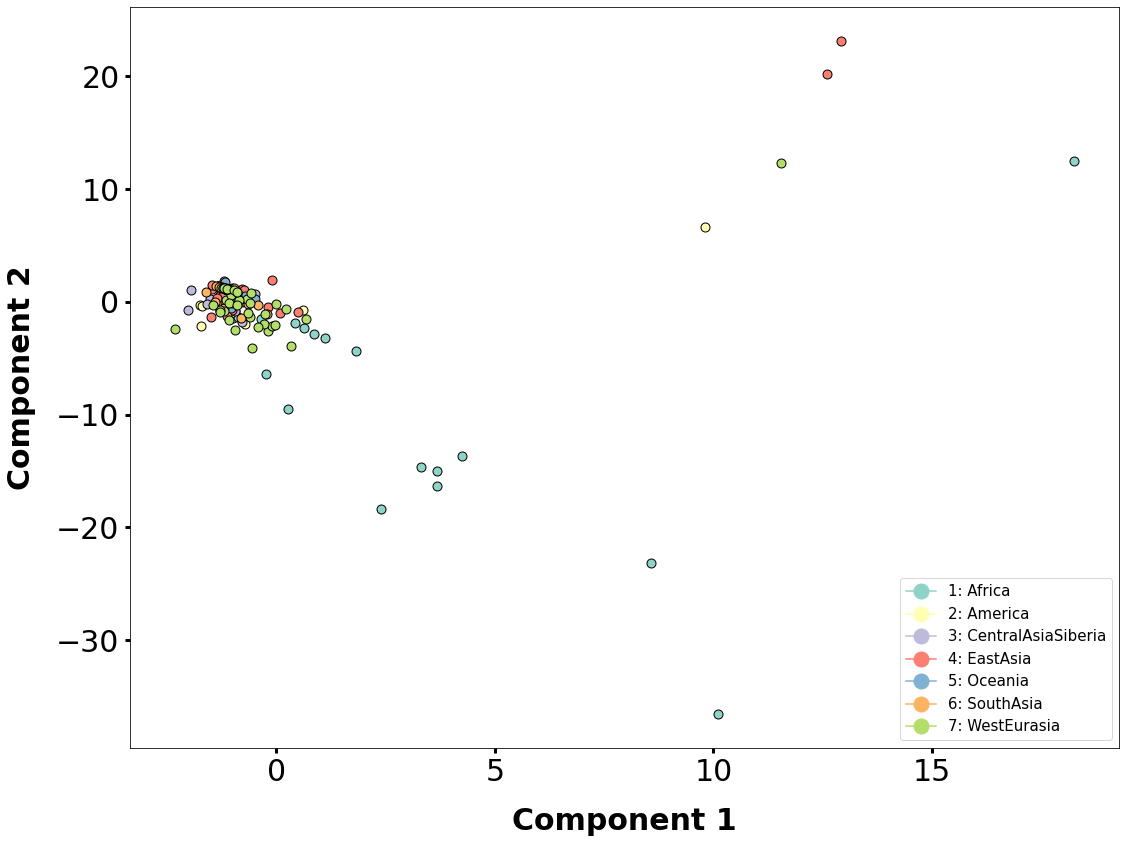

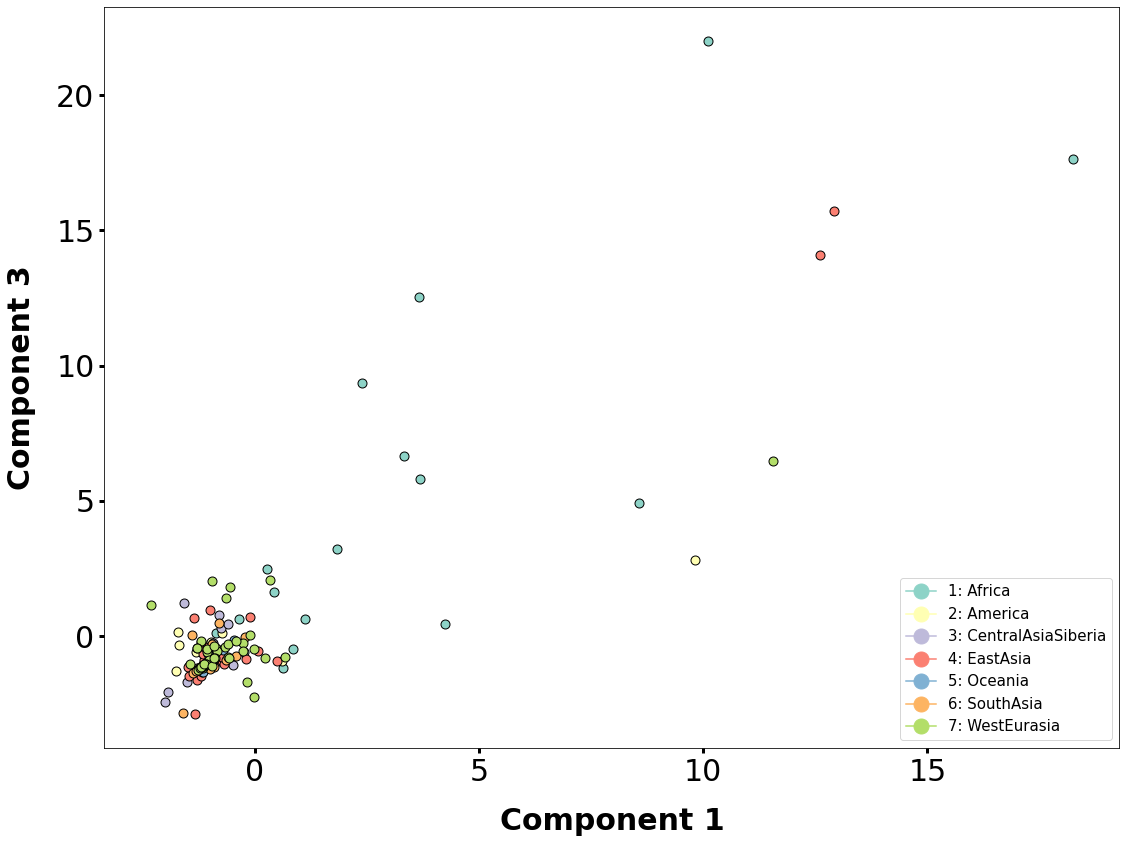

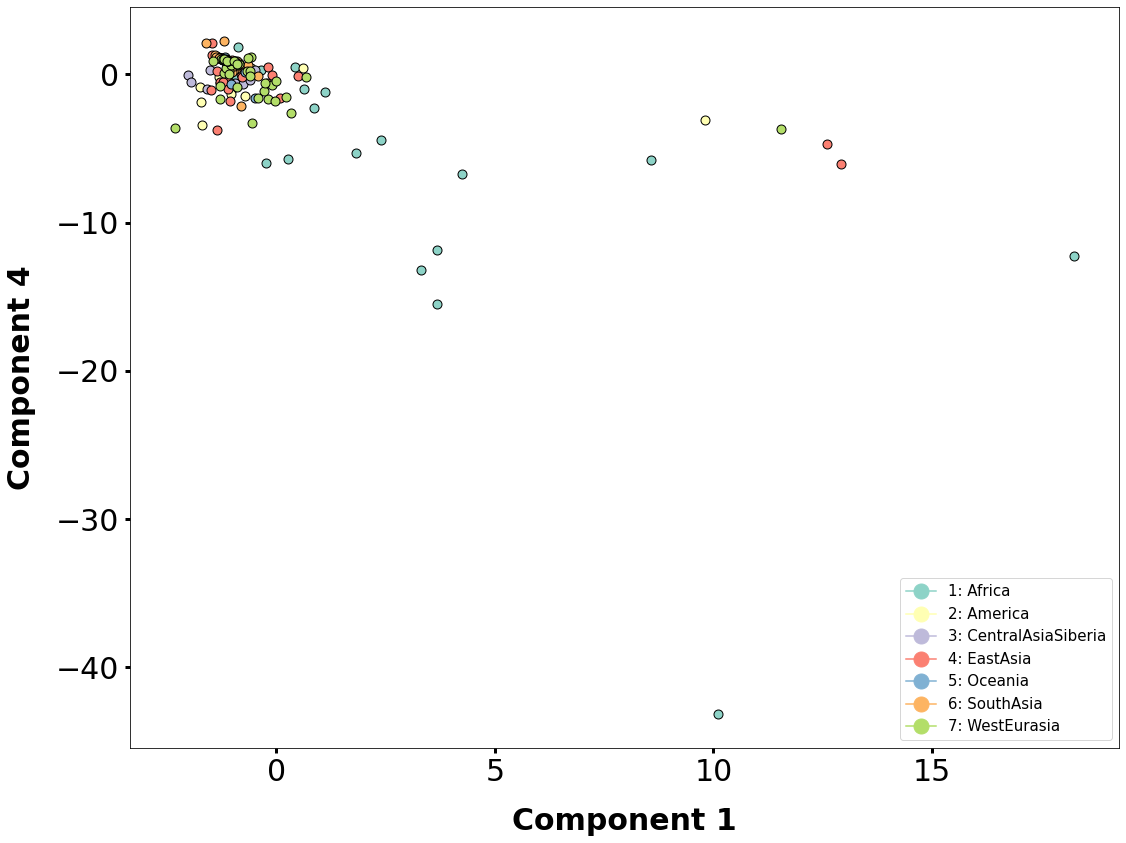

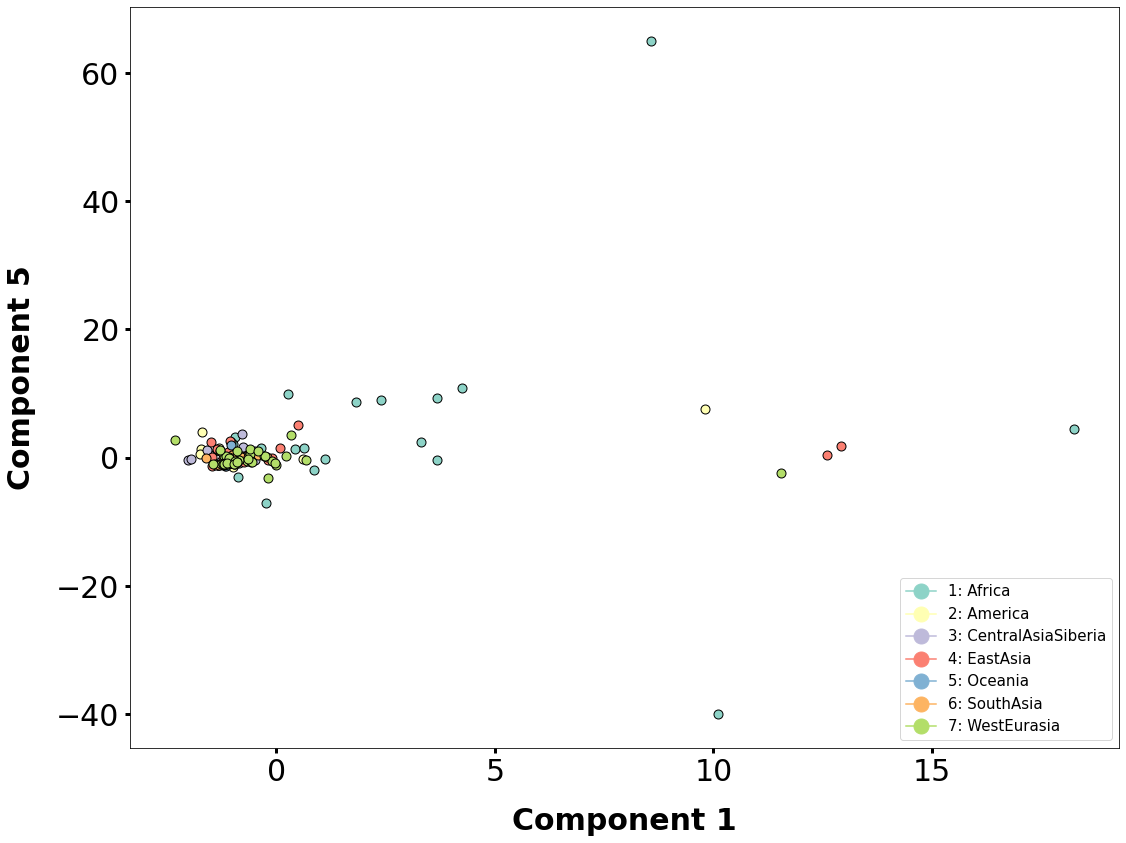

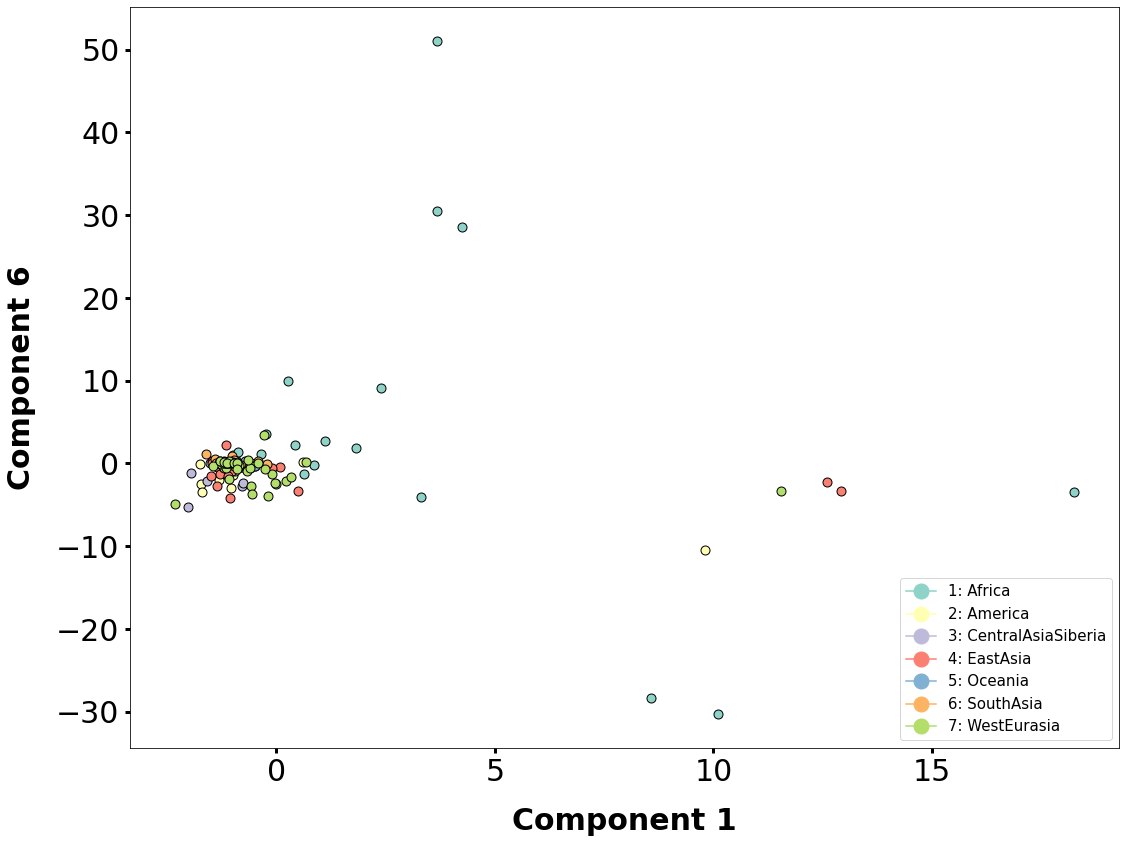

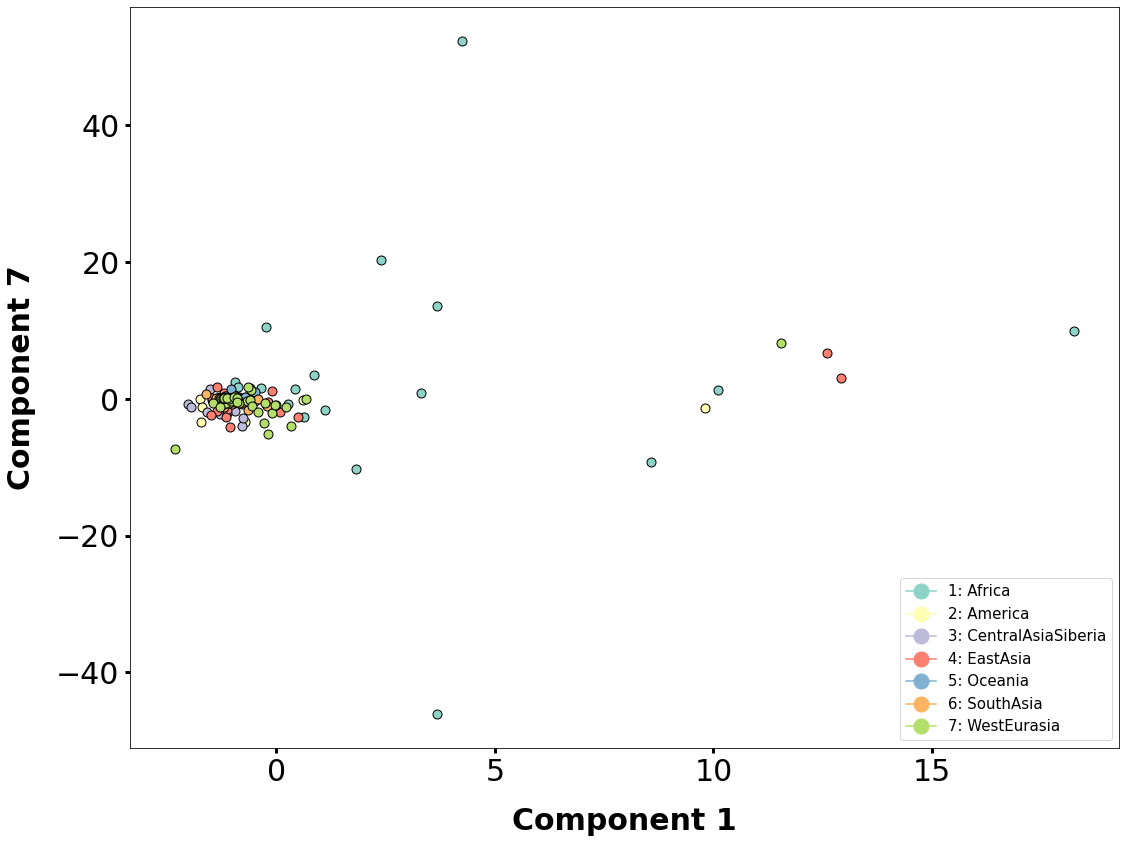

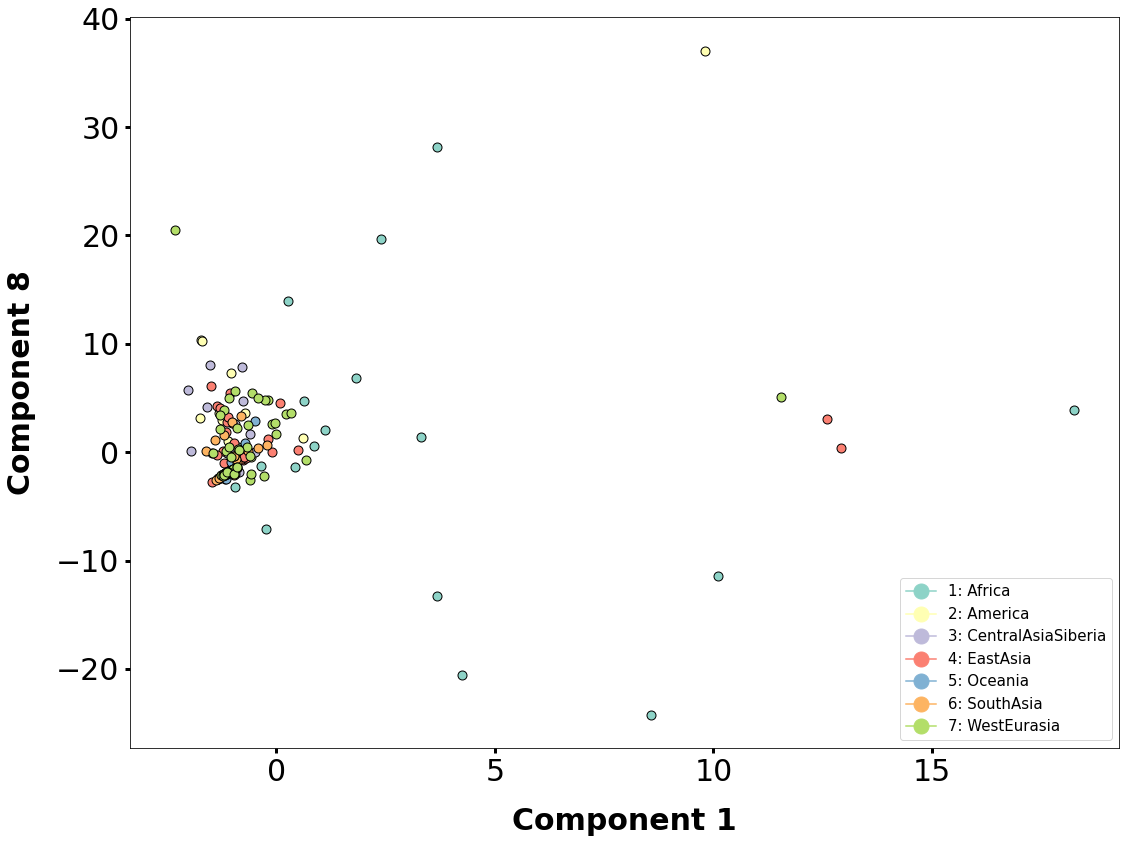

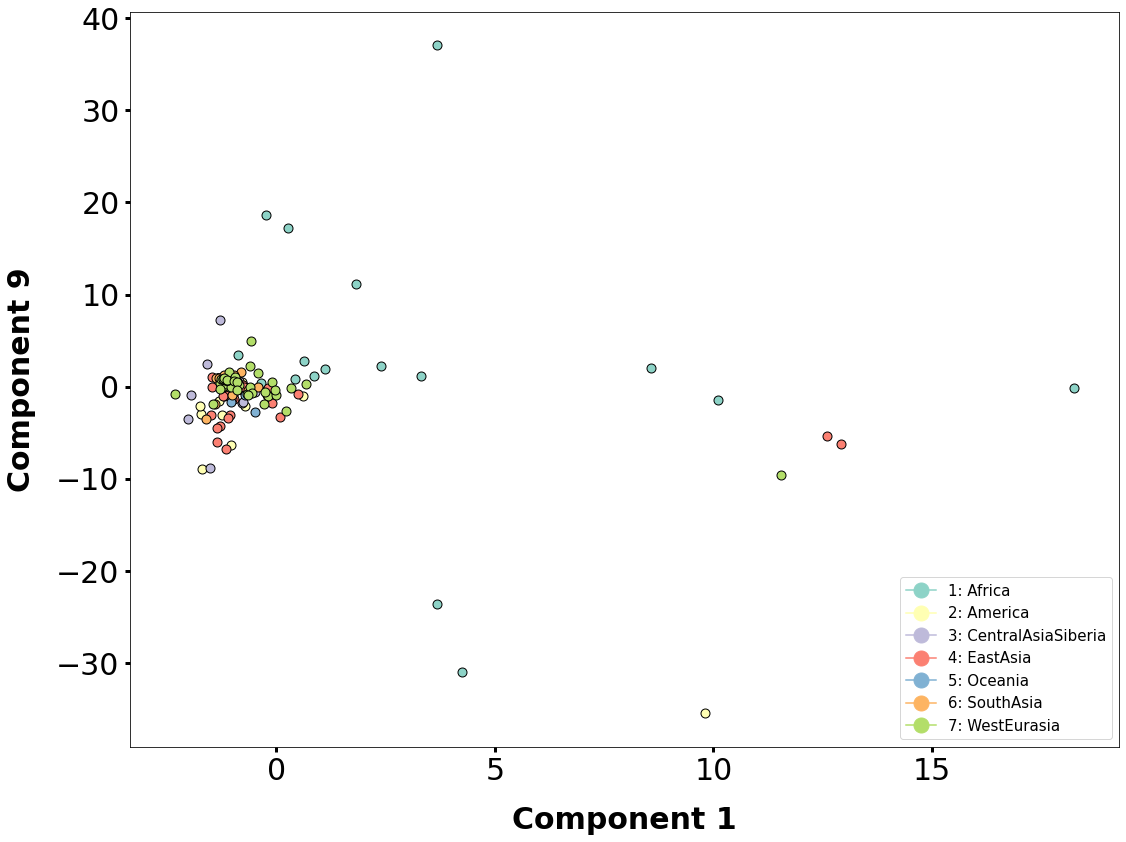

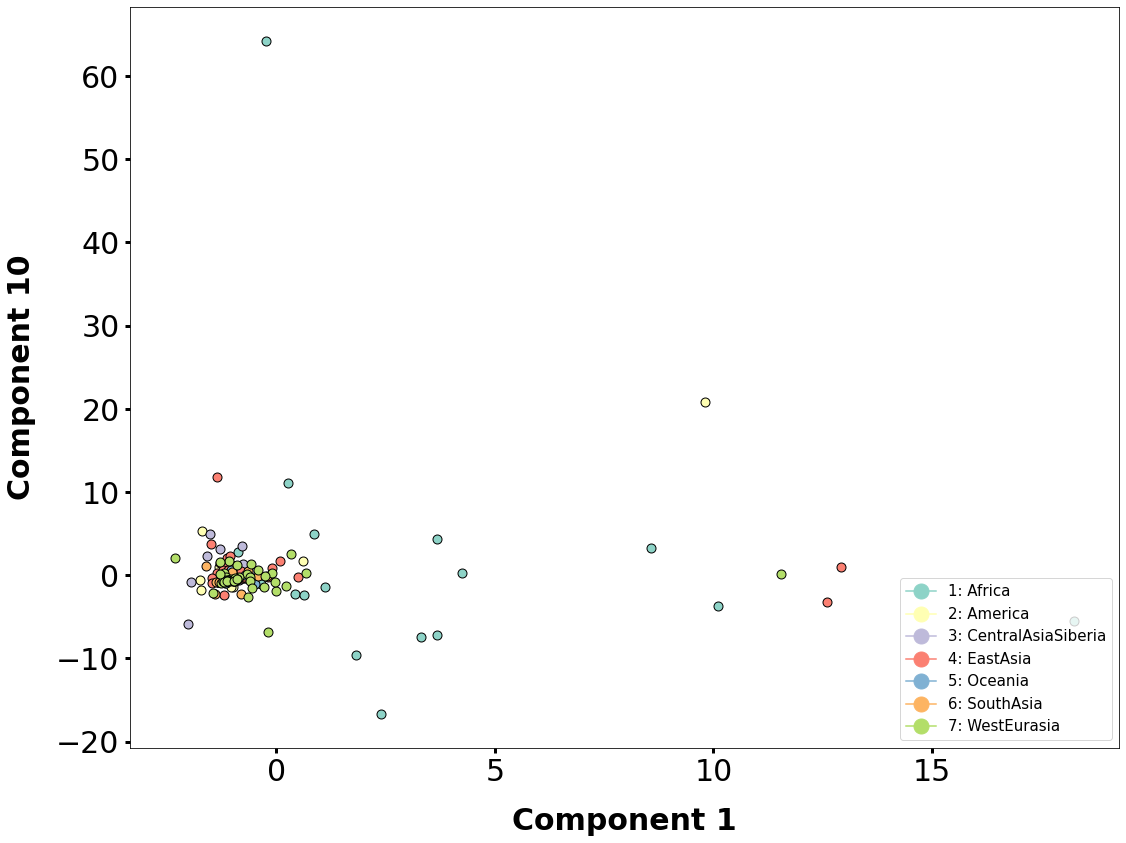

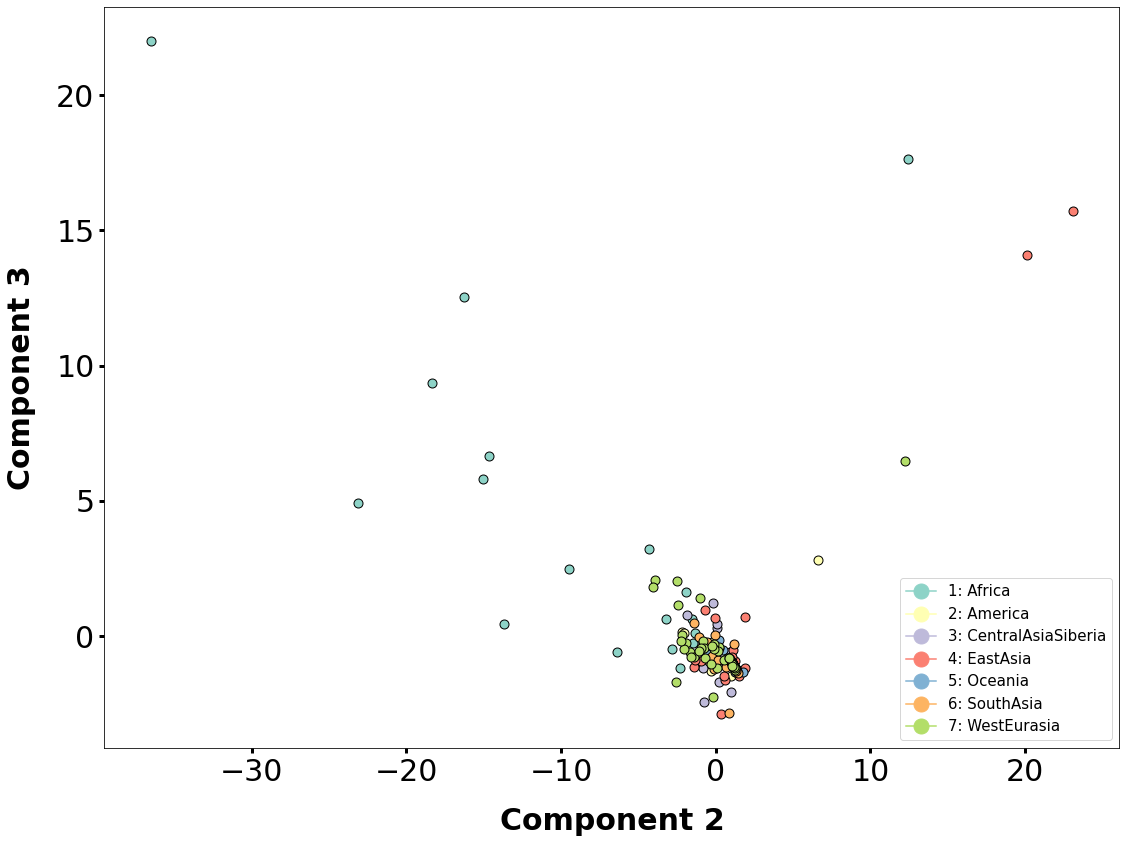

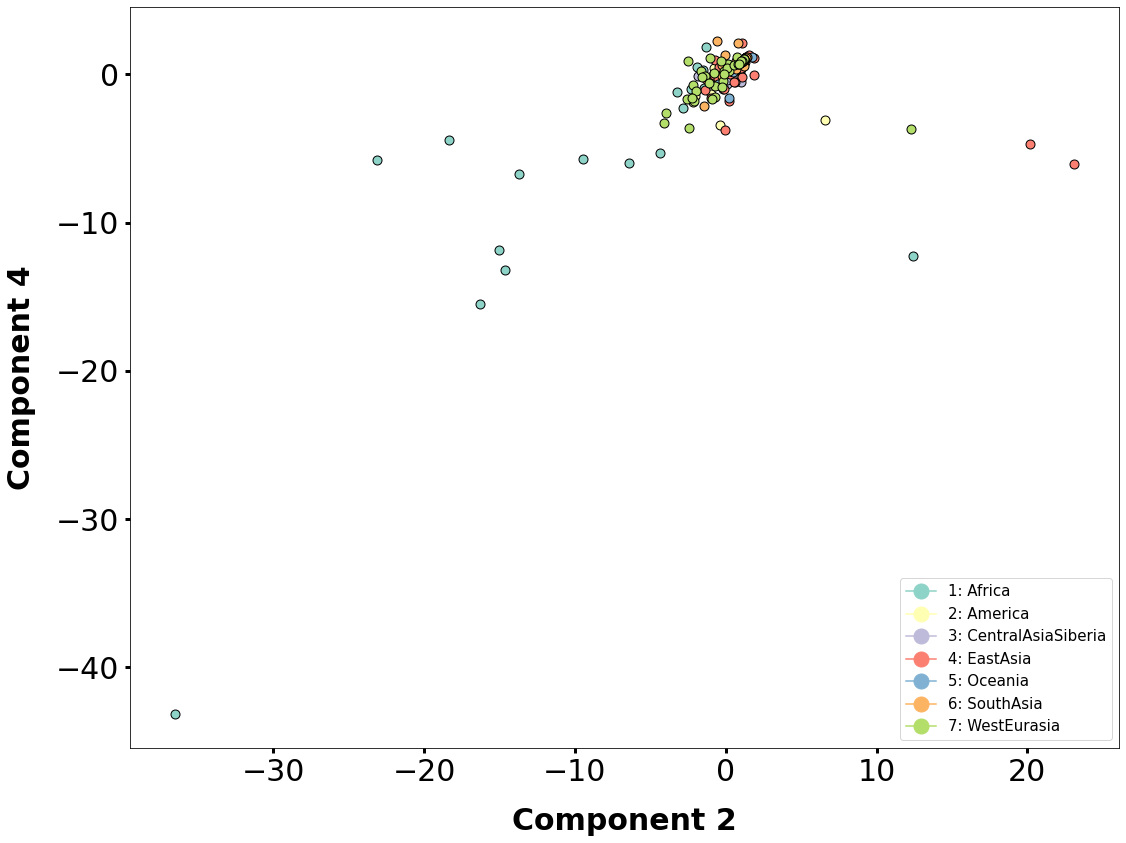

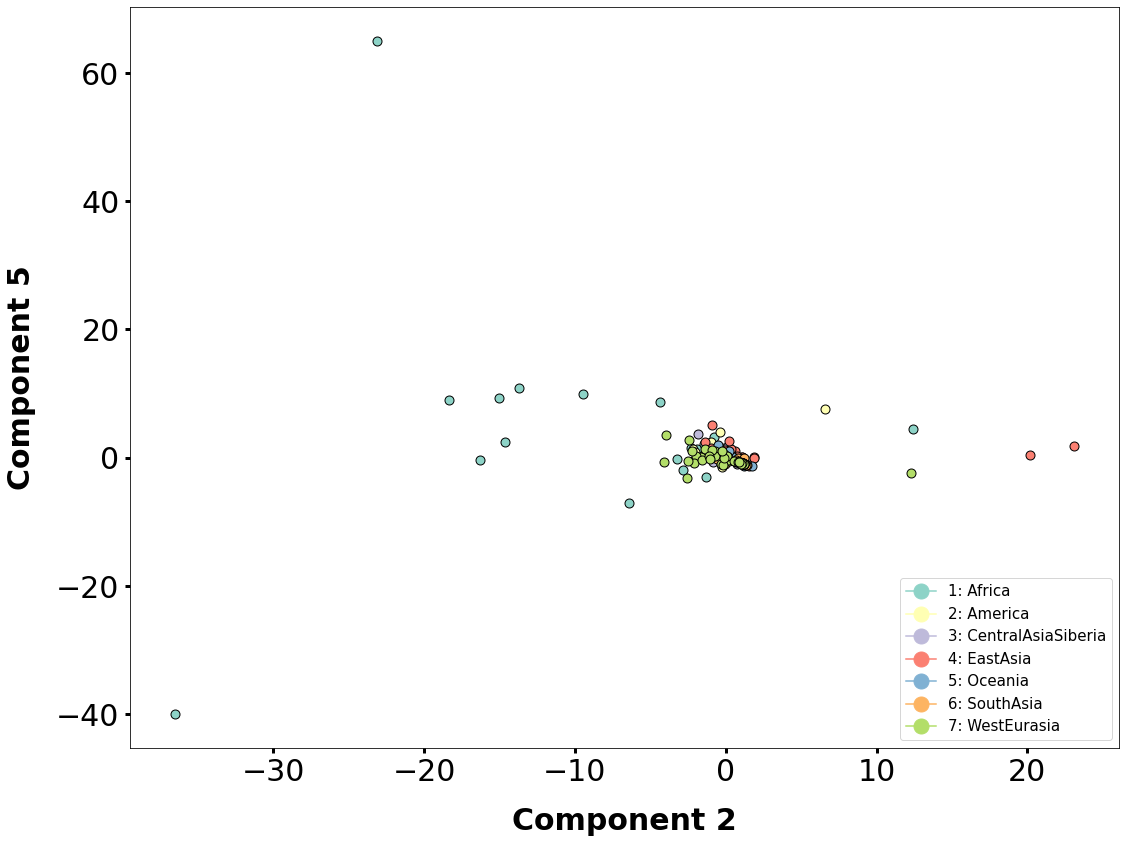

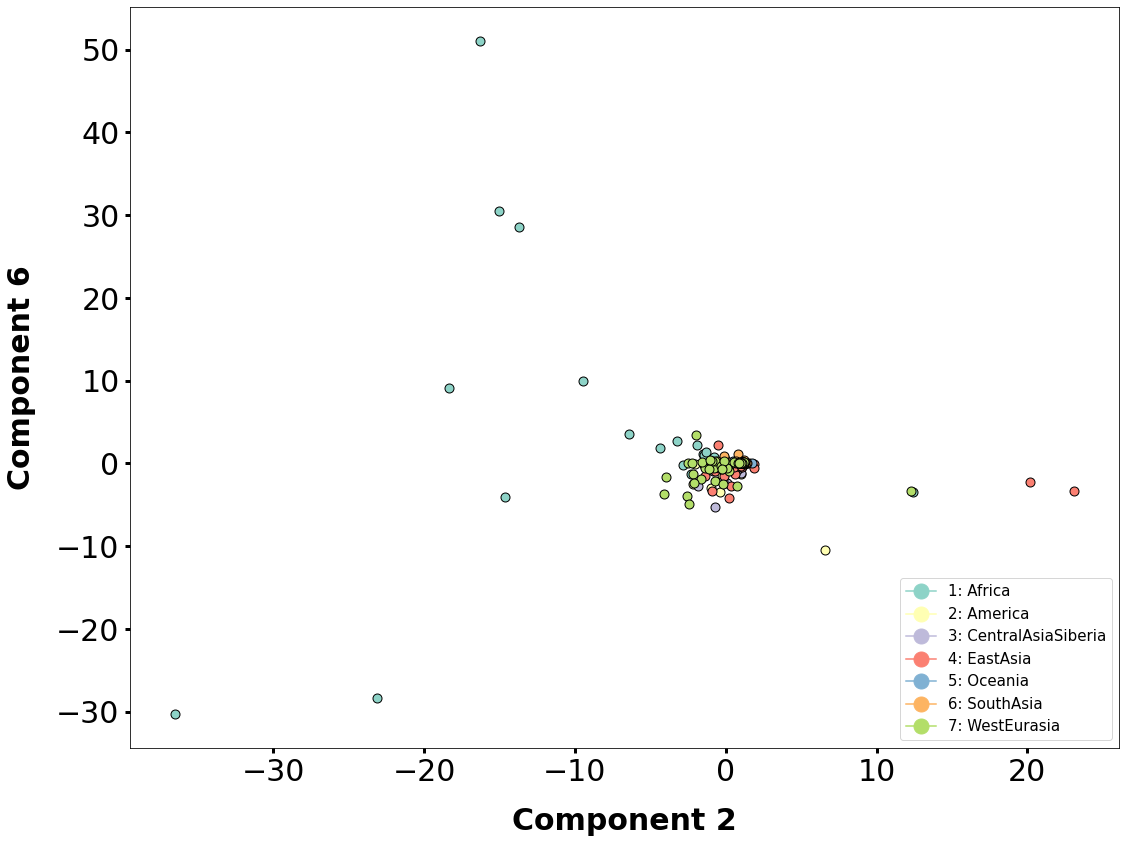

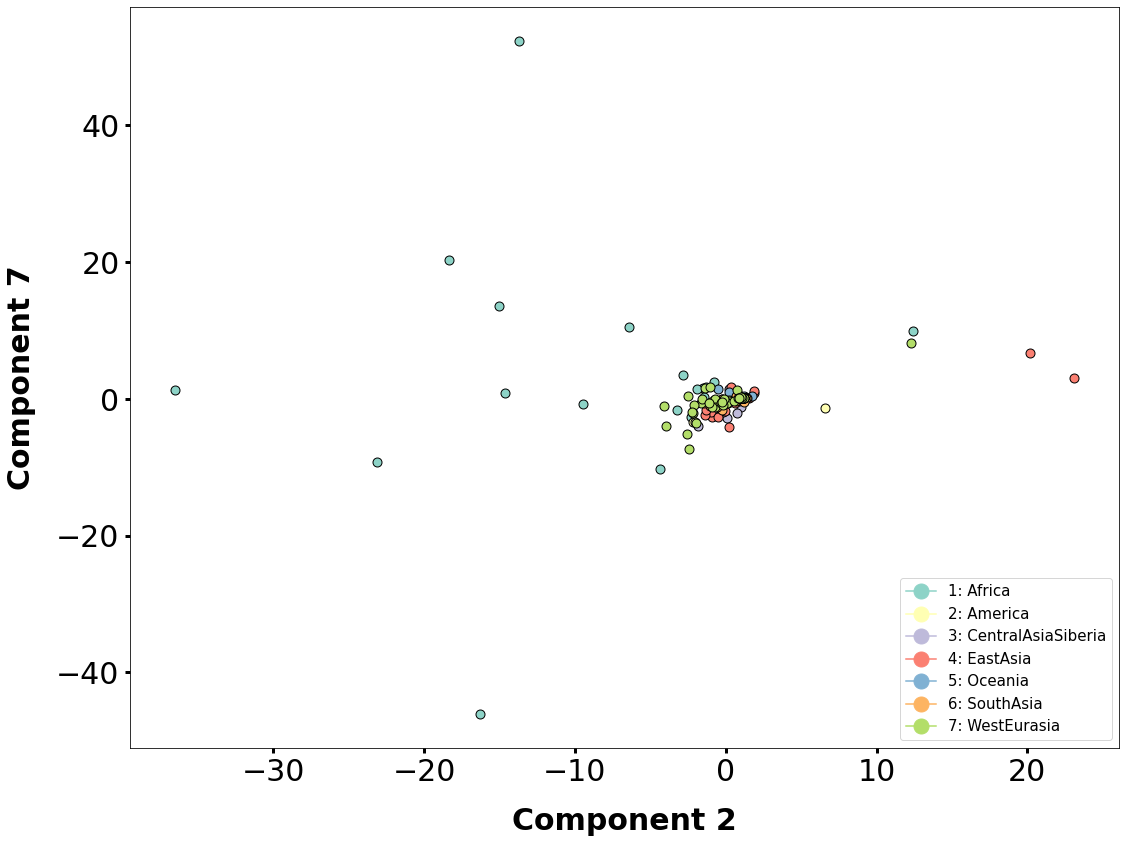

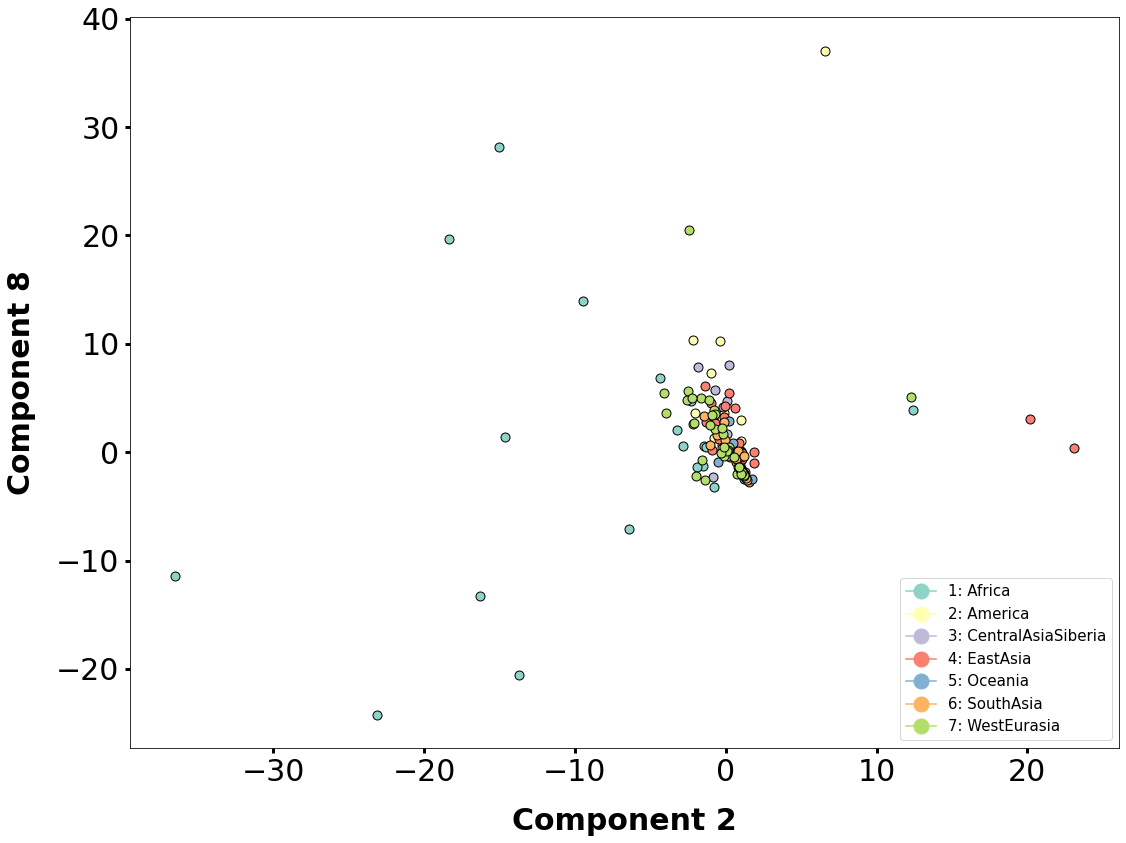

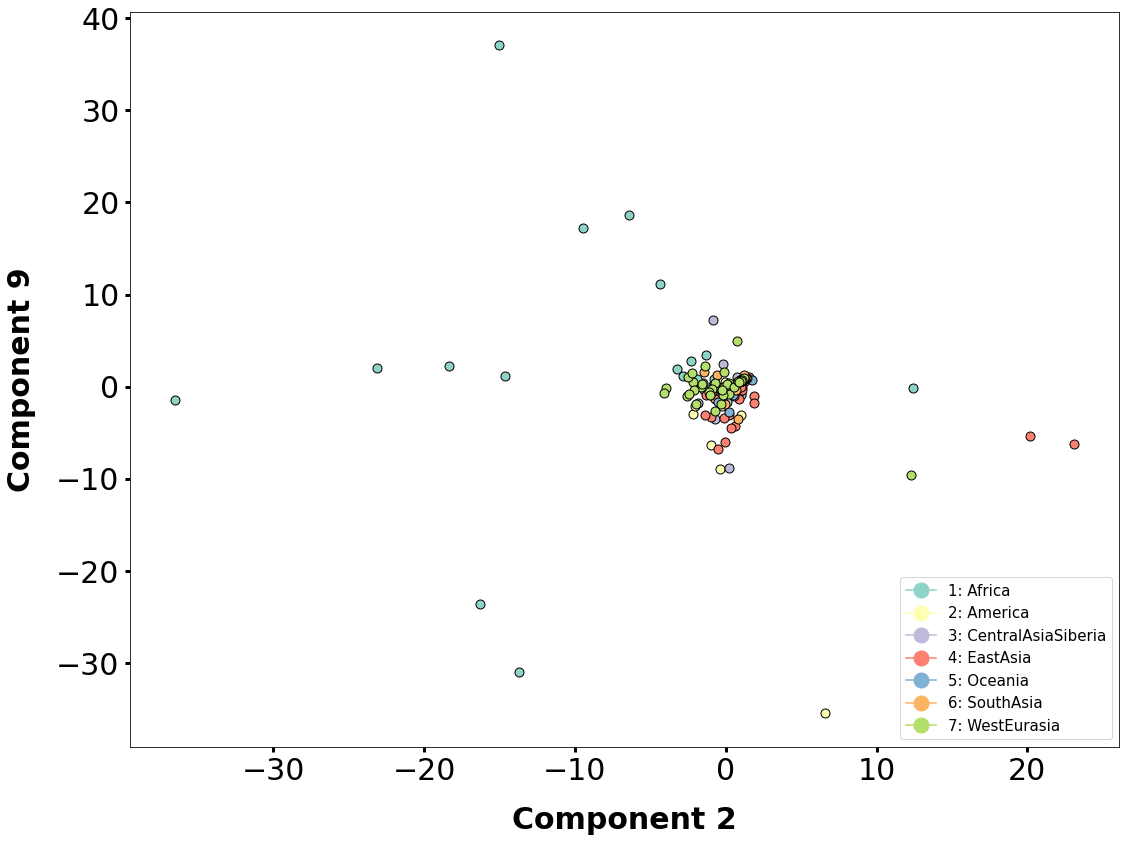

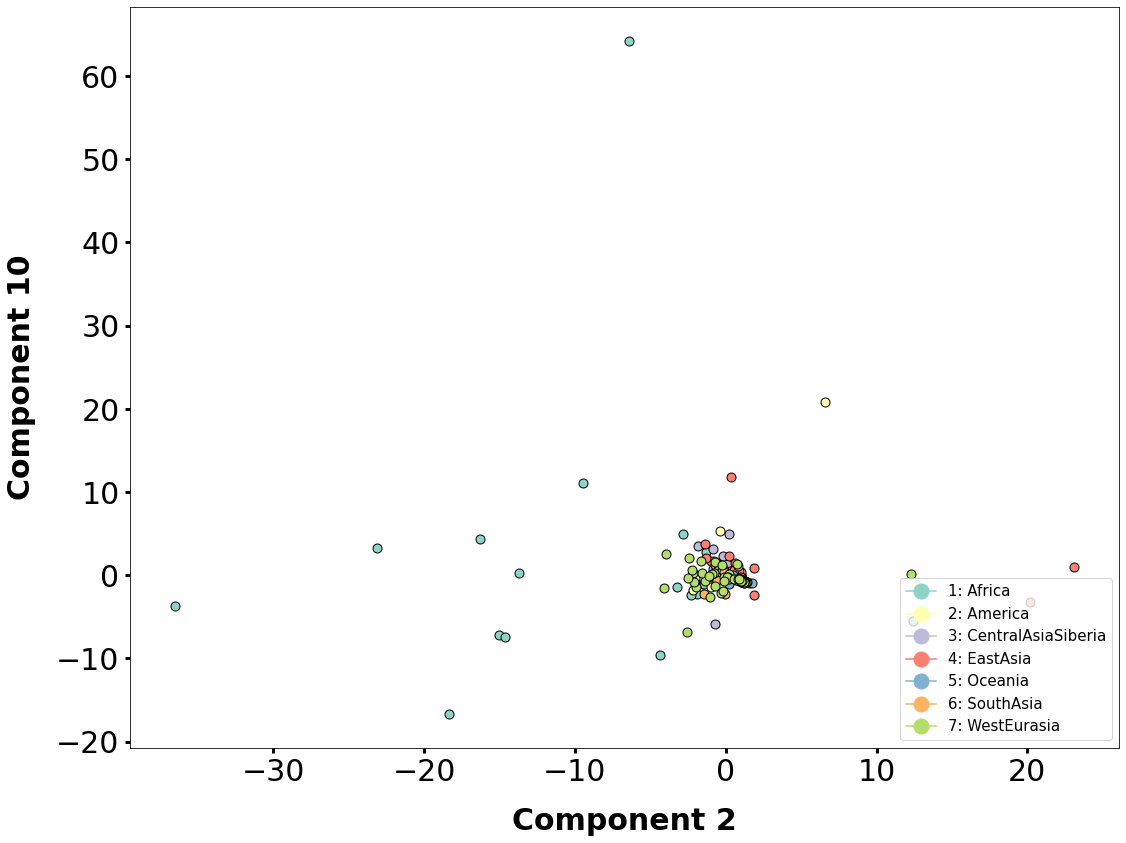

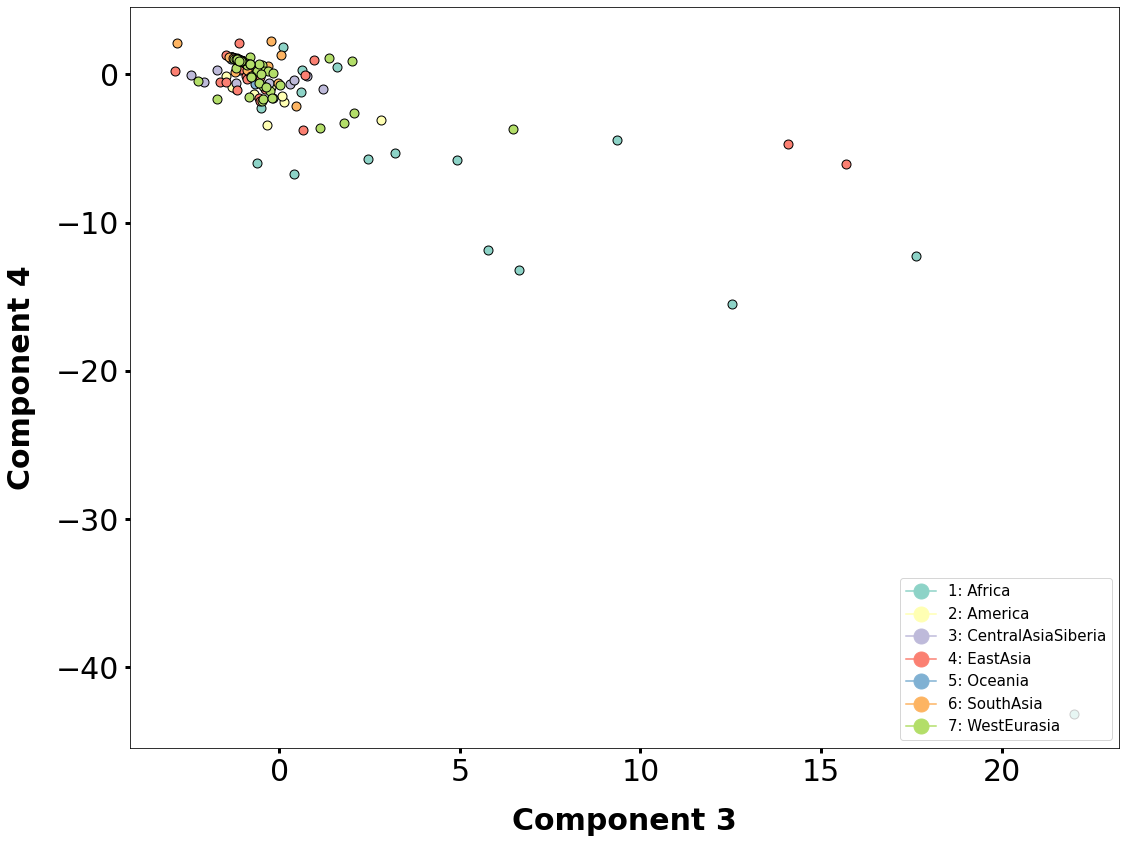

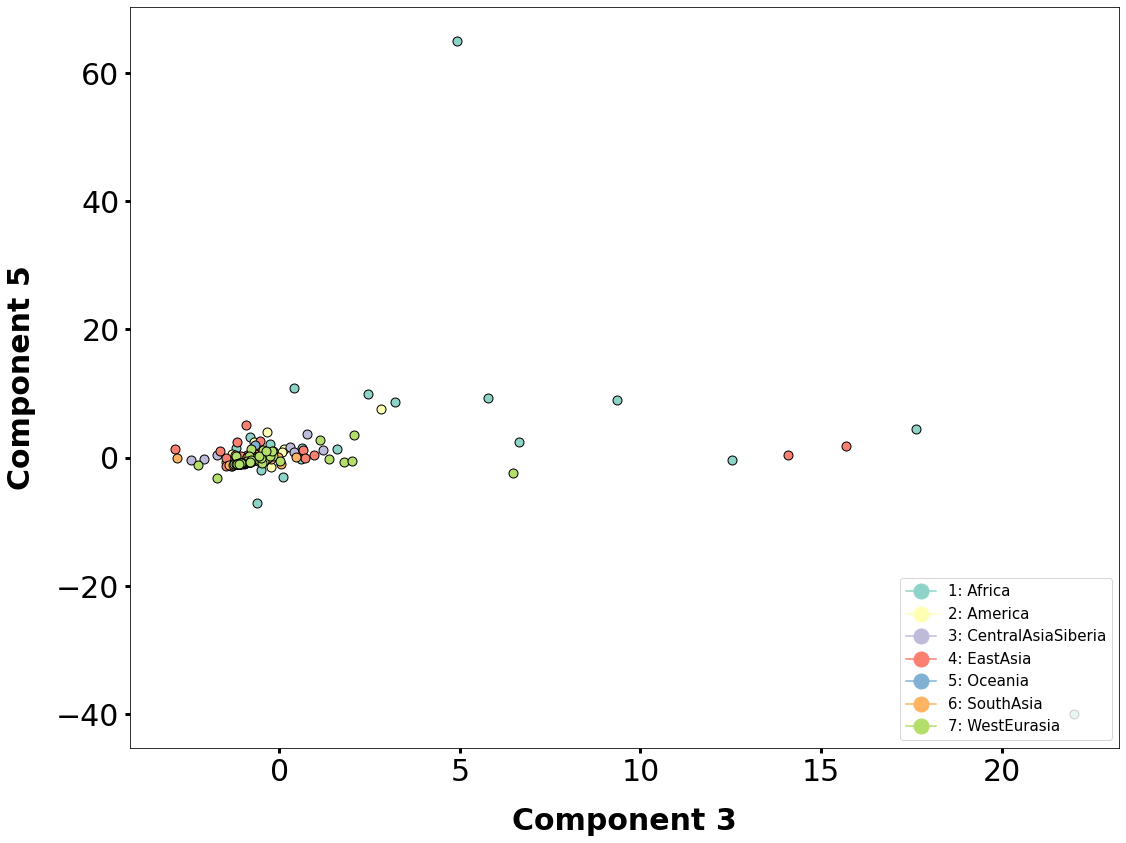

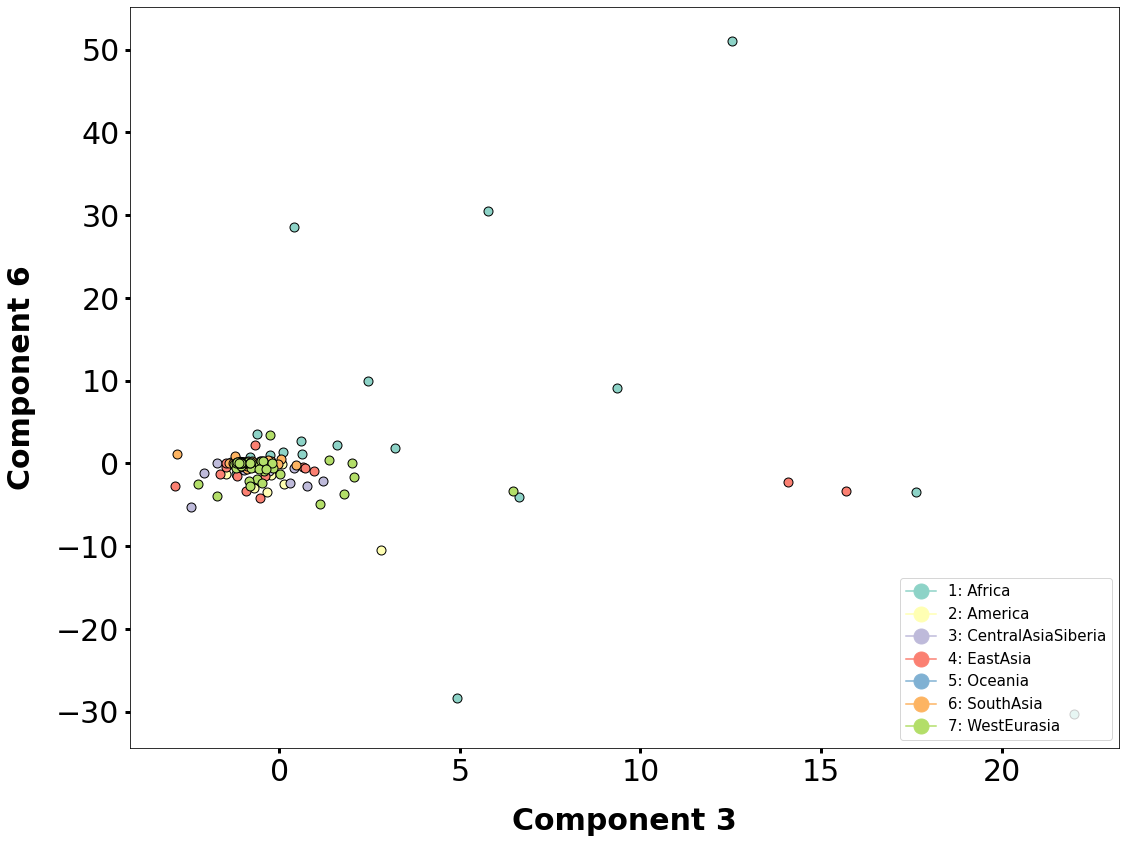

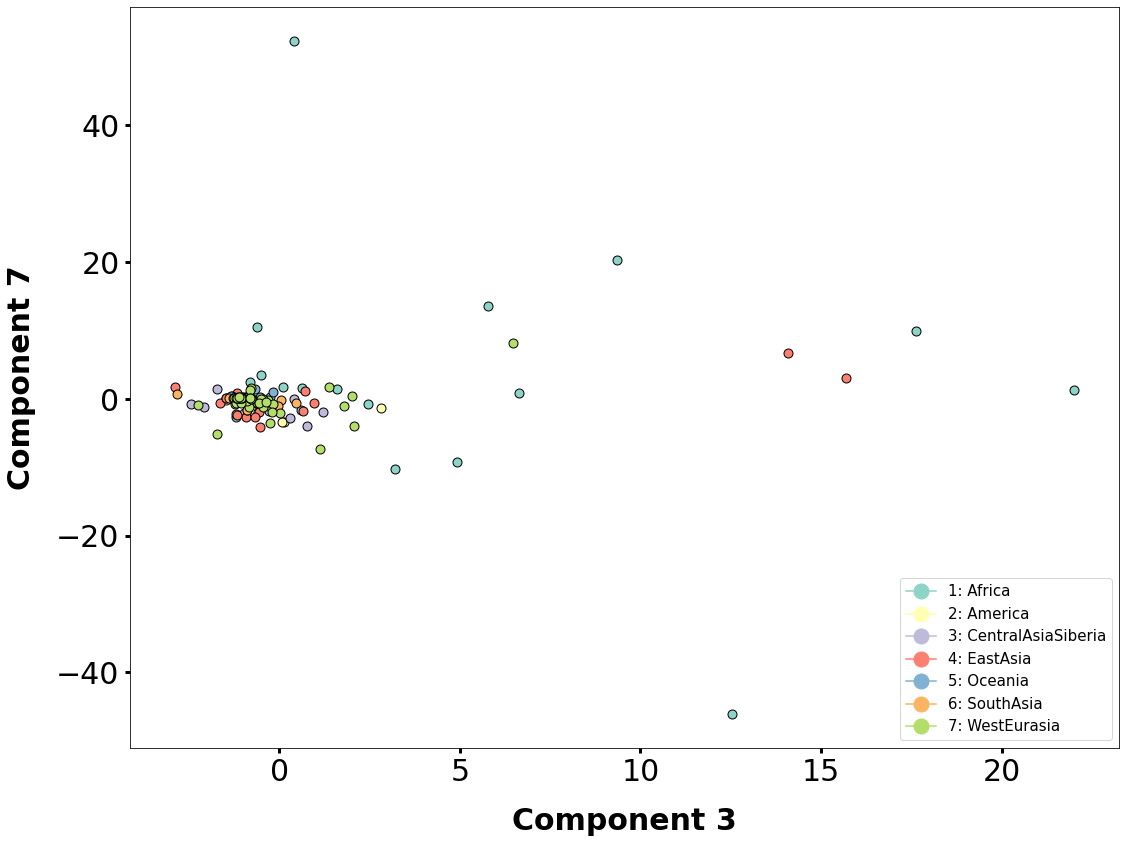

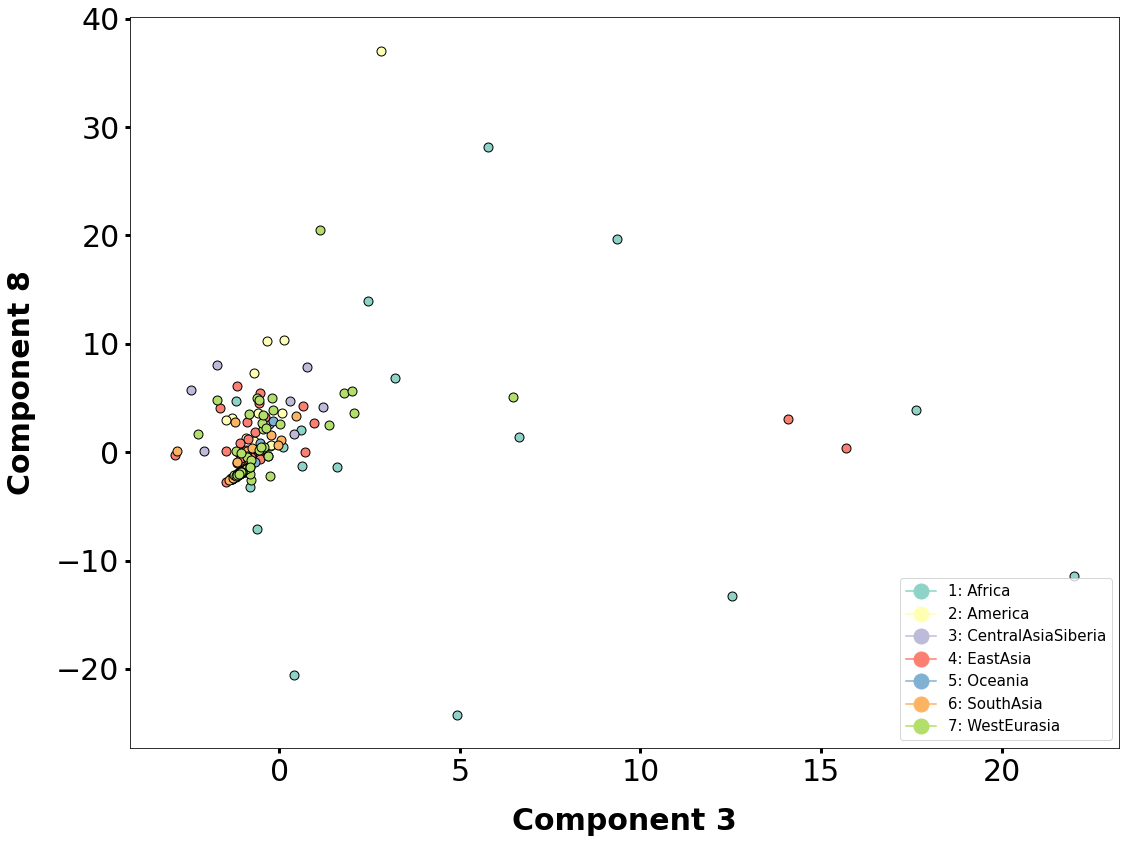

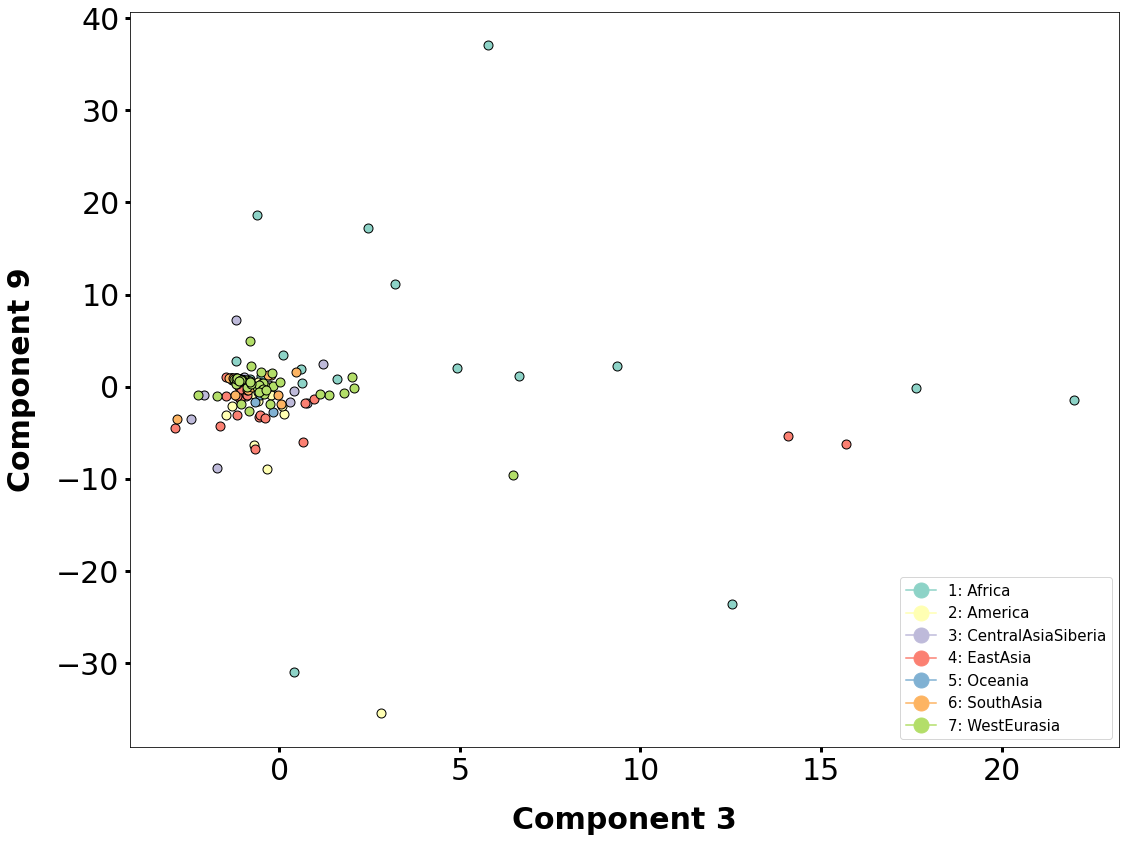

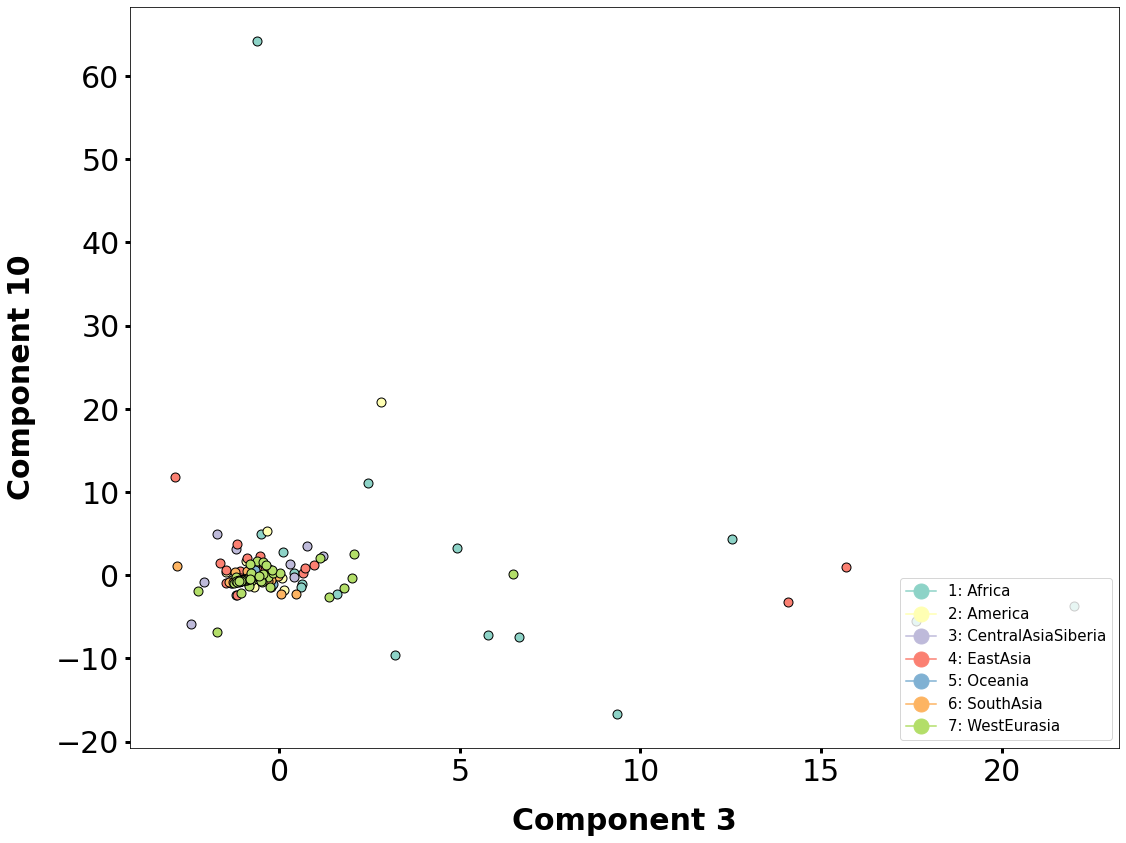

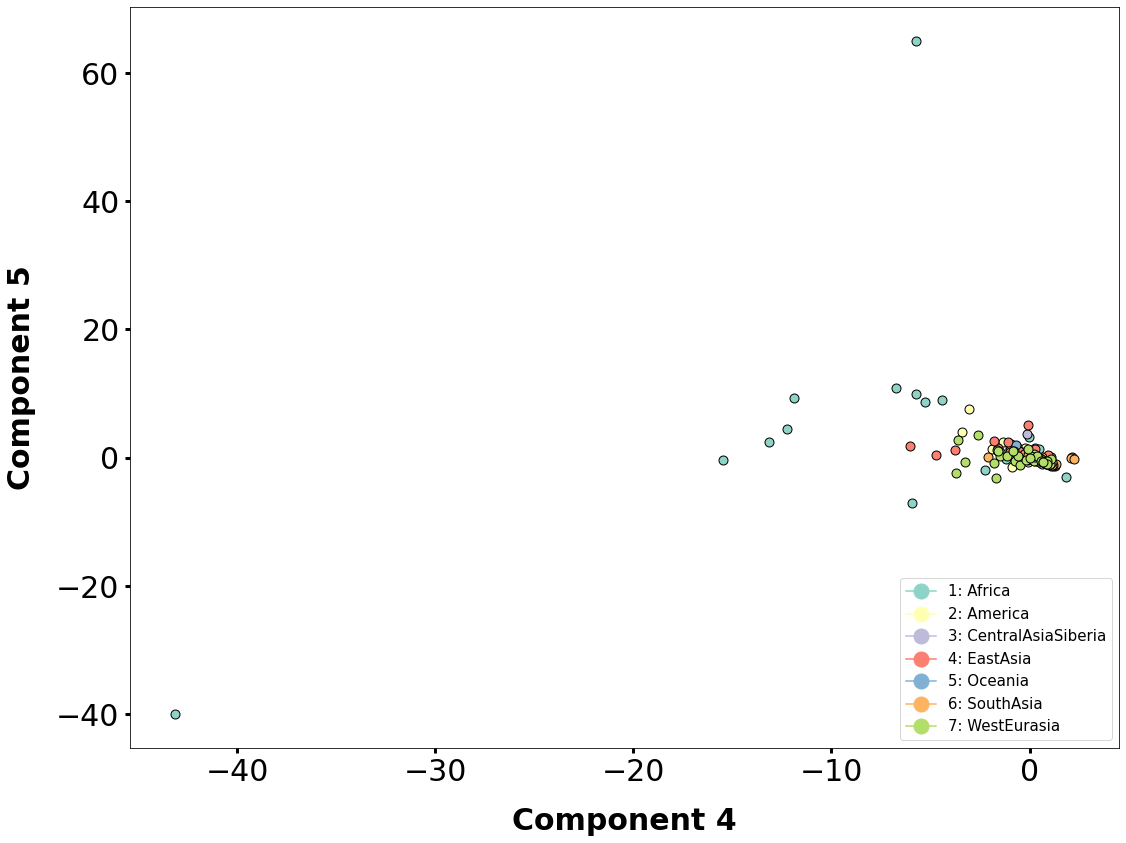

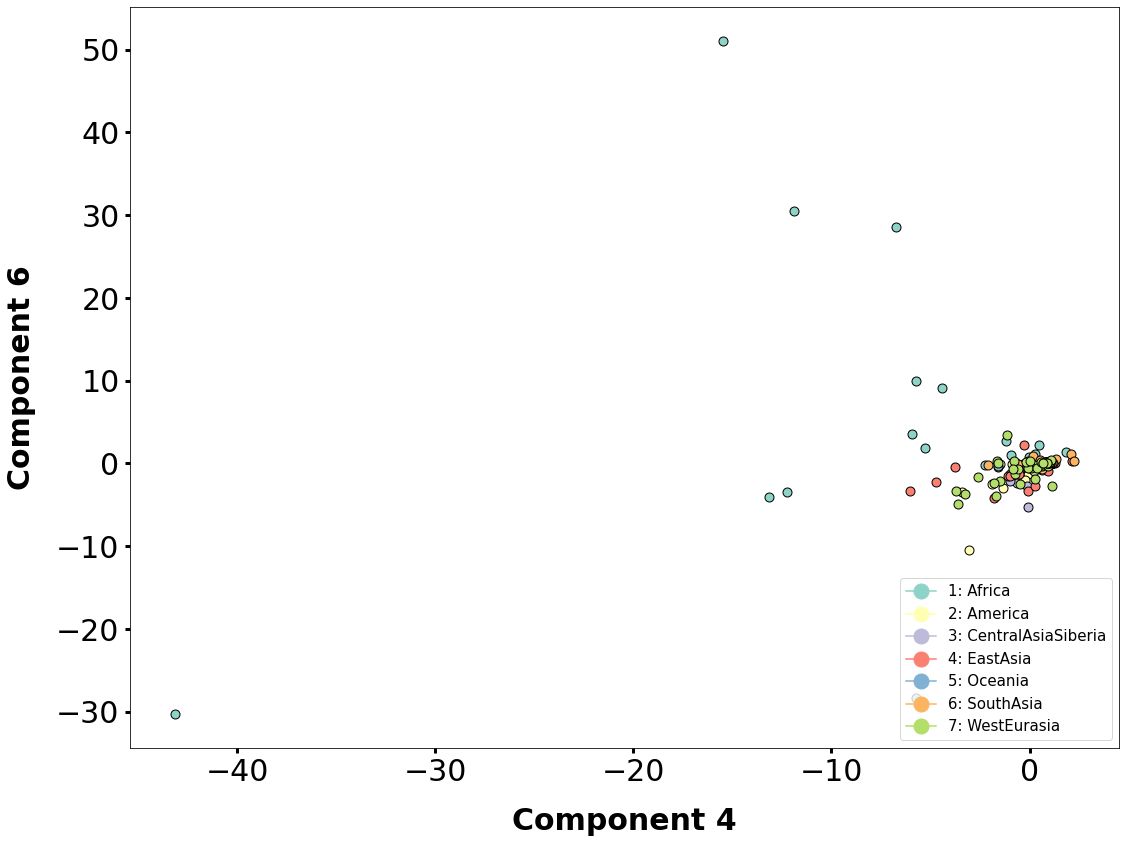

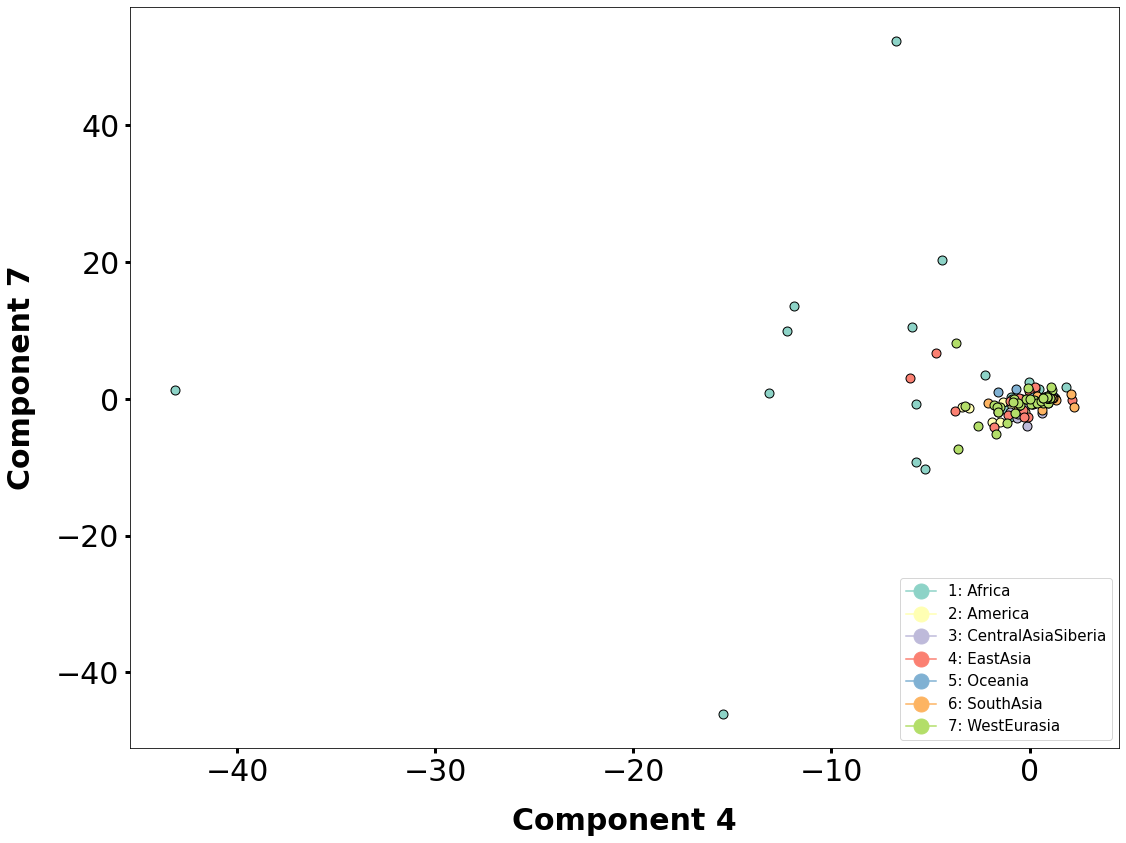

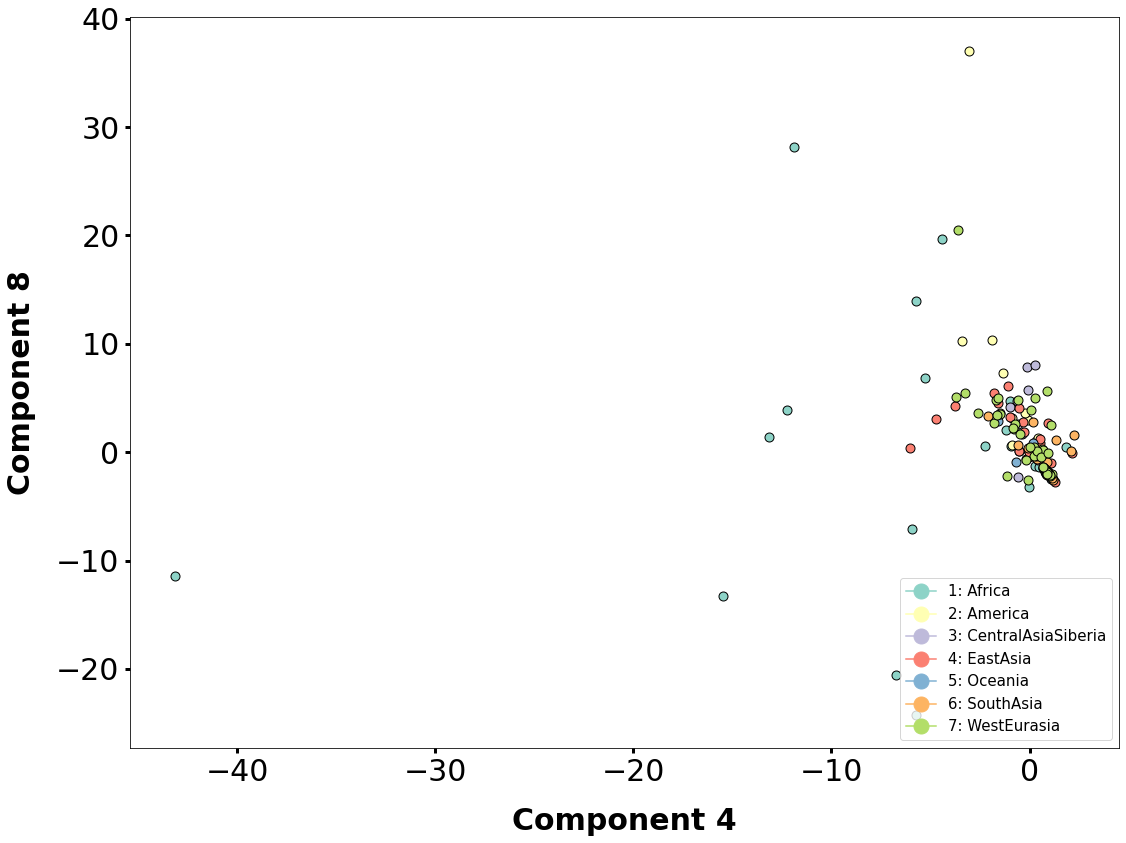

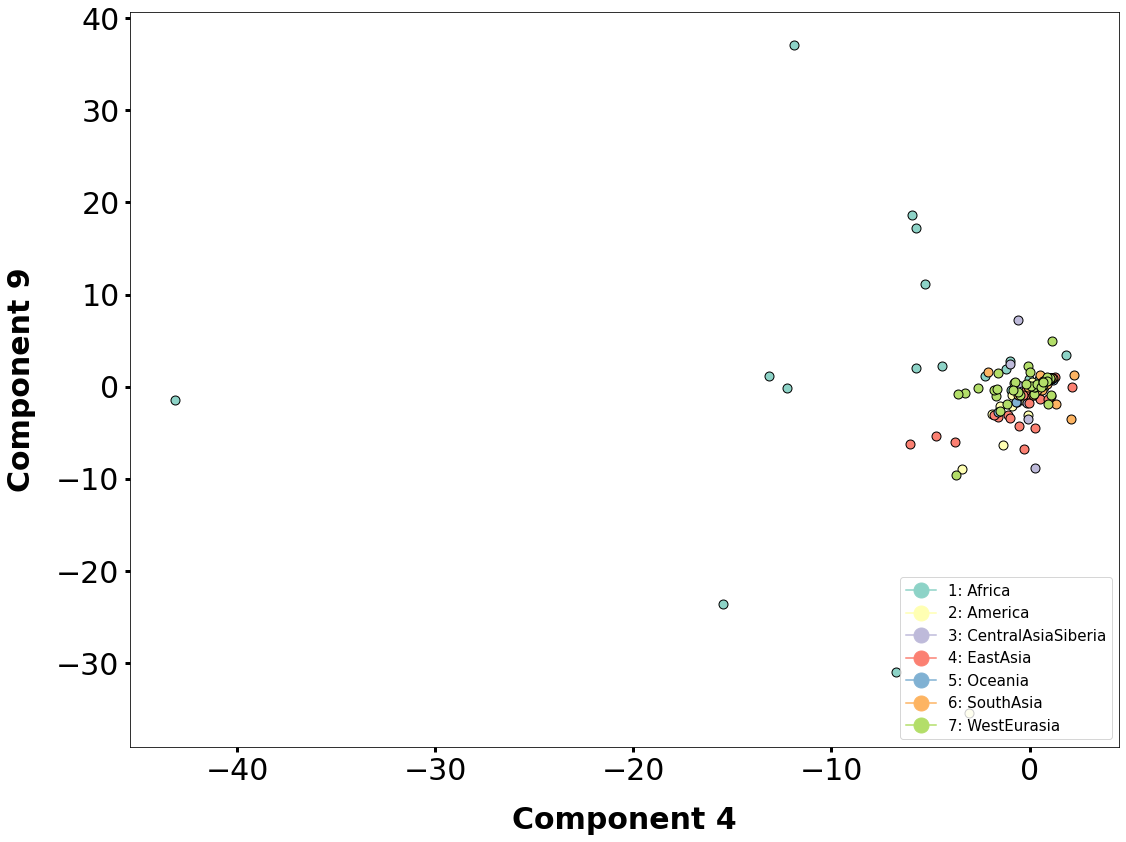

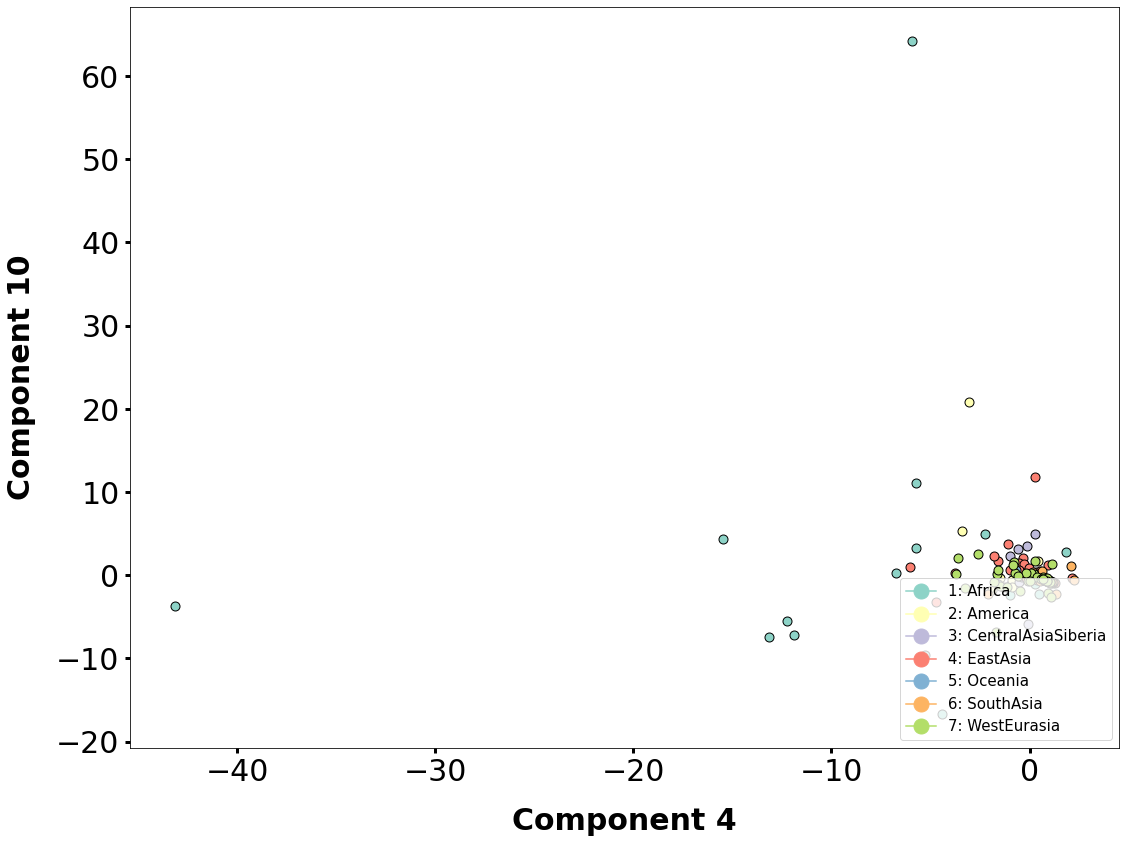

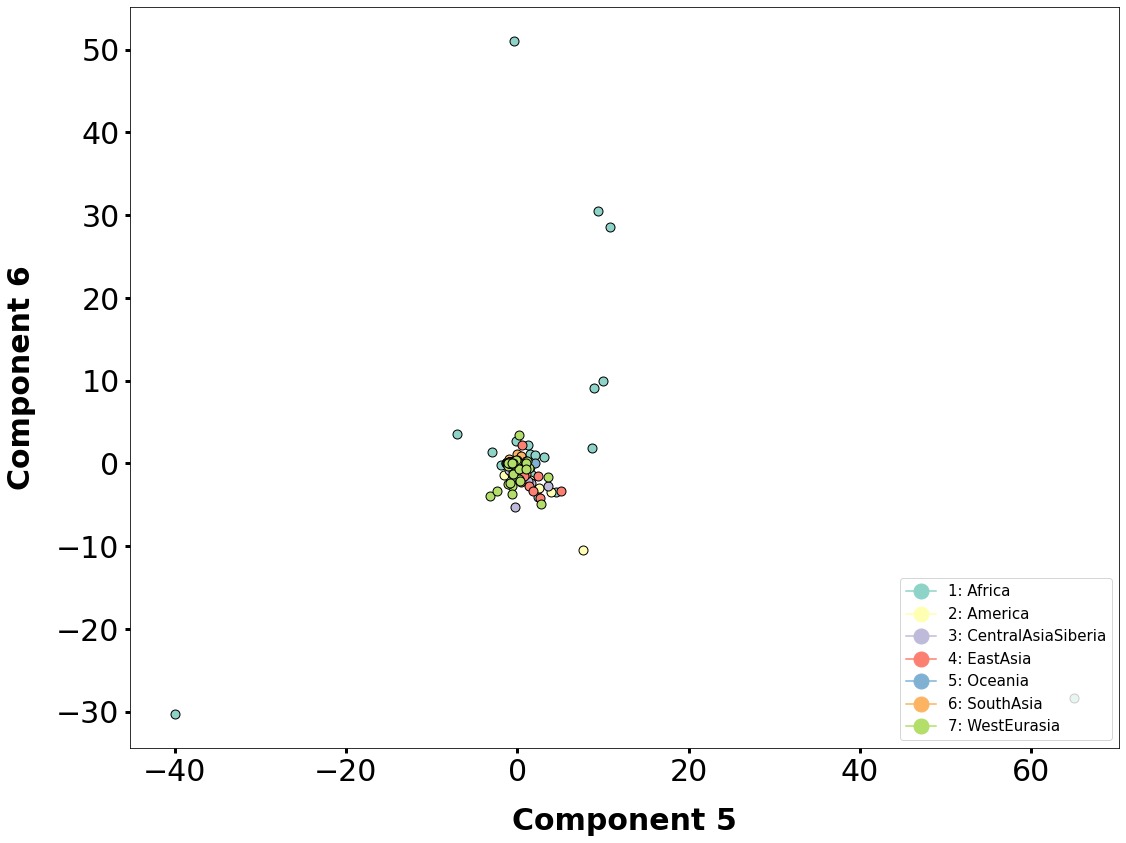

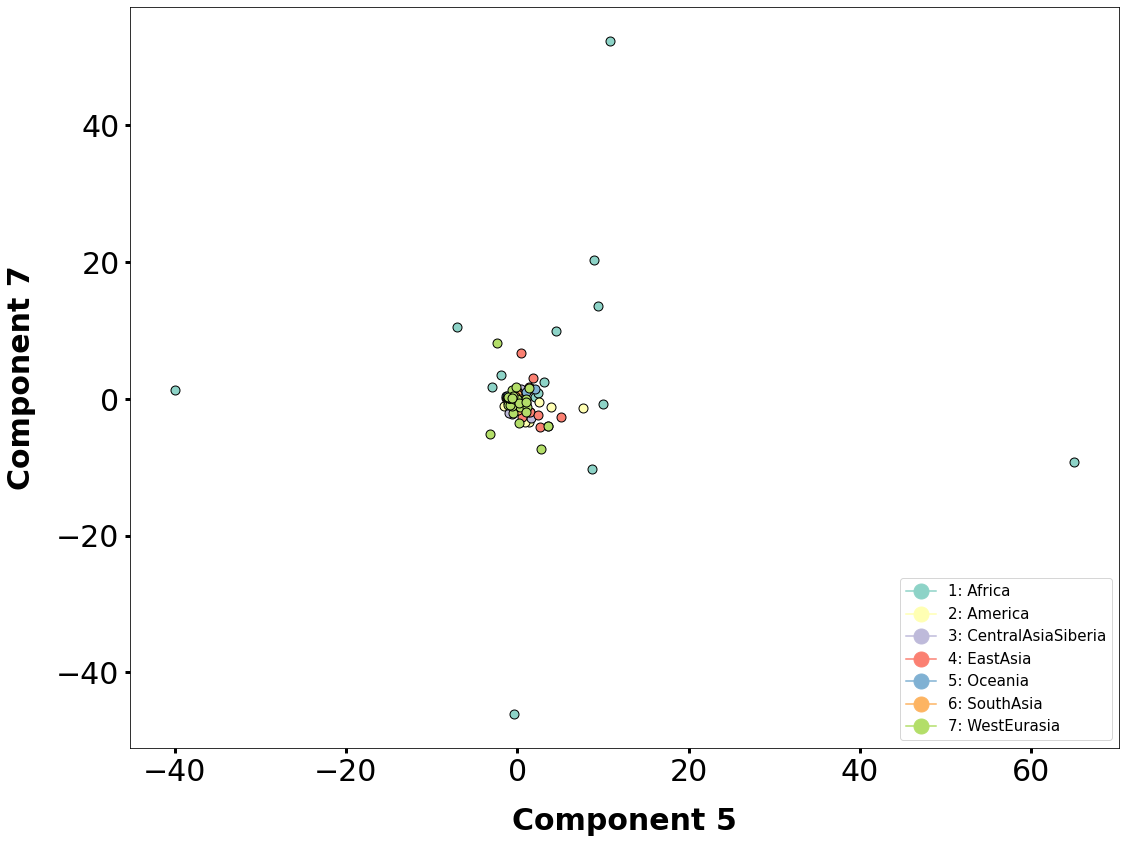

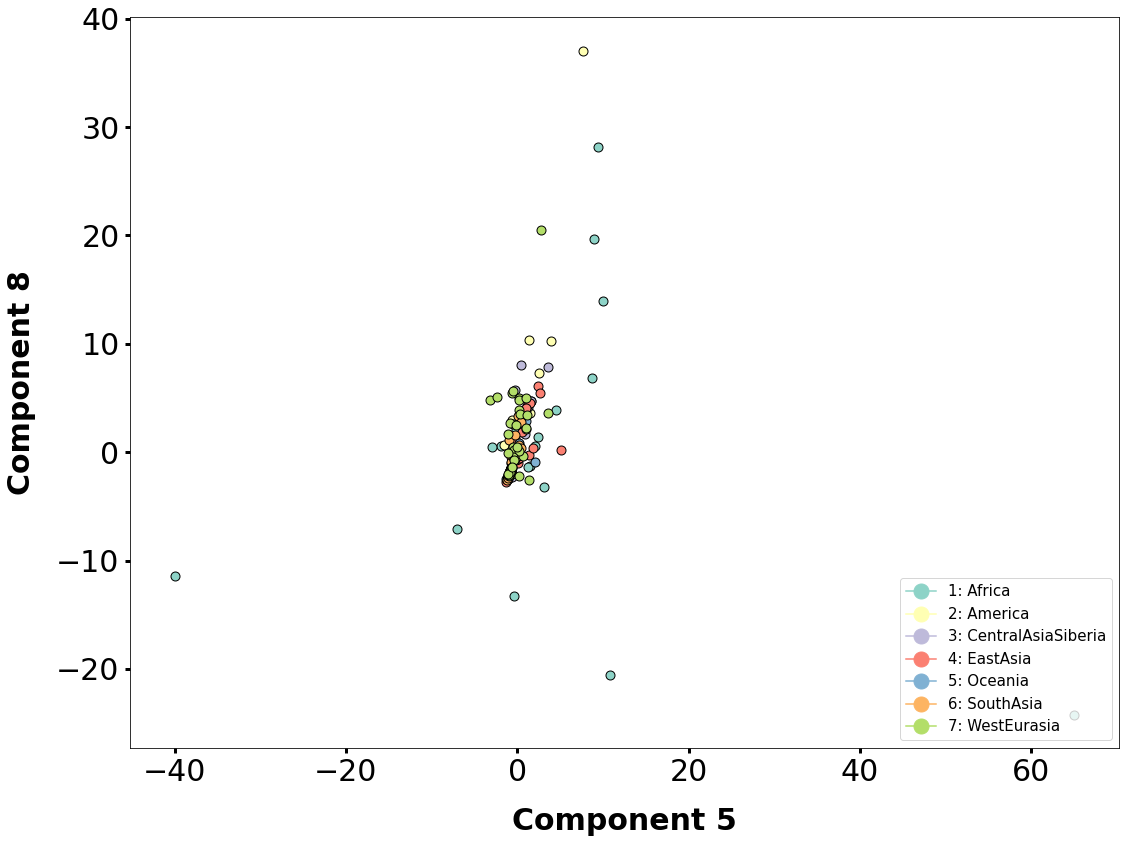

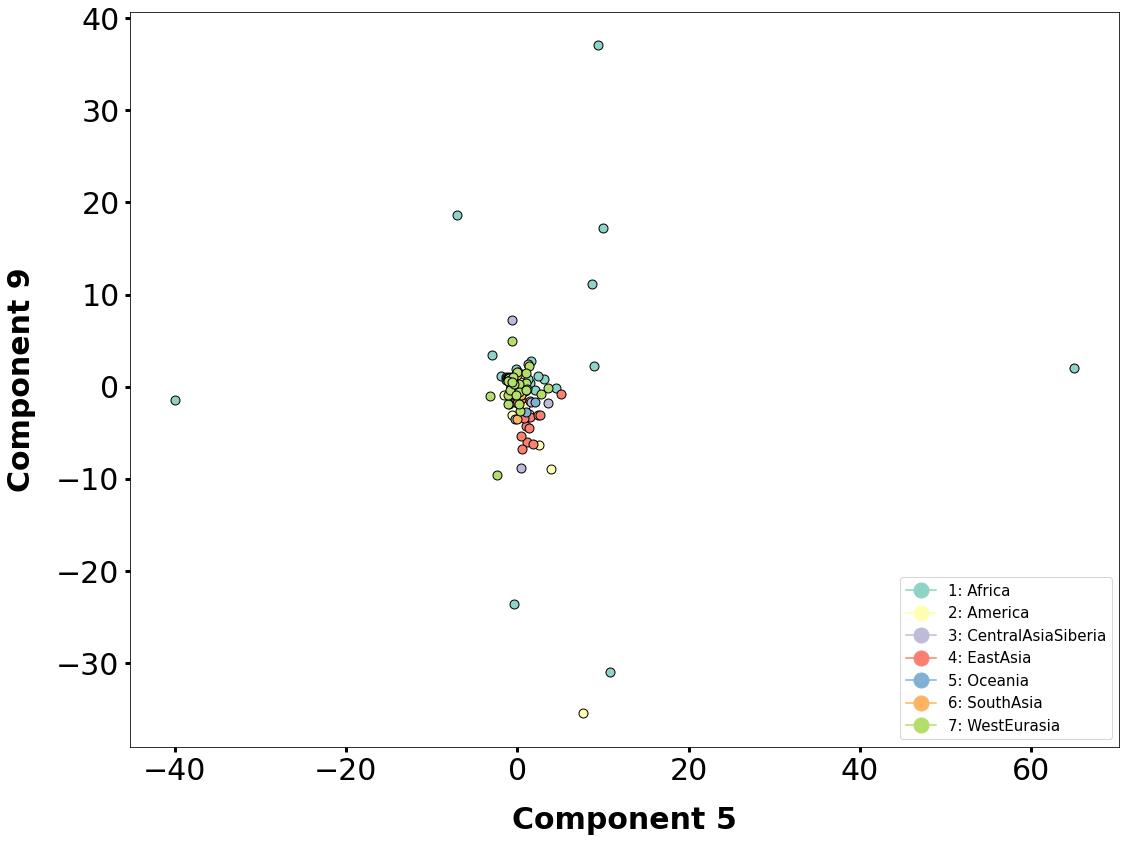

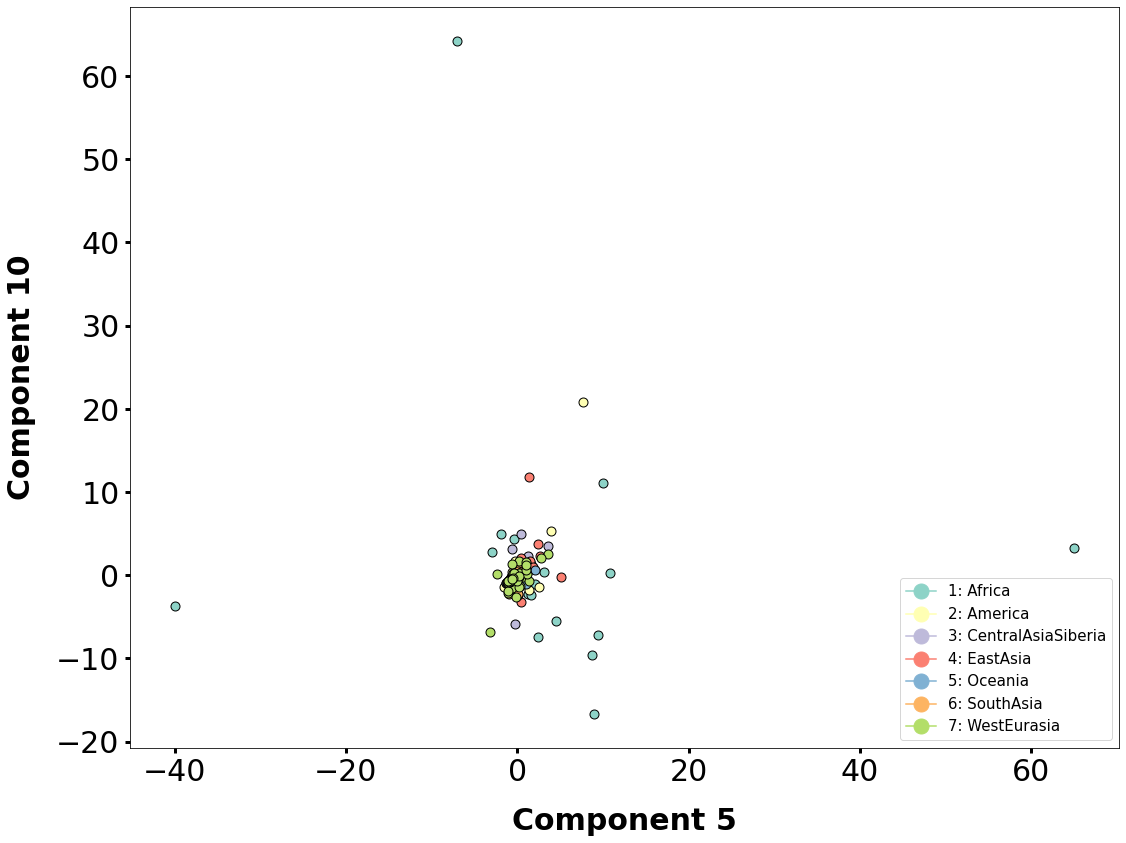

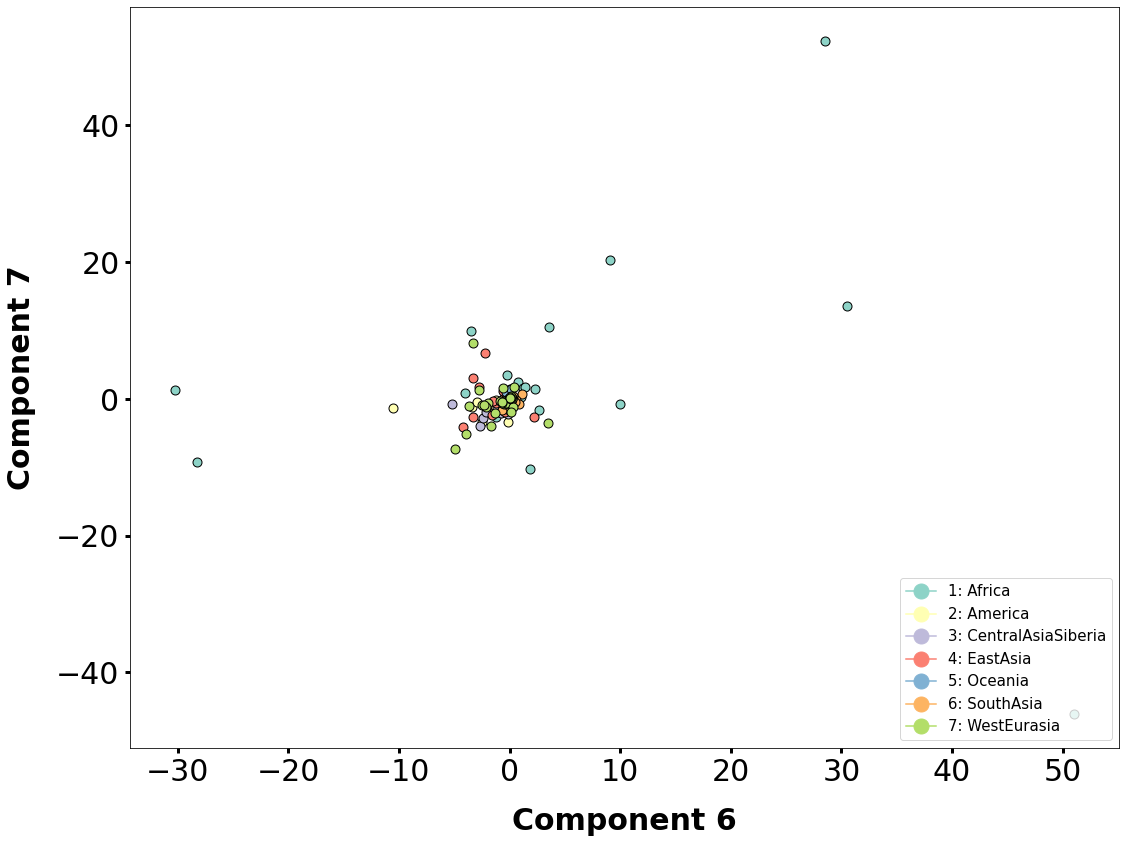

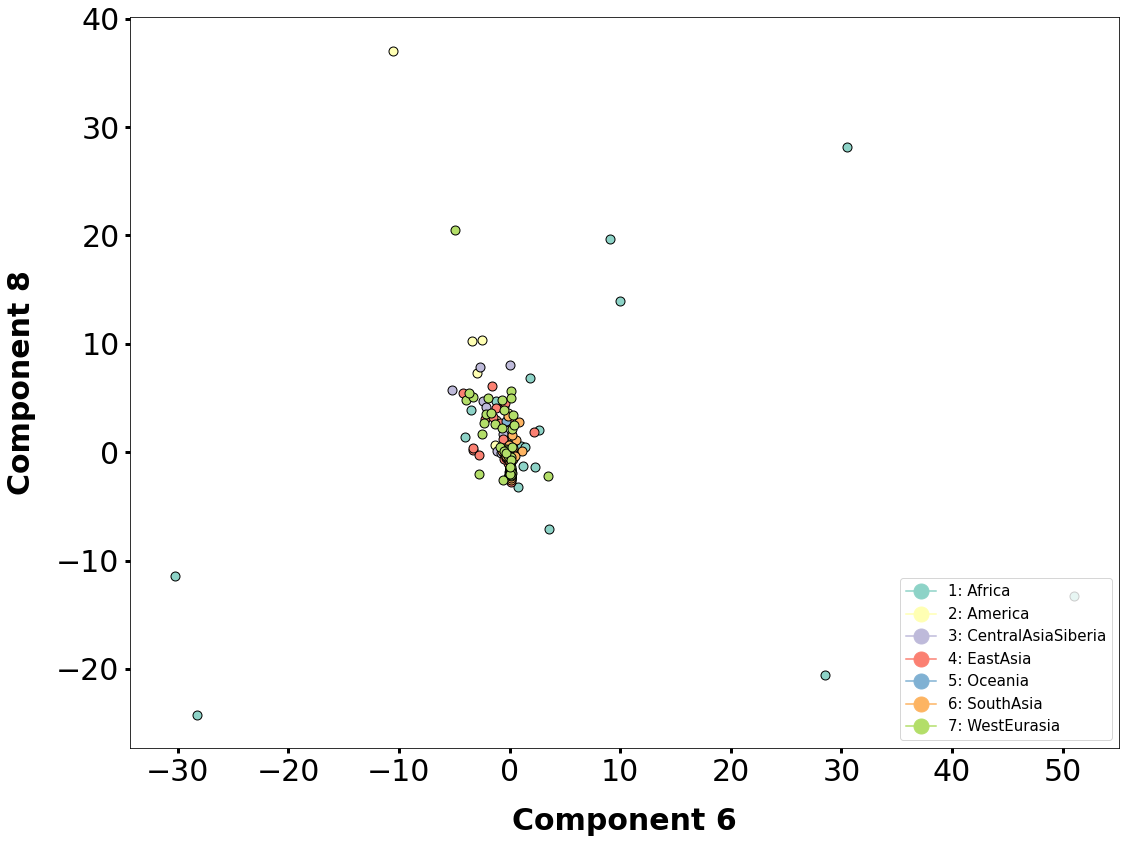

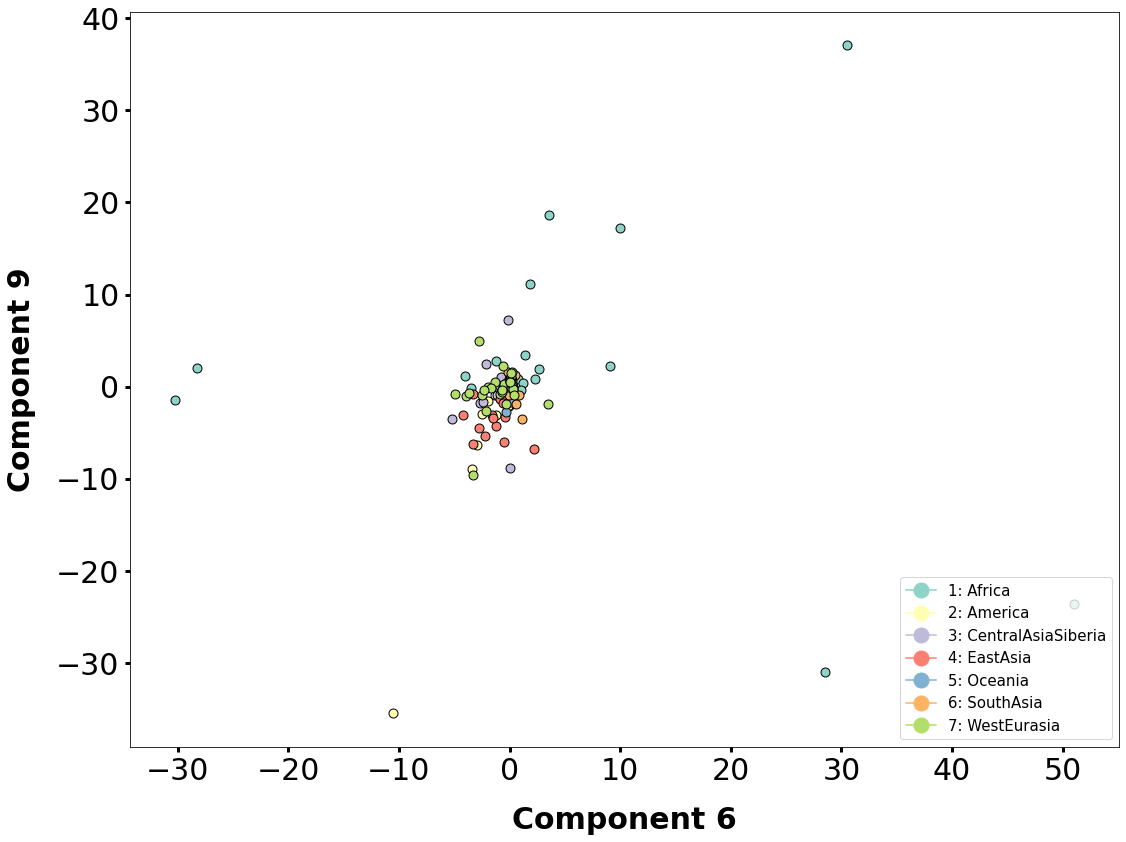

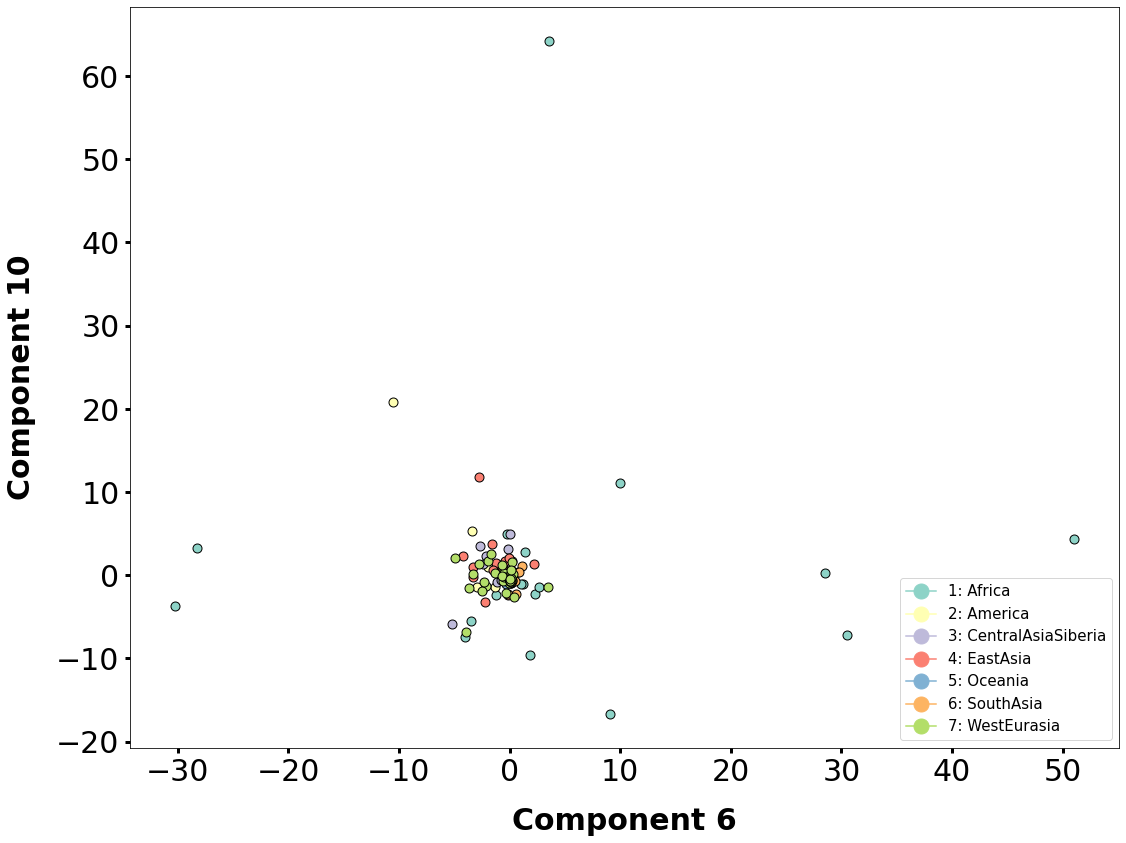

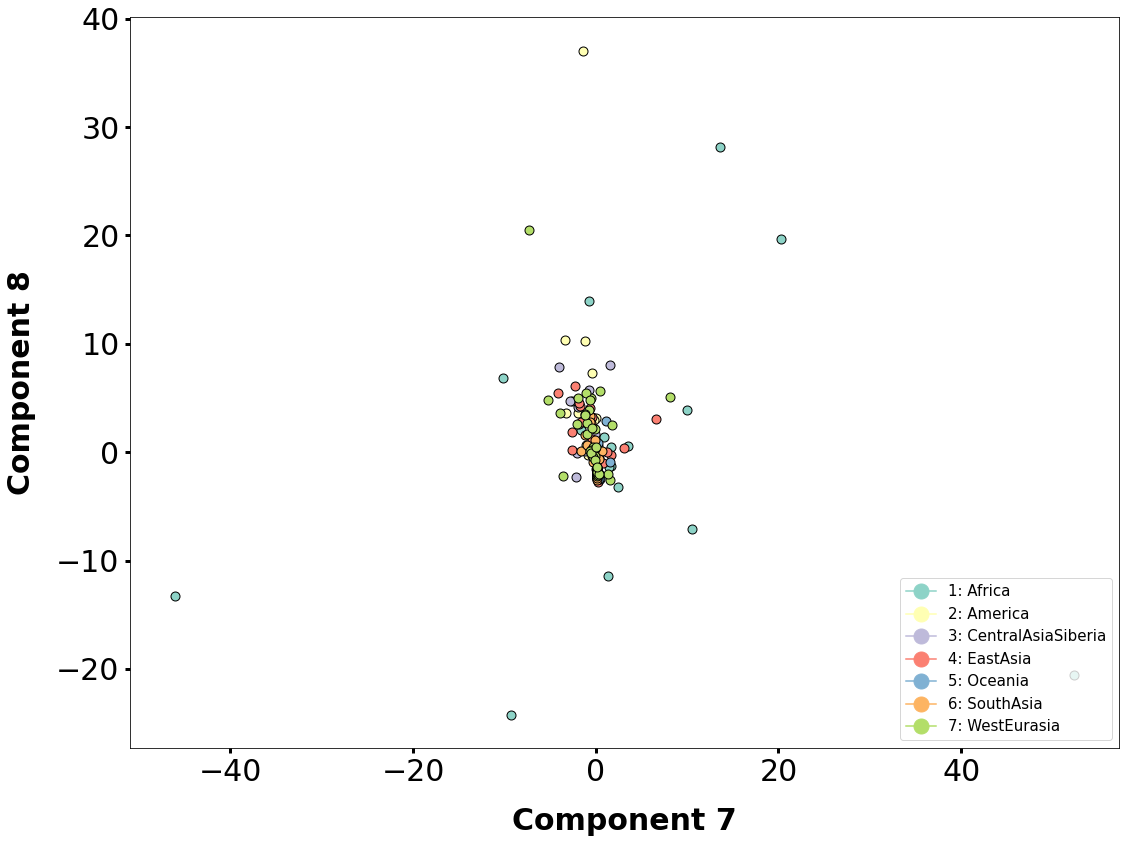

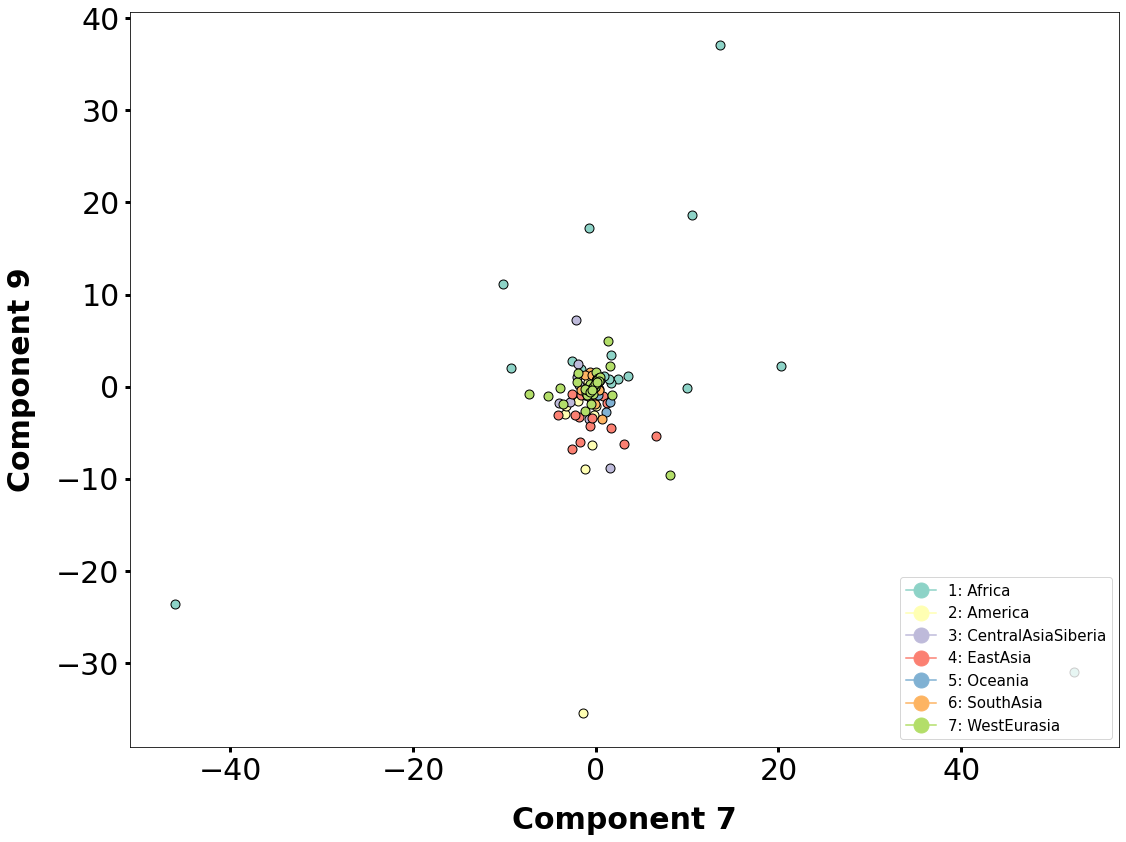

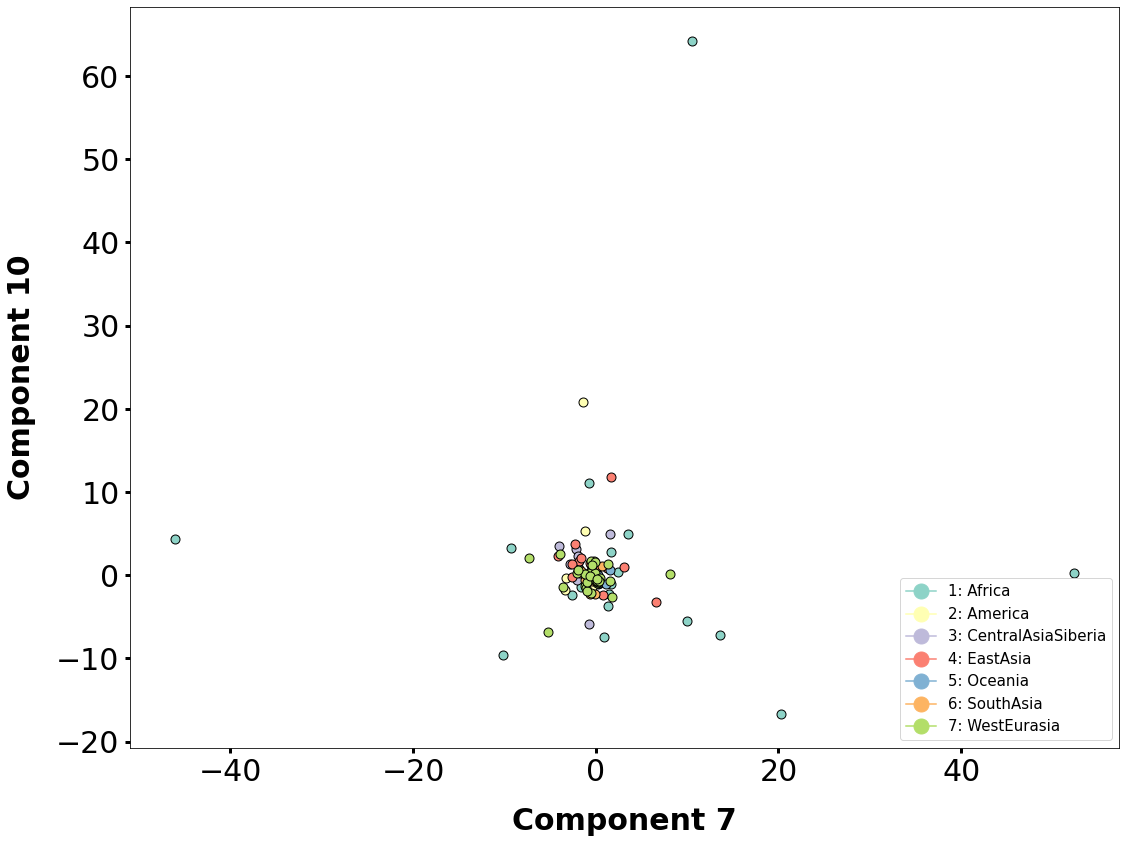

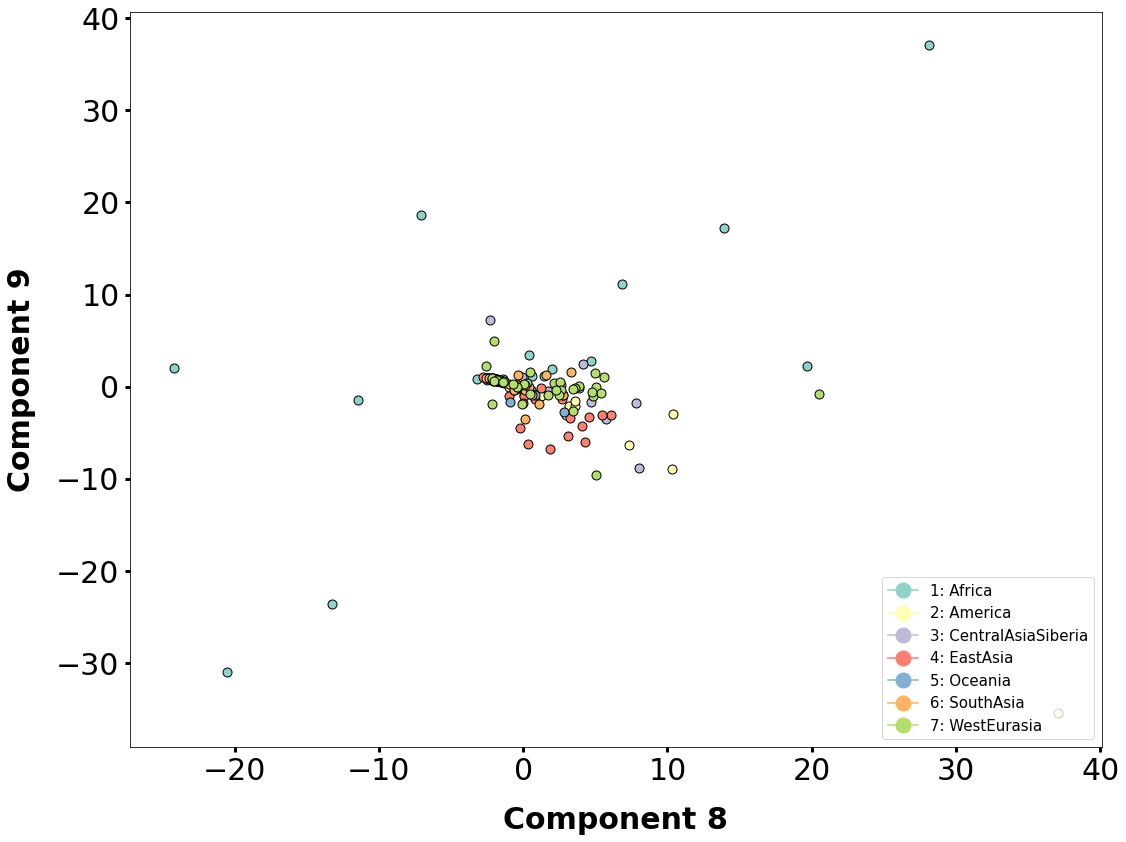

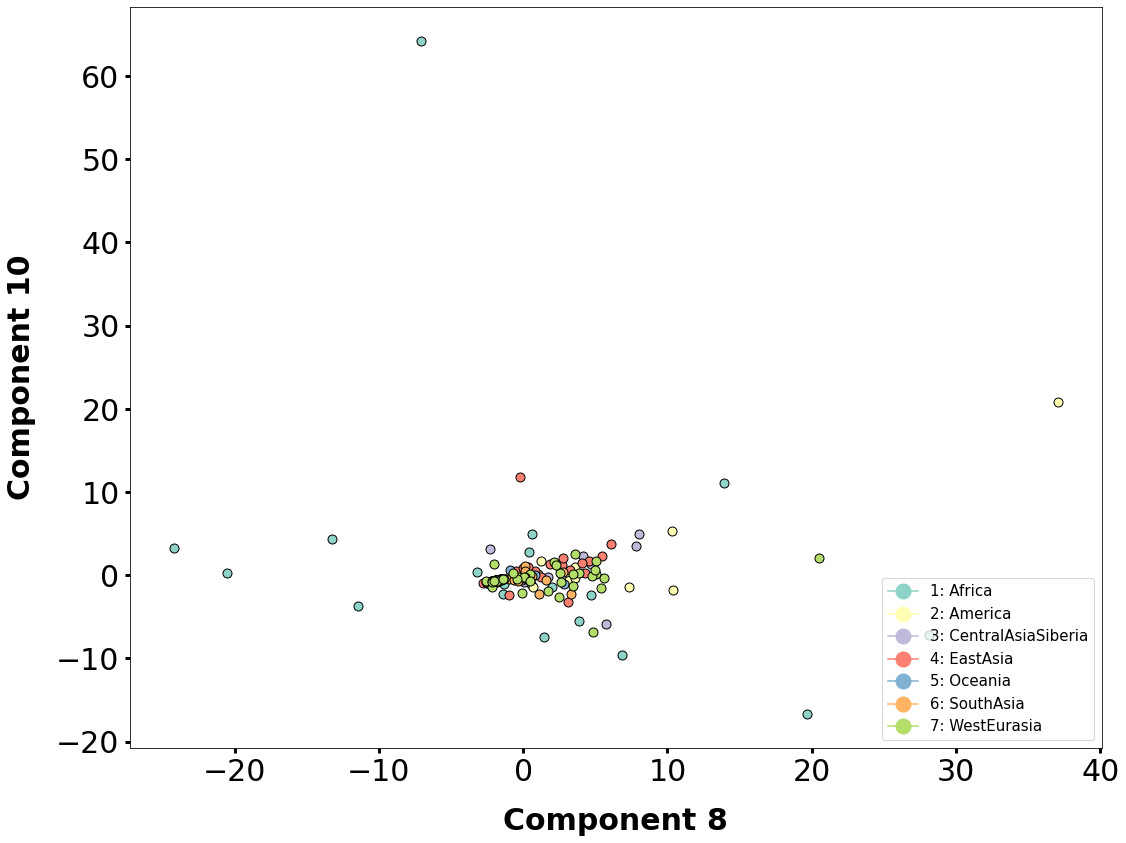

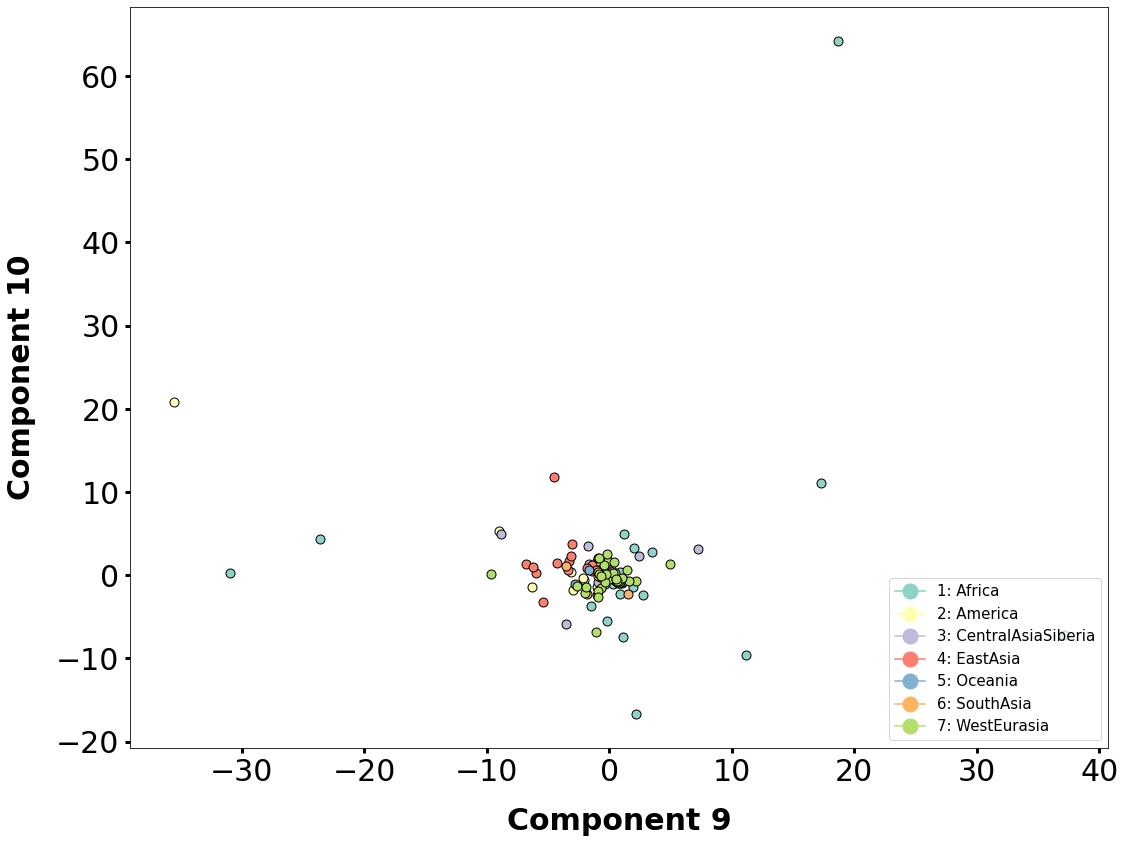

In [106]:
df_pca_outlier = df_pca[df_pca['component_1'] < 30]
df_pca_outlier = df_pca_outlier[df_pca_outlier['component_2'] < 30]
df_pca_outlier = df_pca_outlier[df_pca_outlier['component_3'] < 30]
#df_pca_outlier = df_pca_outlier[df_pca_outlier['component_4'] < 20]
#df_pca_outlier = df_pca_outlier[df_pca_outlier['component_5'] < 20]
#df_pca_outlier = df_pca_outlier[df_pca_outlier['component_6'] < 20]
#df_pca_outlier = df_pca_outlier[df_pca_outlier['component_7'] < 20]
#df_pca_outlier = df_pca_outlier[df_pca_outlier['component_8'] < 20]
#df_pca_outlier = df_pca_outlier[df_pca_outlier['component_9'] < 20]
#df_pca_outlier = df_pca_outlier[df_pca_outlier['component_10'] < 20]


outliers = pd.concat([df_pca,df_pca_outlier]).drop_duplicates(keep=False)

outlier_samples = list(outliers.index)
outlier_samples

components = [1,2,3,4,5,6,7,8,9,10]

combinations_components = list(combinations(components,2))
for i in combinations_components:
    plot_scatter_cluster(data=df_pca_outlier, abscissa='component_'+str(i[0]), ordinate='component_'+str(i[1]), label_horizontal='Component '+ str(i[0]), label_vertical='Component '+str(i[1]), factor='10-Region', fonts=define_font_properties(), colors=define_color_properties(), legend=True)
    #print(str(i[0]))
#    plot_scatter_cluster(data=df_pca, abscissa='component_8', ordinate='component_9', label_horizontal='Component 1', label_vertical='Component 3', factor='10-Region', fonts=define_font_properties(), colors=define_color_properties(), legend=True)
    

In [107]:
from Bio.Phylo.TreeConstruction import _Matrix
from Bio.Phylo.TreeConstruction import DistanceMatrix
from scipy.spatial.distance import pdist, squareform

#distance_matrix(np.array(counts))
distances = pdist(np.array(counts.T), metric='euclidean')
dist_matrix = squareform(distances)
dist_matrix.shape
#dist_matrix = dist_matrix.tolist()
#dist_matrix =np.tril(dist_matrix)
#dist_matrix = dist_matrix.tolist()
#np.triu(np.ones_like(dist_matrix))

dist_matrix

name =  list(counts.T.index)
matrix = dist_matrix
#m = _Matrix(names, matrix)
dist_matrix.shape

(238, 238)

In [108]:
from biotite.sequence.phylo import neighbor_joining
#track features for pca & tsne
features = features.sort_index()

#names.get_indices()
labels = list(counts.T.index)
labels = list(features['10-Region'])
tree = biotite.sequence.phylo.neighbor_joining(dist_matrix)
t = print(tree.to_newick(labels=labels, include_distance=False))
t#

(((((((((((SouthAsia,SouthAsia),EastAsia),(SouthAsia,(((EastAsia,(SouthAsia,WestEurasia)),(((WestEurasia,SouthAsia),(WestEurasia,WestEurasia)),CentralAsiaSiberia)),SouthAsia))),EastAsia),((((((((((((((((((((((((((((((((Oceania,((((((((((CentralAsiaSiberia,(SouthAsia,CentralAsiaSiberia)),(((((((((Africa,Africa),Africa),Africa),Africa),Africa),WestEurasia),Africa),(((((WestEurasia,((WestEurasia,SouthAsia),CentralAsiaSiberia)),America),WestEurasia),WestEurasia),(EastAsia,(EastAsia,EastAsia)))),(Africa,WestEurasia))),Oceania),(EastAsia,(CentralAsiaSiberia,(EastAsia,CentralAsiaSiberia)))),CentralAsiaSiberia),EastAsia),America),Africa),Africa),WestEurasia)),(WestEurasia,((SouthAsia,SouthAsia),WestEurasia))),Africa),(WestEurasia,EastAsia)),((EastAsia,EastAsia),Oceania)),WestEurasia),((WestEurasia,EastAsia),EastAsia)),((((EastAsia,WestEurasia),(America,EastAsia)),WestEurasia),(Africa,WestEurasia))),(((CentralAsiaSiberia,SouthAsia),WestEurasia),WestEurasia)),(EastAsia,America)),(((WestEurasia,A

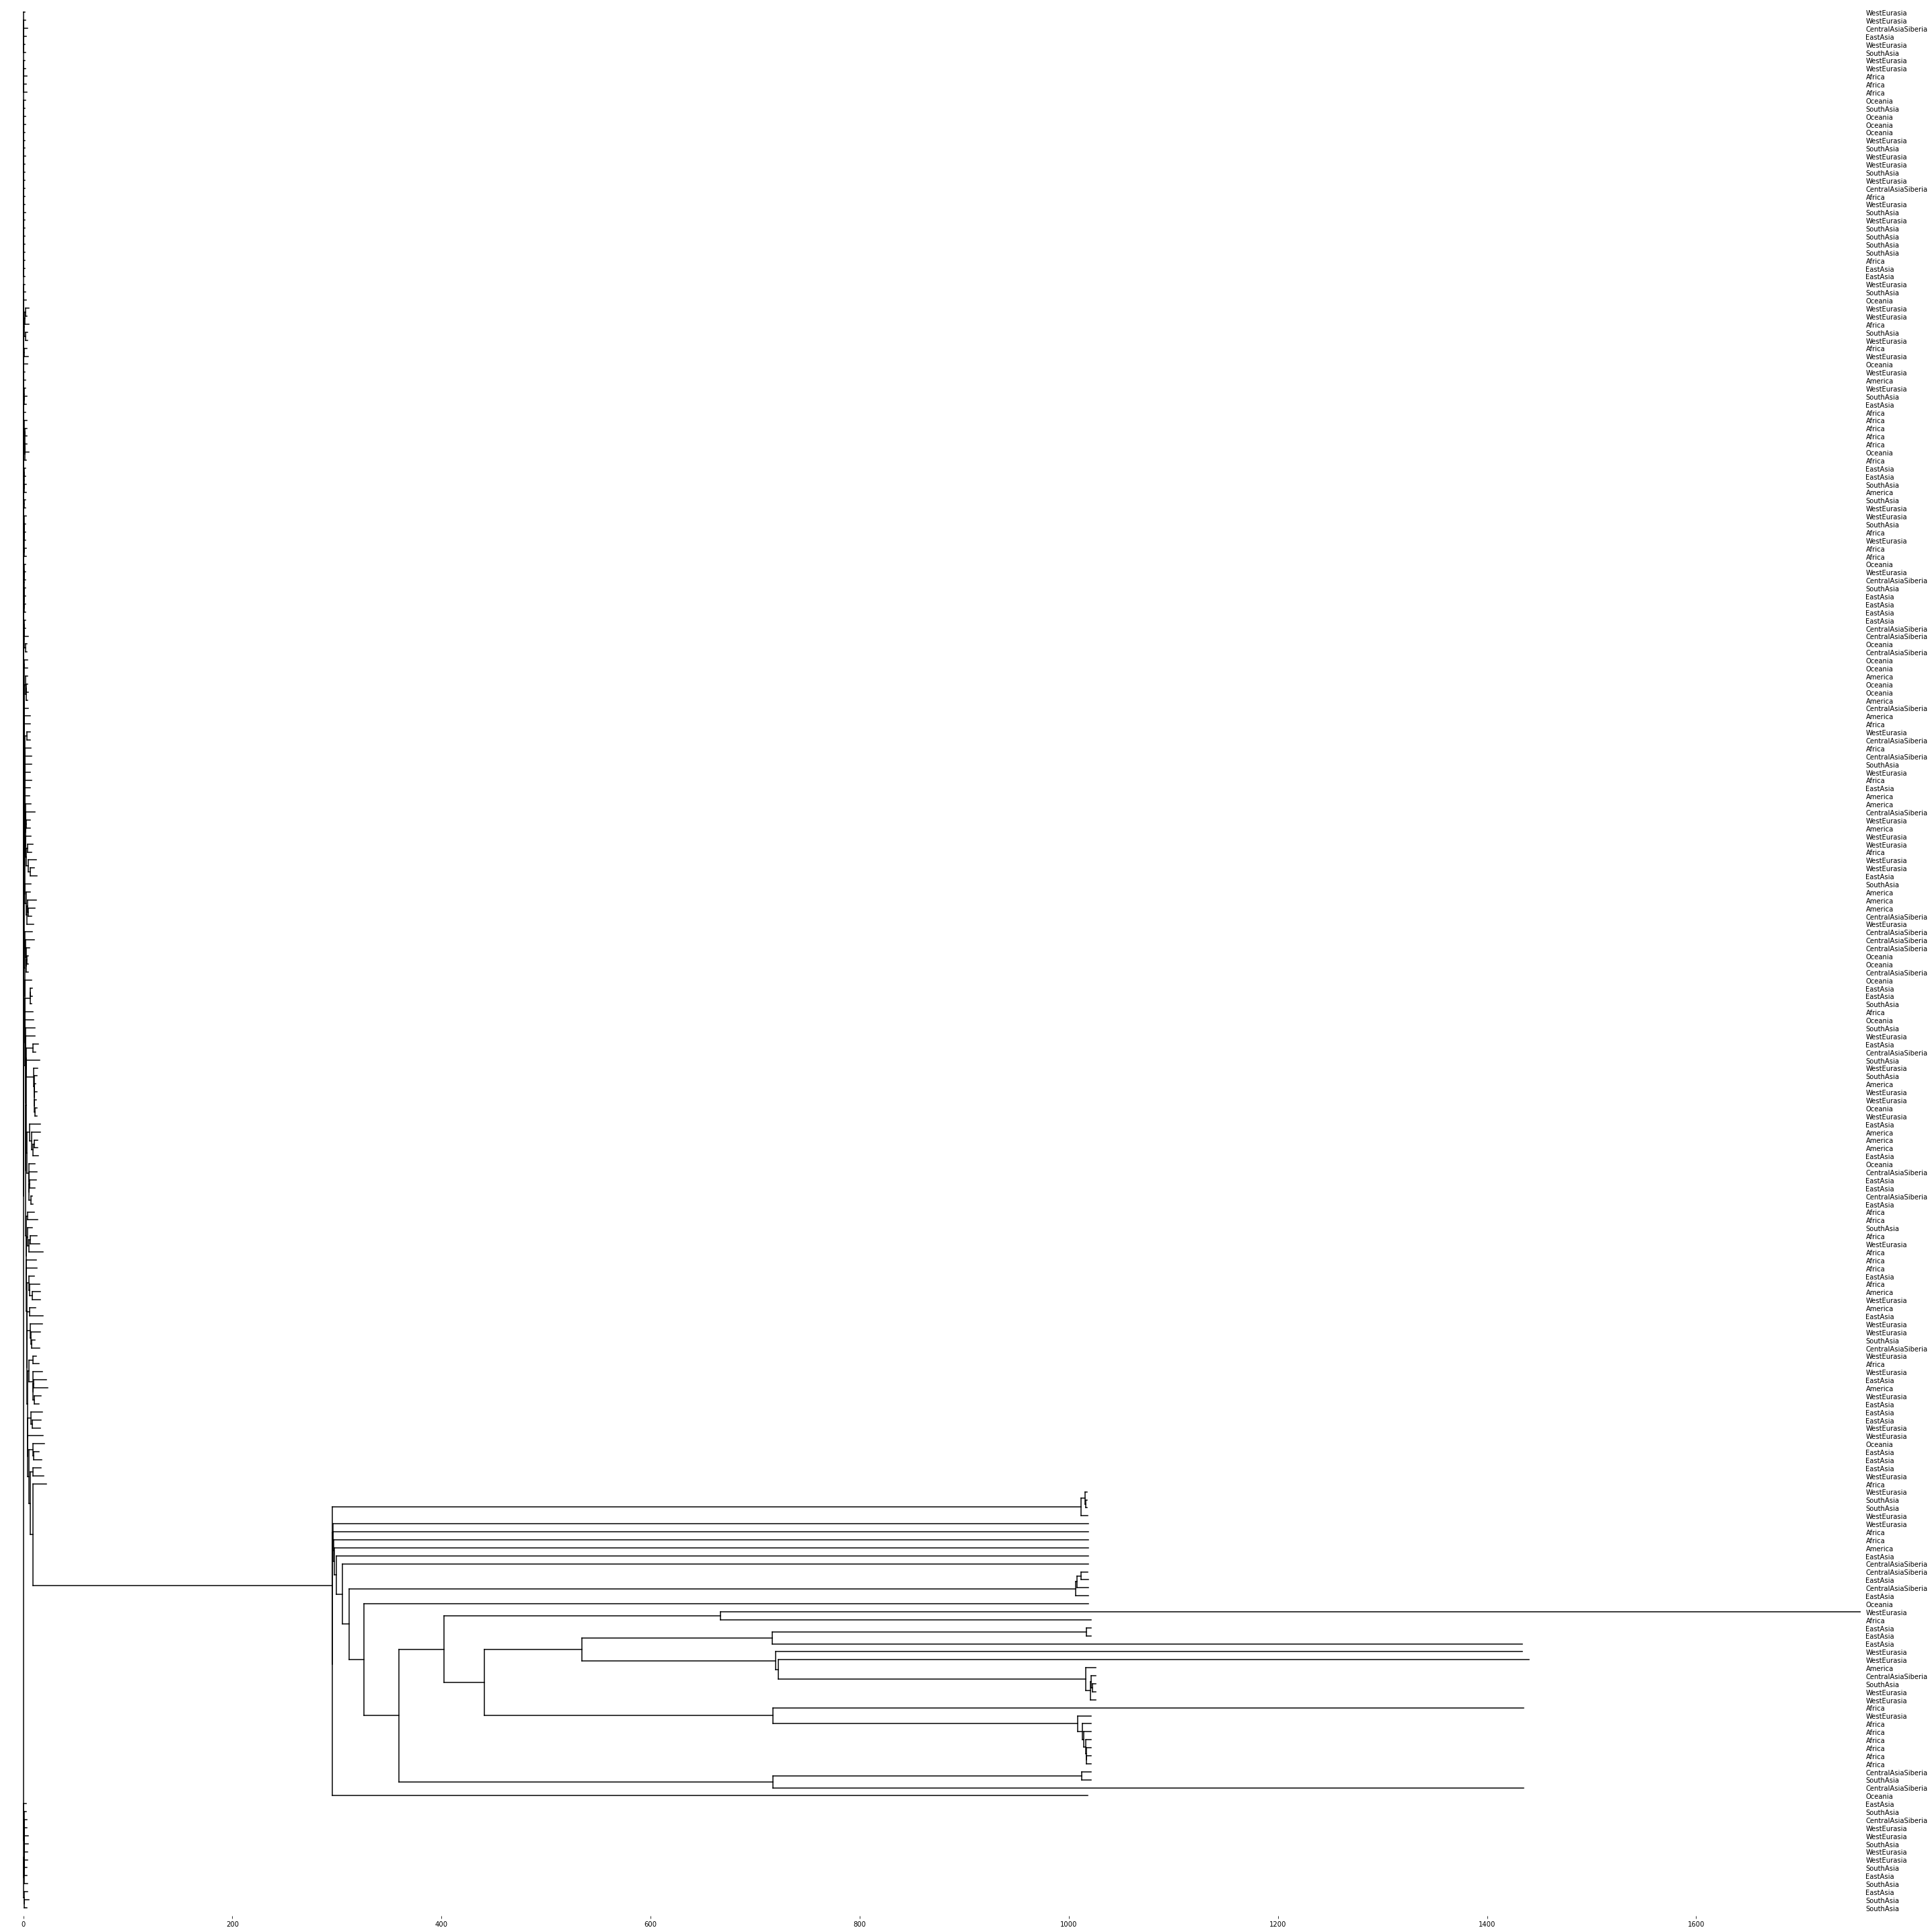

In [109]:
import biotite.sequence.graphics as graphics



row_colors = features['10-Region'].map(lut)

fig, ax = plt.subplots(figsize=(40.0, 40.0))
graphics.plot_dendrogram(ax, tree, labels=labels)
fig.tight_layout()

In [110]:
#pd.set_option("display.max_rows", None, "display.max_columns", None)
heterozygous_deletions = qdnaseq_df[qdnaseq_df['TYPE'] == 1] 
heterozygous_deletions = heterozygous_deletions.groupby('SAMPLE').sum()
#heterozygous_deletions = heterozygous_deletions.set_index('SAMPLE')
#features = anotation.merge(count, left_index=True, right_index=True)
#features = features.loc[:,["7-Gender","10-Region", "11-Country"]]
#features = features.sort_index()
#features
heterozygous_deletions = features.merge(heterozygous_deletions, left_index=True, right_index=True)
heterozygous_deletions = heterozygous_deletions.reset_index()

#heterozygous_deletions.value_counts('SAMPLE').sort_index()
heterozygous_deletions

index 7-Gender    10-Region 11-Country       START         END  \
0   SAMEA3302611        F     EastAsia      China   274590004   274875000   
1   SAMEA3302613        F     EastAsia    Vietnam  2886565031  2890400000   
2   SAMEA3302614        F     EastAsia      China   132765002   133470000   
3   SAMEA3302616        F    SouthAsia   Pakistan   616275012   617820000   
4   SAMEA3302619        F      America   Colombia  2858355034  2861475000   
..           ...      ...          ...        ...         ...         ...   
90  SAMEA3302896        F      America       Peru  2513125030  2515990000   
91  SAMEA3302900        M       Africa    Namibia    69255001    69345000   
92  SAMEA3302902        M      America     Brazil   324105007   324960000   
93  SAMEA3302903        F  WestEurasia     France  2891370035  2894790000   
94  SAMEA3302906        F     EastAsia      Japan  2835525030  2838070000   

       SIZE   LOG2  TYPE  
0    285000  -3.66     4  
1   3835000 -44.45    31  
2    705000  -2.07     2  
3   1545000 -27.47    12  
4   3120000 -58.84    34  
..      ...    ...   ...  
90  2865000 -34.24    30  
91    90000  -3.28     1  
92   855000  -6.62     7  
93  3420000 -46.83    35  
94  2545000 -50.59    30  

[95 rows x 9 columns]

/opt/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/opt/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/opt/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)

<AxesSubplot:xlabel='TYPE', ylabel='10-Region'>

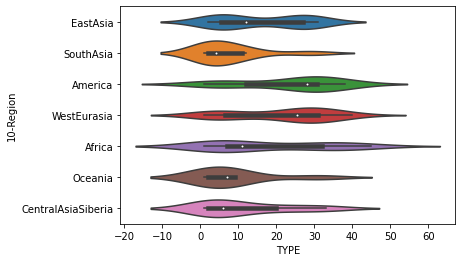

In [111]:
sns.violinplot(x="TYPE", y="10-Region", data=heterozygous_deletions)

In [112]:
#pd.set_option("display.max_rows", None, "display.max_columns", None)
biallelic_deletions = qdnaseq_df[qdnaseq_df['TYPE'] < 2 ] 
biallelic_deletions = biallelic_deletions.groupby('SAMPLE').size()

biallelic_deletions = pd.DataFrame(biallelic_deletions)
#biallelic_deletions = biallelic_deletions.set_index('SAMPLE')

biallelic_deletions = features.merge(biallelic_deletions, left_index=True, right_index=True)
#biallelic_deletions = biallelic_deletions.reset_index()

#heterozygous_deletions.value_counts('SAMPLE').sort_index()
biallelic_deletions.columns = ['7-Gender', '10-Region', '11-Country', 'TYPE']
biallelic_deletions

7-Gender  10-Region 11-Country  TYPE
SAMEA3302610        M  SouthAsia      India    18
SAMEA3302611        F   EastAsia      China     4
SAMEA3302613        F   EastAsia    Vietnam    33
SAMEA3302614        F   EastAsia      China     2
SAMEA3302615        M   EastAsia      China    18
...               ...        ...        ...   ...
SAMEA3302904        F    America     Mexico     7
SAMEA3302906        F   EastAsia      Japan    30
SAMEA3302908        M    Oceania        USA    26
SAMEA3302911        M  SouthAsia      Nepal    13
SAMEA3449877        M  SouthAsia   Pakistan    10

[237 rows x 4 columns]

/opt/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/opt/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/opt/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)

<AxesSubplot:xlabel='TYPE', ylabel='10-Region'>

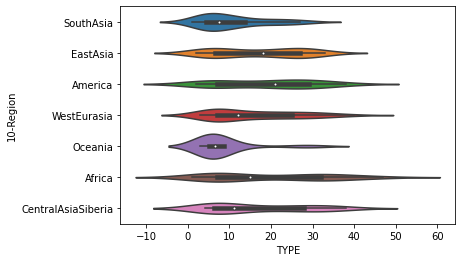

In [113]:
sns.violinplot(x="TYPE", y="10-Region", data=biallelic_deletions)


In [24]:
def plot_scatter_cluster(
data=None,
abscissa=None,
ordinate=None,
label_horizontal=None,
label_vertical=None,
factor=None,
fonts=None,
colors=None,
legend=None,
):
    """
    Creates a figure of a chart of type histogram to represent the frequency
    distribution of a single series of values.
    arguments:
        data (object): Pandas data frame of groups, series, and values
        abscissa (str): name of data column with independent variable
        ordinate (str): name of data column with dependent variable
        label_horizontal (str): label for horizontal axis
        label_vertical (str): label for vertical axis
        factor (str): name of data column with groups or factors of samples
        fonts (dict<object>): references to definitions of font properties
        colors (dict<tuple>): references to definitions of color properties
        legend (bool): whether to include a legend for series on the chart
    raises:
    returns:
        (object): figure object
    """
##########
# Organize data.
# Separate points by groups.
# Define groups.
    data = data.copy(deep=True)
    data.set_index(
        factor,
append=False,
drop=True,
inplace=True
    )
    print(data)
    groups = data.groupby(level=[factor])
    print("Count of groups by factor: " + str(len(groups)))
    colors_series = list(seaborn.color_palette("Set3", n_colors=len(groups)))
##########
# Create figure.
    figure = matplotlib.pyplot.figure(
    figsize=(15.748, 11.811),
    tight_layout=True
    )
# Create axes.
    axes = matplotlib.pyplot.axes()
    axes.set_xlabel(
    xlabel=label_horizontal,
labelpad=20,
alpha=1.0,
backgroundcolor=colors["white"],
color=colors["black"],
fontproperties=fonts["properties"]["one"]
    )
    axes.set_ylabel(
        ylabel=label_vertical,
        labelpad=20,
        alpha=1.0,
        backgroundcolor=colors["white"],
        color=colors["black"],
        fontproperties=fonts["properties"]["one"]
    )
    axes.tick_params(
        axis="both",
        which="both",
        direction="out",
        length=5.0,
        width=3.0,
        color=colors["black"],
        pad=5,
        labelsize=fonts["values"]["one"]["size"],
        labelcolor=colors["black"]
    )
# Plot points for values from each group.
    index = 0
    for name, group in groups:
        values_x = group[abscissa].to_list()
        values_y = group[ordinate].to_list()
        handle = axes.plot(
            values_x,
            values_y,
linestyle="",
marker="o",
markersize=9,
markeredgecolor=colors["black"],#colors_series[index],
markerfacecolor=colors_series[index]
        )
        index += 1
        pass
# Plot labels for each group.
    labels = []
    index = 0
    for name, group in groups:
        values_x = group[abscissa].to_list()
        mean_x = statistics.median(values_x)
        values_y = group[ordinate].to_list()
        mean_y = statistics.median(values_y)
#        axes.text(
#            mean_x,
#            mean_y,
#str(index+1),
#backgroundcolor=colors["white_faint"],
#color=colors["black"],
#fontproperties=fonts["properties"]["three"],
#horizontalalignment="center",
#verticalalignment="center"
#        )
        label = str(index+1) + ": " + name
        labels.append(label)
        index += 1
        pass
# Create legend.
# Create custome elements for the legend
    elements = create_legend_elements(
colors=colors_series,
labels=labels
    )
    axes.legend(
handles=elements,
loc="lower right",
prop=fonts["properties"]["four"],
    )
    return figure


def define_font_properties():
    """
    Defines font properties.
    arguments:
    raises:
    returns:
        (dict<object>): references to definitions of font properties
    """
# Define font values.
    values_one = {
"family": "sans-serif",
"style": "normal",
"variant": "normal",
"stretch": 1000,
"weight": 1000,
"size": 30
    }
    values_two = {
"family": "sans-serif",
"style": "normal",
"variant": "normal",
"stretch": 500,
"weight": 1000,
"size": 25
    }
    values_three = {
"family": "sans-serif",
"style": "normal",
"variant": "normal",
"stretch": 500,
"weight": 1000,
"size": 20
    }
    values_four = {
"family": "sans-serif",
"style": "normal",
"variant": "normal",
"stretch": 500,
"weight": 500,
"size": 15
    }
# Define font properties.
    properties_one = matplotlib.font_manager.FontProperties(
family=values_one["family"],
style=values_one["style"],
variant=values_one["variant"],
stretch=values_one["stretch"],
weight=values_one["weight"],
size=values_one["size"]
    )
    properties_two = matplotlib.font_manager.FontProperties(
family=values_two["family"],
style=values_two["style"],
variant=values_two["variant"],
stretch=values_two["stretch"],
weight=values_two["weight"],
size=values_two["size"]
    )
    properties_three = matplotlib.font_manager.FontProperties(
family=values_three["family"],
style=values_three["style"],
variant=values_three["variant"],
stretch=values_three["stretch"],
weight=values_three["weight"],
size=values_three["size"]
    )
    properties_four = matplotlib.font_manager.FontProperties(
family=values_four["family"],
style=values_four["style"],
variant=values_four["variant"],
stretch=values_four["stretch"],
weight=values_four["weight"],
size=values_four["size"]
    )
# Compile and return references.
    return {
"values": {
"one": values_one,
"two": values_two,
"three": values_three,
"four": values_four
        },
"properties": {
"one": properties_one,
"two": properties_two,
"three": properties_three,
"four": properties_four
        }
    }



def define_color_properties():
    """
    Defines color properties.
    arguments:
    raises:
    returns:
        (dict<tuple>): references to definitions of color properties
    """
# Black.
    black = (0.0, 0.0, 0.0, 1.0)
# White.
    white = (1.0, 1.0, 1.0, 1.0)
    white_faint = (1.0, 1.0, 1.0, 0.75)
# Blue.
    blue = (0.0, 0.2, 0.5, 1.0)
    blue_faint = (0.0, 0.2, 0.5, 0.75)
# Orange.
    orange = (1.0, 0.6, 0.2, 1.0)
    orange_faint = (1.0, 0.6, 0.2, 0.75)
# Compile and return references.
    return {
"black": black,
"white": white,
"white_faint": white_faint,
"blue": blue,
"blue_faint": blue_faint,
"orange": orange,
"orange_faint": orange_faint
    }


def create_legend_elements(
colors=None,
labels=None,
):
    """
    Creates custom elements for legend.
    arguments:
        colors (list<dict>): colors
        labels (str): name of data column with independent variable
    raises:
    returns:
        (list<object>): elements for legend
    """
    elements = []
    for index in range(len(labels)):
        element = matplotlib.lines.Line2D(
            [0],
            [0],
            marker="o",
            color=colors[index],
            label=labels[index],
            markerfacecolor=colors[index],
            markersize=15,
        )
        elements.append(element)
    return elements